# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


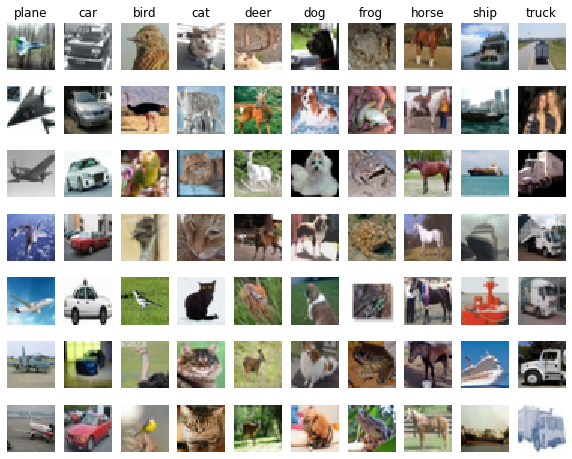

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


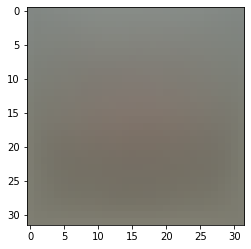

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.913116


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -9.766125 analytic: -6.109394, relative error: 2.303378e-01
numerical: -32.556387 analytic: -24.414168, relative error: 1.429198e-01
numerical: -37.671380 analytic: -30.272872, relative error: 1.088909e-01
numerical: -17.010626 analytic: -12.749302, relative error: 1.431900e-01
numerical: 24.778013 analytic: 19.714719, relative error: 1.138005e-01
numerical: 9.025032 analytic: 12.974909, relative error: 1.795404e-01
numerical: -6.648155 analytic: -5.246326, relative error: 1.178554e-01
numerical: 42.208618 analytic: 31.584494, relative error: 1.439718e-01
numerical: -41.868286 analytic: -34.158568, relative error: 1.014078e-01
numerical: 25.942040 analytic: 21.329427, relative error: 9.757711e-02
numerical: 7.665814 analytic: 5.615108, relative error: 1.544099e-01
numerical: -5.518954 analytic: -2.500769, relative error: 3.763453e-01
numerical: 16.745142 analytic: 12.879264, relative error: 1.304964e-01
numerical: 6.599844 analytic: 7.229112, relative error: 4.550365e-02
num

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  
不知道

In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.913116e+00 computed in 0.169882s
(3073, 500)
Vectorized loss: 8.913116e+00 computed in 0.052722s
difference: -0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.153856s
(3073, 500)
Vectorized loss and gradient: computed in 0.038079s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [35]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))







  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]





  0%|                                                                                 | 1/1500 [00:00<21:40,  1.15it/s]

iteration 0 / 1500: loss 782.575457








  0%|                                                                                 | 2/1500 [00:01<21:11,  1.18it/s]

iteration 1 / 1500: loss 771.053507








  0%|▏                                                                                | 3/1500 [00:02<20:47,  1.20it/s]

iteration 2 / 1500: loss 766.024505








  0%|▏                                                                                | 4/1500 [00:03<20:30,  1.22it/s]

iteration 3 / 1500: loss 757.578045








  0%|▎                                                                                | 5/1500 [00:04<20:11,  1.23it/s]

iteration 4 / 1500: loss 748.710604








  0%|▎                                                                                | 6/1500 [00:04<19:56,  1.25it/s]

iteration 5 / 1500: loss 742.735390








  0%|▍                                                                                | 7/1500 [00:05<19:43,  1.26it/s]

iteration 6 / 1500: loss 734.204096








  1%|▍                                                                                | 8/1500 [00:06<19:28,  1.28it/s]

iteration 7 / 1500: loss 724.156514








  1%|▍                                                                                | 9/1500 [00:07<19:08,  1.30it/s]

iteration 8 / 1500: loss 720.519320








  1%|▌                                                                               | 10/1500 [00:07<18:59,  1.31it/s]

iteration 9 / 1500: loss 710.212858








  1%|▌                                                                               | 11/1500 [00:08<18:57,  1.31it/s]

iteration 10 / 1500: loss 702.788408








  1%|▋                                                                               | 12/1500 [00:09<18:40,  1.33it/s]

iteration 11 / 1500: loss 697.334895








  1%|▋                                                                               | 13/1500 [00:10<18:38,  1.33it/s]

iteration 12 / 1500: loss 693.633938








  1%|▋                                                                               | 14/1500 [00:10<18:38,  1.33it/s]

iteration 13 / 1500: loss 684.206888








  1%|▊                                                                               | 15/1500 [00:11<18:32,  1.34it/s]

iteration 14 / 1500: loss 674.537607








  1%|▊                                                                               | 16/1500 [00:12<18:20,  1.35it/s]

iteration 15 / 1500: loss 667.845578








  1%|▉                                                                               | 17/1500 [00:13<18:08,  1.36it/s]

iteration 16 / 1500: loss 660.714769








  1%|▉                                                                               | 18/1500 [00:13<18:35,  1.33it/s]

iteration 17 / 1500: loss 654.733117








  1%|█                                                                               | 19/1500 [00:14<18:30,  1.33it/s]

iteration 18 / 1500: loss 647.610694








  1%|█                                                                               | 20/1500 [00:15<18:08,  1.36it/s]

iteration 19 / 1500: loss 642.494934








  1%|█                                                                               | 21/1500 [00:15<17:57,  1.37it/s]

iteration 20 / 1500: loss 633.911164








  1%|█▏                                                                              | 22/1500 [00:16<17:47,  1.38it/s]

iteration 21 / 1500: loss 629.379361








  2%|█▏                                                                              | 23/1500 [00:17<18:37,  1.32it/s]

iteration 22 / 1500: loss 621.131386








  2%|█▎                                                                              | 24/1500 [00:18<18:27,  1.33it/s]

iteration 23 / 1500: loss 614.394729








  2%|█▎                                                                              | 25/1500 [00:19<18:43,  1.31it/s]

iteration 24 / 1500: loss 609.881351








  2%|█▍                                                                              | 26/1500 [00:19<19:23,  1.27it/s]

iteration 25 / 1500: loss 602.126431








  2%|█▍                                                                              | 27/1500 [00:20<18:44,  1.31it/s]

iteration 26 / 1500: loss 596.636377








  2%|█▍                                                                              | 28/1500 [00:21<18:23,  1.33it/s]

iteration 27 / 1500: loss 593.498889








  2%|█▌                                                                              | 29/1500 [00:22<18:24,  1.33it/s]

iteration 28 / 1500: loss 584.442923








  2%|█▌                                                                              | 30/1500 [00:22<18:36,  1.32it/s]

iteration 29 / 1500: loss 578.745145








  2%|█▋                                                                              | 31/1500 [00:23<18:11,  1.35it/s]

iteration 30 / 1500: loss 574.941184








  2%|█▋                                                                              | 32/1500 [00:24<17:48,  1.37it/s]

iteration 31 / 1500: loss 567.925855








  2%|█▊                                                                              | 33/1500 [00:24<17:23,  1.41it/s]

iteration 32 / 1500: loss 562.794565








  2%|█▊                                                                              | 34/1500 [00:25<17:18,  1.41it/s]

iteration 33 / 1500: loss 556.230303








  2%|█▊                                                                              | 35/1500 [00:26<17:04,  1.43it/s]

iteration 34 / 1500: loss 549.510181








  2%|█▉                                                                              | 36/1500 [00:27<17:03,  1.43it/s]

iteration 35 / 1500: loss 544.591319








  2%|█▉                                                                              | 37/1500 [00:27<16:46,  1.45it/s]

iteration 36 / 1500: loss 538.755142








  3%|██                                                                              | 38/1500 [00:28<16:35,  1.47it/s]

iteration 37 / 1500: loss 534.333119








  3%|██                                                                              | 39/1500 [00:28<16:23,  1.49it/s]

iteration 38 / 1500: loss 529.817082








  3%|██▏                                                                             | 40/1500 [00:29<16:14,  1.50it/s]

iteration 39 / 1500: loss 523.376796








  3%|██▏                                                                             | 41/1500 [00:30<16:03,  1.51it/s]

iteration 40 / 1500: loss 518.962105








  3%|██▏                                                                             | 42/1500 [00:30<15:54,  1.53it/s]

iteration 41 / 1500: loss 514.532170








  3%|██▎                                                                             | 43/1500 [00:31<15:48,  1.54it/s]

iteration 42 / 1500: loss 509.133453








  3%|██▎                                                                             | 44/1500 [00:32<15:41,  1.55it/s]

iteration 43 / 1500: loss 503.975288








  3%|██▍                                                                             | 45/1500 [00:32<15:31,  1.56it/s]

iteration 44 / 1500: loss 498.064076








  3%|██▍                                                                             | 46/1500 [00:33<15:31,  1.56it/s]

iteration 45 / 1500: loss 494.415087








  3%|██▌                                                                             | 47/1500 [00:34<15:28,  1.56it/s]

iteration 46 / 1500: loss 488.642580








  3%|██▌                                                                             | 48/1500 [00:34<15:22,  1.57it/s]

iteration 47 / 1500: loss 484.942718








  3%|██▌                                                                             | 49/1500 [00:35<15:22,  1.57it/s]

iteration 48 / 1500: loss 479.396376








  3%|██▋                                                                             | 50/1500 [00:35<15:10,  1.59it/s]

iteration 49 / 1500: loss 474.081410








  3%|██▋                                                                             | 51/1500 [00:36<15:02,  1.60it/s]

iteration 50 / 1500: loss 469.519694








  3%|██▊                                                                             | 52/1500 [00:37<14:57,  1.61it/s]

iteration 51 / 1500: loss 465.049442








  4%|██▊                                                                             | 53/1500 [00:37<14:50,  1.62it/s]

iteration 52 / 1500: loss 459.912832








  4%|██▉                                                                             | 54/1500 [00:38<14:46,  1.63it/s]

iteration 53 / 1500: loss 455.639745








  4%|██▉                                                                             | 55/1500 [00:39<14:40,  1.64it/s]

iteration 54 / 1500: loss 452.682828








  4%|██▉                                                                             | 56/1500 [00:39<14:37,  1.65it/s]

iteration 55 / 1500: loss 446.321733








  4%|███                                                                             | 57/1500 [00:40<14:35,  1.65it/s]

iteration 56 / 1500: loss 440.575426








  4%|███                                                                             | 58/1500 [00:40<14:36,  1.65it/s]

iteration 57 / 1500: loss 438.438977








  4%|███▏                                                                            | 59/1500 [00:41<14:35,  1.65it/s]

iteration 58 / 1500: loss 434.959593








  4%|███▏                                                                            | 60/1500 [00:42<14:22,  1.67it/s]

iteration 59 / 1500: loss 428.782180








  4%|███▎                                                                            | 61/1500 [00:42<14:12,  1.69it/s]

iteration 60 / 1500: loss 424.984375








  4%|███▎                                                                            | 62/1500 [00:43<14:02,  1.71it/s]

iteration 61 / 1500: loss 420.971704








  4%|███▎                                                                            | 63/1500 [00:43<13:52,  1.73it/s]

iteration 62 / 1500: loss 418.403227








  4%|███▍                                                                            | 64/1500 [00:44<13:46,  1.74it/s]

iteration 63 / 1500: loss 412.143004








  4%|███▍                                                                            | 65/1500 [00:44<13:42,  1.74it/s]

iteration 64 / 1500: loss 409.025854








  4%|███▌                                                                            | 66/1500 [00:45<13:40,  1.75it/s]

iteration 65 / 1500: loss 405.655741








  4%|███▌                                                                            | 67/1500 [00:46<13:34,  1.76it/s]

iteration 66 / 1500: loss 400.436423








  5%|███▋                                                                            | 68/1500 [00:46<13:29,  1.77it/s]

iteration 67 / 1500: loss 396.532925








  5%|███▋                                                                            | 69/1500 [00:47<13:26,  1.77it/s]

iteration 68 / 1500: loss 393.959449








  5%|███▋                                                                            | 70/1500 [00:47<13:24,  1.78it/s]

iteration 69 / 1500: loss 388.534243








  5%|███▊                                                                            | 71/1500 [00:48<13:19,  1.79it/s]

iteration 70 / 1500: loss 384.990416








  5%|███▊                                                                            | 72/1500 [00:48<13:24,  1.77it/s]

iteration 71 / 1500: loss 380.802543








  5%|███▉                                                                            | 73/1500 [00:49<13:15,  1.79it/s]

iteration 72 / 1500: loss 377.368156








  5%|███▉                                                                            | 74/1500 [00:49<13:10,  1.80it/s]

iteration 73 / 1500: loss 372.908024








  5%|████                                                                            | 75/1500 [00:50<13:11,  1.80it/s]

iteration 74 / 1500: loss 369.299036








  5%|████                                                                            | 76/1500 [00:50<13:05,  1.81it/s]

iteration 75 / 1500: loss 366.173689








  5%|████                                                                            | 77/1500 [00:51<12:57,  1.83it/s]

iteration 76 / 1500: loss 362.643593








  5%|████▏                                                                           | 78/1500 [00:52<12:51,  1.84it/s]

iteration 77 / 1500: loss 358.411131








  5%|████▏                                                                           | 79/1500 [00:52<12:40,  1.87it/s]

iteration 78 / 1500: loss 354.712530








  5%|████▎                                                                           | 80/1500 [00:53<12:31,  1.89it/s]

iteration 79 / 1500: loss 352.639365








  5%|████▎                                                                           | 81/1500 [00:53<12:26,  1.90it/s]

iteration 80 / 1500: loss 347.620226








  5%|████▎                                                                           | 82/1500 [00:54<12:27,  1.90it/s]

iteration 81 / 1500: loss 345.249072








  6%|████▍                                                                           | 83/1500 [00:54<12:26,  1.90it/s]

iteration 82 / 1500: loss 342.823454








  6%|████▍                                                                           | 84/1500 [00:55<12:25,  1.90it/s]

iteration 83 / 1500: loss 338.723394








  6%|████▌                                                                           | 85/1500 [00:55<12:23,  1.90it/s]

iteration 84 / 1500: loss 334.448066








  6%|████▌                                                                           | 86/1500 [00:56<12:22,  1.90it/s]

iteration 85 / 1500: loss 333.157732








  6%|████▋                                                                           | 87/1500 [00:56<12:16,  1.92it/s]

iteration 86 / 1500: loss 328.149029








  6%|████▋                                                                           | 88/1500 [00:57<12:12,  1.93it/s]

iteration 87 / 1500: loss 325.368771








  6%|████▋                                                                           | 89/1500 [00:57<12:06,  1.94it/s]

iteration 88 / 1500: loss 321.610190








  6%|████▊                                                                           | 90/1500 [00:58<12:01,  1.96it/s]

iteration 89 / 1500: loss 318.444211








  6%|████▊                                                                           | 91/1500 [00:58<11:53,  1.98it/s]

iteration 90 / 1500: loss 314.603555








  6%|████▉                                                                           | 92/1500 [00:59<11:44,  2.00it/s]

iteration 91 / 1500: loss 312.347601








  6%|████▉                                                                           | 93/1500 [00:59<11:39,  2.01it/s]

iteration 92 / 1500: loss 309.598526








  6%|█████                                                                           | 94/1500 [01:00<11:38,  2.01it/s]

iteration 93 / 1500: loss 306.364476








  6%|█████                                                                           | 95/1500 [01:00<11:34,  2.02it/s]

iteration 94 / 1500: loss 304.213444








  6%|█████                                                                           | 96/1500 [01:01<11:29,  2.04it/s]

iteration 95 / 1500: loss 300.370624








  6%|█████▏                                                                          | 97/1500 [01:01<11:21,  2.06it/s]

iteration 96 / 1500: loss 297.586130








  7%|█████▏                                                                          | 98/1500 [01:02<11:58,  1.95it/s]

iteration 97 / 1500: loss 294.622723








  7%|█████▎                                                                          | 99/1500 [01:02<11:44,  1.99it/s]

iteration 98 / 1500: loss 291.579300








  7%|█████▎                                                                         | 100/1500 [01:03<11:30,  2.03it/s]

iteration 99 / 1500: loss 289.699584








  7%|█████▎                                                                         | 101/1500 [01:03<11:22,  2.05it/s]

iteration 100 / 1500: loss 284.430705








  7%|█████▎                                                                         | 102/1500 [01:04<11:15,  2.07it/s]

iteration 101 / 1500: loss 283.201476








  7%|█████▍                                                                         | 103/1500 [01:04<11:36,  2.01it/s]

iteration 102 / 1500: loss 279.102038








  7%|█████▍                                                                         | 104/1500 [01:05<11:17,  2.06it/s]

iteration 103 / 1500: loss 278.730379








  7%|█████▌                                                                         | 105/1500 [01:05<11:04,  2.10it/s]

iteration 104 / 1500: loss 275.455897








  7%|█████▌                                                                         | 106/1500 [01:06<11:00,  2.11it/s]

iteration 105 / 1500: loss 272.785979








  7%|█████▋                                                                         | 107/1500 [01:06<10:47,  2.15it/s]

iteration 106 / 1500: loss 269.509713








  7%|█████▋                                                                         | 108/1500 [01:07<11:18,  2.05it/s]

iteration 107 / 1500: loss 266.757827








  7%|█████▋                                                                         | 109/1500 [01:07<10:58,  2.11it/s]

iteration 108 / 1500: loss 263.321178








  7%|█████▊                                                                         | 110/1500 [01:07<10:40,  2.17it/s]

iteration 109 / 1500: loss 261.830630








  7%|█████▊                                                                         | 111/1500 [01:08<10:50,  2.14it/s]

iteration 110 / 1500: loss 258.758936








  7%|█████▉                                                                         | 112/1500 [01:09<11:37,  1.99it/s]

iteration 111 / 1500: loss 255.913134








  8%|█████▉                                                                         | 113/1500 [01:09<12:07,  1.91it/s]

iteration 112 / 1500: loss 254.215839








  8%|██████                                                                         | 114/1500 [01:10<12:02,  1.92it/s]

iteration 113 / 1500: loss 251.595176








  8%|██████                                                                         | 115/1500 [01:10<11:42,  1.97it/s]

iteration 114 / 1500: loss 251.474073








  8%|██████                                                                         | 116/1500 [01:11<11:40,  1.98it/s]

iteration 115 / 1500: loss 246.337112








  8%|██████▏                                                                        | 117/1500 [01:11<11:32,  2.00it/s]

iteration 116 / 1500: loss 245.987437








  8%|██████▏                                                                        | 118/1500 [01:11<11:01,  2.09it/s]

iteration 117 / 1500: loss 242.292016








  8%|██████▎                                                                        | 119/1500 [01:12<10:45,  2.14it/s]

iteration 118 / 1500: loss 240.185078








  8%|██████▎                                                                        | 120/1500 [01:12<10:56,  2.10it/s]

iteration 119 / 1500: loss 235.806974








  8%|██████▎                                                                        | 121/1500 [01:13<10:48,  2.13it/s]

iteration 120 / 1500: loss 235.250194








  8%|██████▍                                                                        | 122/1500 [01:13<10:50,  2.12it/s]

iteration 121 / 1500: loss 231.679153








  8%|██████▍                                                                        | 123/1500 [01:14<10:42,  2.14it/s]

iteration 122 / 1500: loss 230.260983








  8%|██████▌                                                                        | 124/1500 [01:14<10:36,  2.16it/s]

iteration 123 / 1500: loss 228.098043








  8%|██████▌                                                                        | 125/1500 [01:15<10:24,  2.20it/s]

iteration 124 / 1500: loss 226.552151








  8%|██████▋                                                                        | 126/1500 [01:15<10:12,  2.24it/s]

iteration 125 / 1500: loss 223.653180








  8%|██████▋                                                                        | 127/1500 [01:16<10:02,  2.28it/s]

iteration 126 / 1500: loss 220.753729








  9%|██████▋                                                                        | 128/1500 [01:16<09:51,  2.32it/s]

iteration 127 / 1500: loss 218.815230








  9%|██████▊                                                                        | 129/1500 [01:16<09:43,  2.35it/s]

iteration 128 / 1500: loss 217.202575








  9%|██████▊                                                                        | 130/1500 [01:17<09:38,  2.37it/s]

iteration 129 / 1500: loss 213.839044








  9%|██████▉                                                                        | 131/1500 [01:17<09:32,  2.39it/s]

iteration 130 / 1500: loss 212.560082








  9%|██████▉                                                                        | 132/1500 [01:18<09:27,  2.41it/s]

iteration 131 / 1500: loss 210.972058








  9%|███████                                                                        | 133/1500 [01:18<09:21,  2.43it/s]

iteration 132 / 1500: loss 209.745377








  9%|███████                                                                        | 134/1500 [01:18<09:15,  2.46it/s]

iteration 133 / 1500: loss 207.592794








  9%|███████                                                                        | 135/1500 [01:19<09:11,  2.47it/s]

iteration 134 / 1500: loss 204.721689








  9%|███████▏                                                                       | 136/1500 [01:19<09:06,  2.50it/s]

iteration 135 / 1500: loss 202.665544








  9%|███████▏                                                                       | 137/1500 [01:20<09:00,  2.52it/s]

iteration 136 / 1500: loss 200.534592








  9%|███████▎                                                                       | 138/1500 [01:20<08:59,  2.52it/s]

iteration 137 / 1500: loss 198.627313








  9%|███████▎                                                                       | 139/1500 [01:20<08:53,  2.55it/s]

iteration 138 / 1500: loss 197.241463








  9%|███████▎                                                                       | 140/1500 [01:21<08:46,  2.58it/s]

iteration 139 / 1500: loss 195.476775








  9%|███████▍                                                                       | 141/1500 [01:21<08:42,  2.60it/s]

iteration 140 / 1500: loss 193.425250








  9%|███████▍                                                                       | 142/1500 [01:21<08:34,  2.64it/s]

iteration 141 / 1500: loss 191.639786








 10%|███████▌                                                                       | 143/1500 [01:22<08:25,  2.68it/s]

iteration 142 / 1500: loss 188.624760








 10%|███████▌                                                                       | 144/1500 [01:22<08:22,  2.70it/s]

iteration 143 / 1500: loss 187.429169








 10%|███████▋                                                                       | 145/1500 [01:23<08:19,  2.71it/s]

iteration 144 / 1500: loss 186.080971








 10%|███████▋                                                                       | 146/1500 [01:23<08:13,  2.75it/s]

iteration 145 / 1500: loss 184.577935








 10%|███████▋                                                                       | 147/1500 [01:23<08:09,  2.76it/s]

iteration 146 / 1500: loss 182.439138








 10%|███████▊                                                                       | 148/1500 [01:24<08:06,  2.78it/s]

iteration 147 / 1500: loss 180.668090








 10%|███████▊                                                                       | 149/1500 [01:24<08:01,  2.80it/s]

iteration 148 / 1500: loss 177.902509








 10%|███████▉                                                                       | 150/1500 [01:24<07:57,  2.83it/s]

iteration 149 / 1500: loss 175.502715








 10%|███████▉                                                                       | 151/1500 [01:25<07:51,  2.86it/s]

iteration 150 / 1500: loss 174.529453








 10%|████████                                                                       | 152/1500 [01:25<07:45,  2.90it/s]

iteration 151 / 1500: loss 173.975827








 10%|████████                                                                       | 153/1500 [01:25<07:38,  2.94it/s]

iteration 152 / 1500: loss 171.871696








 10%|████████                                                                       | 154/1500 [01:26<07:33,  2.97it/s]

iteration 153 / 1500: loss 170.320083








 10%|████████▏                                                                      | 155/1500 [01:26<07:29,  3.00it/s]

iteration 154 / 1500: loss 168.980006








 10%|████████▏                                                                      | 156/1500 [01:26<07:24,  3.02it/s]

iteration 155 / 1500: loss 166.412353








 10%|████████▎                                                                      | 157/1500 [01:27<07:25,  3.01it/s]

iteration 156 / 1500: loss 165.521788








 11%|████████▎                                                                      | 158/1500 [01:27<07:19,  3.06it/s]

iteration 157 / 1500: loss 163.576400








 11%|████████▎                                                                      | 159/1500 [01:27<07:13,  3.09it/s]

iteration 158 / 1500: loss 162.253604








 11%|████████▍                                                                      | 160/1500 [01:28<07:08,  3.13it/s]

iteration 159 / 1500: loss 160.788366








 11%|████████▍                                                                      | 161/1500 [01:28<07:05,  3.14it/s]

iteration 160 / 1500: loss 159.267331








 11%|████████▌                                                                      | 162/1500 [01:28<07:02,  3.17it/s]

iteration 161 / 1500: loss 158.393410








 11%|████████▌                                                                      | 163/1500 [01:29<06:58,  3.19it/s]

iteration 162 / 1500: loss 155.486109








 11%|████████▋                                                                      | 164/1500 [01:29<06:50,  3.25it/s]

iteration 163 / 1500: loss 154.127140








 11%|████████▋                                                                      | 165/1500 [01:29<06:45,  3.29it/s]

iteration 164 / 1500: loss 153.054746








 11%|████████▋                                                                      | 166/1500 [01:29<06:39,  3.34it/s]

iteration 165 / 1500: loss 151.969427








 11%|████████▊                                                                      | 167/1500 [01:30<06:36,  3.37it/s]

iteration 166 / 1500: loss 149.968186








 11%|████████▊                                                                      | 168/1500 [01:30<06:29,  3.42it/s]

iteration 167 / 1500: loss 149.378446








 11%|████████▉                                                                      | 169/1500 [01:30<06:26,  3.44it/s]

iteration 168 / 1500: loss 147.974865








 11%|████████▉                                                                      | 170/1500 [01:31<06:19,  3.51it/s]

iteration 169 / 1500: loss 145.445732








 11%|█████████                                                                      | 171/1500 [01:31<06:12,  3.56it/s]

iteration 170 / 1500: loss 144.576283








 11%|█████████                                                                      | 172/1500 [01:31<06:08,  3.60it/s]

iteration 171 / 1500: loss 143.400869








 12%|█████████                                                                      | 173/1500 [01:31<06:02,  3.66it/s]

iteration 172 / 1500: loss 140.907667








 12%|█████████▏                                                                     | 174/1500 [01:32<06:00,  3.68it/s]

iteration 173 / 1500: loss 140.026329








 12%|█████████▏                                                                     | 175/1500 [01:32<05:53,  3.75it/s]

iteration 174 / 1500: loss 139.222302








 12%|█████████▎                                                                     | 176/1500 [01:32<05:47,  3.81it/s]

iteration 175 / 1500: loss 136.700181








 12%|█████████▎                                                                     | 177/1500 [01:32<05:41,  3.87it/s]

iteration 176 / 1500: loss 136.495369








 12%|█████████▎                                                                     | 178/1500 [01:33<05:37,  3.92it/s]

iteration 177 / 1500: loss 135.522354








 12%|█████████▍                                                                     | 179/1500 [01:33<05:34,  3.95it/s]

iteration 178 / 1500: loss 134.106617








 12%|█████████▍                                                                     | 180/1500 [01:33<05:28,  4.02it/s]

iteration 179 / 1500: loss 132.592409








 12%|█████████▌                                                                     | 181/1500 [01:33<05:22,  4.09it/s]

iteration 180 / 1500: loss 130.338038








 12%|█████████▌                                                                     | 182/1500 [01:34<05:21,  4.10it/s]

iteration 181 / 1500: loss 129.193997








 12%|█████████▋                                                                     | 183/1500 [01:34<05:16,  4.16it/s]

iteration 182 / 1500: loss 128.405876








 12%|█████████▋                                                                     | 184/1500 [01:34<05:11,  4.22it/s]

iteration 183 / 1500: loss 127.204671








 12%|█████████▋                                                                     | 185/1500 [01:34<05:07,  4.28it/s]

iteration 184 / 1500: loss 125.991688








 12%|█████████▊                                                                     | 186/1500 [01:34<05:01,  4.35it/s]

iteration 185 / 1500: loss 124.414439








 12%|█████████▊                                                                     | 187/1500 [01:35<04:56,  4.43it/s]

iteration 186 / 1500: loss 123.524938








 13%|█████████▉                                                                     | 188/1500 [01:35<04:52,  4.48it/s]

iteration 187 / 1500: loss 122.544416








 13%|█████████▉                                                                     | 189/1500 [01:35<04:49,  4.53it/s]

iteration 188 / 1500: loss 121.415722








 13%|██████████                                                                     | 190/1500 [01:35<04:44,  4.61it/s]

iteration 189 / 1500: loss 120.911719








 13%|██████████                                                                     | 191/1500 [01:36<04:40,  4.67it/s]







iteration 190 / 1500: loss 118.954987
iteration 191 / 1500: loss 118.237858


 13%|██████████                                                                     | 192/1500 [01:36<04:33,  4.78it/s]





 13%|██████████▏                                                                    | 193/1500 [01:36<04:30,  4.84it/s]







iteration 192 / 1500: loss 116.667305
iteration 193 / 1500: loss 116.153407


 13%|██████████▏                                                                    | 194/1500 [01:36<04:25,  4.92it/s]





 13%|██████████▎                                                                    | 195/1500 [01:36<04:22,  4.97it/s]







iteration 194 / 1500: loss 114.123598
iteration 195 / 1500: loss 113.606202


 13%|██████████▎                                                                    | 196/1500 [01:37<04:16,  5.08it/s]





 13%|██████████▍                                                                    | 197/1500 [01:37<04:12,  5.16it/s]





 13%|██████████▍                                                                    | 198/1500 [01:37<04:08,  5.25it/s]

iteration 196 / 1500: loss 111.929518
iteration 197 / 1500: loss 110.852102








 13%|██████████▍                                                                    | 199/1500 [01:37<04:02,  5.37it/s]





 13%|██████████▌                                                                    | 200/1500 [01:37<03:57,  5.47it/s]

iteration 198 / 1500: loss 111.040199
iteration 199 / 1500: loss 109.094195








 13%|██████████▌                                                                    | 201/1500 [01:37<03:52,  5.59it/s]





 13%|██████████▋                                                                    | 202/1500 [01:38<03:47,  5.69it/s]

iteration 200 / 1500: loss 108.033545
iteration 201 / 1500: loss 106.698542








 14%|██████████▋                                                                    | 203/1500 [01:38<03:44,  5.78it/s]





 14%|██████████▋                                                                    | 204/1500 [01:38<03:39,  5.90it/s]

iteration 202 / 1500: loss 106.415703
iteration 203 / 1500: loss 105.648369








 14%|██████████▊                                                                    | 205/1500 [01:38<03:36,  5.98it/s]





 14%|██████████▊                                                                    | 206/1500 [01:38<03:30,  6.16it/s]

iteration 204 / 1500: loss 104.102258
iteration 205 / 1500: loss 103.031966








 14%|██████████▉                                                                    | 207/1500 [01:38<03:24,  6.33it/s]





 14%|██████████▉                                                                    | 208/1500 [01:39<03:20,  6.46it/s]

iteration 206 / 1500: loss 102.149248
iteration 207 / 1500: loss 100.897090








 14%|███████████                                                                    | 209/1500 [01:39<03:15,  6.60it/s]





 14%|███████████                                                                    | 210/1500 [01:39<03:11,  6.75it/s]

iteration 208 / 1500: loss 99.107880
iteration 209 / 1500: loss 99.900102








 14%|███████████                                                                    | 211/1500 [01:39<03:06,  6.89it/s]





 14%|███████████▏                                                                   | 212/1500 [01:39<03:01,  7.09it/s]

iteration 210 / 1500: loss 98.778341
iteration 211 / 1500: loss 97.071090








 14%|███████████▏                                                                   | 213/1500 [01:39<02:59,  7.19it/s]





 14%|███████████▎                                                                   | 214/1500 [01:39<02:53,  7.41it/s]

iteration 212 / 1500: loss 95.692297
iteration 213 / 1500: loss 95.869288








 14%|███████████▎                                                                   | 215/1500 [01:39<02:51,  7.50it/s]





 14%|███████████▍                                                                   | 216/1500 [01:40<02:46,  7.73it/s]

iteration 214 / 1500: loss 94.878670
iteration 215 / 1500: loss 93.305154








 14%|███████████▍                                                                   | 217/1500 [01:40<02:43,  7.87it/s]





 15%|███████████▍                                                                   | 218/1500 [01:40<02:40,  8.00it/s]

iteration 216 / 1500: loss 93.107064
iteration 217 / 1500: loss 91.807100








 15%|███████████▌                                                                   | 219/1500 [01:40<02:35,  8.24it/s]





 15%|███████████▌                                                                   | 220/1500 [01:40<02:28,  8.61it/s]

iteration 218 / 1500: loss 90.245654
iteration 219 / 1500: loss 90.718068








 15%|███████████▋                                                                   | 221/1500 [01:40<02:24,  8.84it/s]





 15%|███████████▋                                                                   | 222/1500 [01:40<02:19,  9.14it/s]

iteration 220 / 1500: loss 89.929955
iteration 221 / 1500: loss 88.922416
iteration 222 / 1500: loss 88.103539







 15%|███████████▋                                                                   | 223/1500 [01:40<02:16,  9.33it/s]





 15%|███████████▊                                                                   | 224/1500 [01:40<02:14,  9.50it/s]


iteration 223 / 1500: loss 87.498172
iteration 224 / 1500: loss 86.509007








 15%|███████████▉                                                                   | 226/1500 [01:41<02:07,  9.96it/s]





 15%|████████████                                                                   | 228/1500 [01:41<02:00, 10.59it/s]

iteration 225 / 1500: loss 85.134858
iteration 226 / 1500: loss 84.310265
iteration 227 / 1500: loss 83.770577








 15%|████████████                                                                   | 230/1500 [01:41<01:53, 11.21it/s]

iteration 228 / 1500: loss 83.918649
iteration 229 / 1500: loss 82.252805
iteration 230 / 1500: loss 80.806020








 15%|████████████▏                                                                  | 232/1500 [01:41<01:44, 12.08it/s]





 16%|████████████▎                                                                  | 234/1500 [01:41<01:36, 13.09it/s]

iteration 231 / 1500: loss 81.159944
iteration 232 / 1500: loss 79.742326
iteration 233 / 1500: loss 78.583998
iteration 234 / 1500: loss 78.334299








 16%|████████████▍                                                                  | 236/1500 [01:41<01:28, 14.36it/s]





 16%|████████████▌                                                                  | 239/1500 [01:41<01:18, 16.04it/s]

iteration 235 / 1500: loss 76.884128
iteration 236 / 1500: loss 77.161788
iteration 237 / 1500: loss 76.643536
iteration 238 / 1500: loss 75.603839
iteration 239 / 1500: loss 74.621033








 16%|████████████▋                                                                  | 242/1500 [01:42<01:08, 18.40it/s]





 16%|█████████████                                                                  | 247/1500 [01:42<00:56, 22.25it/s]

iteration 240 / 1500: loss 74.157158
iteration 241 / 1500: loss 74.123591
iteration 242 / 1500: loss 73.084936
iteration 243 / 1500: loss 72.204700
iteration 244 / 1500: loss 71.278730
iteration 245 / 1500: loss 71.112383
iteration 246 / 1500: loss 71.158938
iteration 247 / 1500: loss 69.620798
iteration 248 / 1500: loss 69.429425








 17%|█████████████▏                                                                 | 250/1500 [01:45<07:18,  2.85it/s]

iteration 249 / 1500: loss 69.309475
iteration 250 / 1500: loss 68.789861








 17%|█████████████▎                                                                 | 252/1500 [01:47<10:18,  2.02it/s]

iteration 251 / 1500: loss 66.958479
iteration 252 / 1500: loss 66.616920








 17%|█████████████▍                                                                 | 254/1500 [01:48<12:18,  1.69it/s]

iteration 253 / 1500: loss 65.486335
iteration 254 / 1500: loss 64.695946








 17%|█████████████▍                                                                 | 256/1500 [01:50<13:44,  1.51it/s]

iteration 255 / 1500: loss 64.732717








 17%|█████████████▌                                                                 | 257/1500 [01:51<14:40,  1.41it/s]

iteration 256 / 1500: loss 64.652952








 17%|█████████████▌                                                                 | 258/1500 [01:51<15:16,  1.36it/s]

iteration 257 / 1500: loss 64.505259








 17%|█████████████▋                                                                 | 259/1500 [01:52<15:41,  1.32it/s]

iteration 258 / 1500: loss 63.056283








 17%|█████████████▋                                                                 | 260/1500 [01:53<15:58,  1.29it/s]

iteration 259 / 1500: loss 63.159903








 17%|█████████████▋                                                                 | 261/1500 [01:54<15:50,  1.30it/s]

iteration 260 / 1500: loss 62.128150








 17%|█████████████▊                                                                 | 262/1500 [01:55<15:34,  1.33it/s]

iteration 261 / 1500: loss 61.890047








 18%|█████████████▊                                                                 | 263/1500 [01:55<15:20,  1.34it/s]

iteration 262 / 1500: loss 60.995957








 18%|█████████████▉                                                                 | 264/1500 [01:56<15:05,  1.37it/s]

iteration 263 / 1500: loss 59.100580








 18%|█████████████▉                                                                 | 265/1500 [01:57<14:55,  1.38it/s]

iteration 264 / 1500: loss 59.782012








 18%|██████████████                                                                 | 266/1500 [01:57<14:47,  1.39it/s]

iteration 265 / 1500: loss 58.826541








 18%|██████████████                                                                 | 267/1500 [01:58<14:40,  1.40it/s]

iteration 266 / 1500: loss 57.996916








 18%|██████████████                                                                 | 268/1500 [01:59<14:32,  1.41it/s]

iteration 267 / 1500: loss 57.994326








 18%|██████████████▏                                                                | 269/1500 [01:59<14:26,  1.42it/s]

iteration 268 / 1500: loss 57.547812








 18%|██████████████▏                                                                | 270/1500 [02:00<14:22,  1.43it/s]

iteration 269 / 1500: loss 57.053888








 18%|██████████████▎                                                                | 271/1500 [02:01<14:19,  1.43it/s]

iteration 270 / 1500: loss 57.237395








 18%|██████████████▎                                                                | 272/1500 [02:02<14:14,  1.44it/s]

iteration 271 / 1500: loss 55.493441








 18%|██████████████▍                                                                | 273/1500 [02:02<14:12,  1.44it/s]

iteration 272 / 1500: loss 55.247448








 18%|██████████████▍                                                                | 274/1500 [02:03<14:05,  1.45it/s]

iteration 273 / 1500: loss 55.191832








 18%|██████████████▍                                                                | 275/1500 [02:04<13:59,  1.46it/s]

iteration 274 / 1500: loss 54.711530








 18%|██████████████▌                                                                | 276/1500 [02:04<13:55,  1.46it/s]

iteration 275 / 1500: loss 54.582465








 18%|██████████████▌                                                                | 277/1500 [02:05<13:53,  1.47it/s]

iteration 276 / 1500: loss 53.433340








 19%|██████████████▋                                                                | 278/1500 [02:06<13:50,  1.47it/s]

iteration 277 / 1500: loss 52.883691








 19%|██████████████▋                                                                | 279/1500 [02:06<13:45,  1.48it/s]

iteration 278 / 1500: loss 53.275048








 19%|██████████████▋                                                                | 280/1500 [02:07<13:38,  1.49it/s]

iteration 279 / 1500: loss 52.099275








 19%|██████████████▊                                                                | 281/1500 [02:08<13:33,  1.50it/s]

iteration 280 / 1500: loss 52.163209








 19%|██████████████▊                                                                | 282/1500 [02:08<13:28,  1.51it/s]

iteration 281 / 1500: loss 51.353324








 19%|██████████████▉                                                                | 283/1500 [02:09<13:24,  1.51it/s]

iteration 282 / 1500: loss 50.408511








 19%|██████████████▉                                                                | 284/1500 [02:10<13:22,  1.52it/s]

iteration 283 / 1500: loss 50.784421








 19%|███████████████                                                                | 285/1500 [02:10<13:15,  1.53it/s]

iteration 284 / 1500: loss 49.921725








 19%|███████████████                                                                | 286/1500 [02:11<13:11,  1.53it/s]

iteration 285 / 1500: loss 49.172152








 19%|███████████████                                                                | 287/1500 [02:11<13:09,  1.54it/s]

iteration 286 / 1500: loss 49.104244








 19%|███████████████▏                                                               | 288/1500 [02:12<13:08,  1.54it/s]

iteration 287 / 1500: loss 48.504658








 19%|███████████████▏                                                               | 289/1500 [02:13<13:01,  1.55it/s]

iteration 288 / 1500: loss 48.238333








 19%|███████████████▎                                                               | 290/1500 [02:13<12:58,  1.55it/s]

iteration 289 / 1500: loss 48.715081








 19%|███████████████▎                                                               | 291/1500 [02:14<12:52,  1.56it/s]

iteration 290 / 1500: loss 47.180660








 19%|███████████████▍                                                               | 292/1500 [02:15<12:47,  1.57it/s]

iteration 291 / 1500: loss 46.925286








 20%|███████████████▍                                                               | 293/1500 [02:15<12:42,  1.58it/s]

iteration 292 / 1500: loss 46.687692








 20%|███████████████▍                                                               | 294/1500 [02:16<12:38,  1.59it/s]

iteration 293 / 1500: loss 46.307880








 20%|███████████████▌                                                               | 295/1500 [02:17<12:33,  1.60it/s]

iteration 294 / 1500: loss 45.667911








 20%|███████████████▌                                                               | 296/1500 [02:17<12:29,  1.61it/s]

iteration 295 / 1500: loss 45.704636








 20%|███████████████▋                                                               | 297/1500 [02:18<12:25,  1.61it/s]

iteration 296 / 1500: loss 44.333976








 20%|███████████████▋                                                               | 298/1500 [02:18<12:19,  1.63it/s]

iteration 297 / 1500: loss 44.193545








 20%|███████████████▋                                                               | 299/1500 [02:19<12:16,  1.63it/s]

iteration 298 / 1500: loss 44.562075








 20%|███████████████▊                                                               | 300/1500 [02:20<12:10,  1.64it/s]

iteration 299 / 1500: loss 43.079088








 20%|███████████████▊                                                               | 301/1500 [02:20<12:06,  1.65it/s]

iteration 300 / 1500: loss 43.237975








 20%|███████████████▉                                                               | 302/1500 [02:21<12:04,  1.65it/s]

iteration 301 / 1500: loss 42.805870








 20%|███████████████▉                                                               | 303/1500 [02:21<12:00,  1.66it/s]

iteration 302 / 1500: loss 42.310832








 20%|████████████████                                                               | 304/1500 [02:22<11:57,  1.67it/s]

iteration 303 / 1500: loss 42.344816








 20%|████████████████                                                               | 305/1500 [02:23<11:52,  1.68it/s]

iteration 304 / 1500: loss 41.810610








 20%|████████████████                                                               | 306/1500 [02:23<11:48,  1.68it/s]

iteration 305 / 1500: loss 41.806193








 20%|████████████████▏                                                              | 307/1500 [02:24<11:43,  1.70it/s]

iteration 306 / 1500: loss 41.152214








 21%|████████████████▏                                                              | 308/1500 [02:24<11:39,  1.71it/s]

iteration 307 / 1500: loss 41.359729








 21%|████████████████▎                                                              | 309/1500 [02:25<11:32,  1.72it/s]

iteration 308 / 1500: loss 41.268106








 21%|████████████████▎                                                              | 310/1500 [02:25<11:28,  1.73it/s]

iteration 309 / 1500: loss 40.706426








 21%|████████████████▍                                                              | 311/1500 [02:26<11:27,  1.73it/s]

iteration 310 / 1500: loss 39.648751








 21%|████████████████▍                                                              | 312/1500 [02:27<11:23,  1.74it/s]

iteration 311 / 1500: loss 39.410001








 21%|████████████████▍                                                              | 313/1500 [02:27<11:20,  1.74it/s]

iteration 312 / 1500: loss 39.311777








 21%|████████████████▌                                                              | 314/1500 [02:28<11:16,  1.75it/s]

iteration 313 / 1500: loss 38.837928








 21%|████████████████▌                                                              | 315/1500 [02:28<11:09,  1.77it/s]

iteration 314 / 1500: loss 38.459308








 21%|████████████████▋                                                              | 316/1500 [02:29<11:05,  1.78it/s]

iteration 315 / 1500: loss 38.756243








 21%|████████████████▋                                                              | 317/1500 [02:29<10:58,  1.80it/s]

iteration 316 / 1500: loss 38.153290








 21%|████████████████▋                                                              | 318/1500 [02:30<10:56,  1.80it/s]

iteration 317 / 1500: loss 37.497288








 21%|████████████████▊                                                              | 319/1500 [02:30<10:53,  1.81it/s]

iteration 318 / 1500: loss 37.477102








 21%|████████████████▊                                                              | 320/1500 [02:31<10:48,  1.82it/s]

iteration 319 / 1500: loss 36.535206








 21%|████████████████▉                                                              | 321/1500 [02:32<10:44,  1.83it/s]

iteration 320 / 1500: loss 36.916223








 21%|████████████████▉                                                              | 322/1500 [02:32<10:40,  1.84it/s]

iteration 321 / 1500: loss 35.983071








 22%|█████████████████                                                              | 323/1500 [02:33<10:35,  1.85it/s]

iteration 322 / 1500: loss 35.336956








 22%|█████████████████                                                              | 324/1500 [02:33<10:31,  1.86it/s]

iteration 323 / 1500: loss 35.898997








 22%|█████████████████                                                              | 325/1500 [02:34<10:28,  1.87it/s]

iteration 324 / 1500: loss 35.369475








 22%|█████████████████▏                                                             | 326/1500 [02:34<10:22,  1.89it/s]

iteration 325 / 1500: loss 35.323281








 22%|█████████████████▏                                                             | 327/1500 [02:35<10:20,  1.89it/s]

iteration 326 / 1500: loss 34.668326








 22%|█████████████████▎                                                             | 328/1500 [02:35<10:17,  1.90it/s]

iteration 327 / 1500: loss 35.244127








 22%|█████████████████▎                                                             | 329/1500 [02:36<10:11,  1.91it/s]

iteration 328 / 1500: loss 34.665971








 22%|█████████████████▍                                                             | 330/1500 [02:36<10:07,  1.93it/s]

iteration 329 / 1500: loss 34.374957








 22%|█████████████████▍                                                             | 331/1500 [02:37<10:03,  1.94it/s]

iteration 330 / 1500: loss 33.701264








 22%|█████████████████▍                                                             | 332/1500 [02:37<09:58,  1.95it/s]

iteration 331 / 1500: loss 33.748300








 22%|█████████████████▌                                                             | 333/1500 [02:38<09:56,  1.96it/s]

iteration 332 / 1500: loss 32.365752








 22%|█████████████████▌                                                             | 334/1500 [02:38<09:55,  1.96it/s]

iteration 333 / 1500: loss 33.282399








 22%|█████████████████▋                                                             | 335/1500 [02:39<09:51,  1.97it/s]

iteration 334 / 1500: loss 33.280923








 22%|█████████████████▋                                                             | 336/1500 [02:39<09:48,  1.98it/s]

iteration 335 / 1500: loss 32.169570








 22%|█████████████████▋                                                             | 337/1500 [02:40<09:43,  1.99it/s]

iteration 336 / 1500: loss 31.889936








 23%|█████████████████▊                                                             | 338/1500 [02:40<09:37,  2.01it/s]

iteration 337 / 1500: loss 31.858747








 23%|█████████████████▊                                                             | 339/1500 [02:41<09:32,  2.03it/s]

iteration 338 / 1500: loss 31.473161








 23%|█████████████████▉                                                             | 340/1500 [02:41<09:28,  2.04it/s]

iteration 339 / 1500: loss 31.764379








 23%|█████████████████▉                                                             | 341/1500 [02:42<09:26,  2.05it/s]

iteration 340 / 1500: loss 31.067802








 23%|██████████████████                                                             | 342/1500 [02:42<09:19,  2.07it/s]

iteration 341 / 1500: loss 31.672924








 23%|██████████████████                                                             | 343/1500 [02:43<09:14,  2.09it/s]

iteration 342 / 1500: loss 30.879032








 23%|██████████████████                                                             | 344/1500 [02:43<09:09,  2.10it/s]

iteration 343 / 1500: loss 29.690860








 23%|██████████████████▏                                                            | 345/1500 [02:44<09:07,  2.11it/s]

iteration 344 / 1500: loss 29.855653








 23%|██████████████████▏                                                            | 346/1500 [02:44<09:02,  2.13it/s]

iteration 345 / 1500: loss 30.389190








 23%|██████████████████▎                                                            | 347/1500 [02:45<09:00,  2.13it/s]

iteration 346 / 1500: loss 29.644892








 23%|██████████████████▎                                                            | 348/1500 [02:45<08:55,  2.15it/s]

iteration 347 / 1500: loss 29.438667








 23%|██████████████████▍                                                            | 349/1500 [02:45<08:51,  2.17it/s]

iteration 348 / 1500: loss 29.036881








 23%|██████████████████▍                                                            | 350/1500 [02:46<08:47,  2.18it/s]

iteration 349 / 1500: loss 28.728519








 23%|██████████████████▍                                                            | 351/1500 [02:46<08:43,  2.20it/s]

iteration 350 / 1500: loss 28.992347








 23%|██████████████████▌                                                            | 352/1500 [02:47<08:39,  2.21it/s]

iteration 351 / 1500: loss 28.464403








 24%|██████████████████▌                                                            | 353/1500 [02:47<08:35,  2.22it/s]

iteration 352 / 1500: loss 28.983882








 24%|██████████████████▋                                                            | 354/1500 [02:48<08:31,  2.24it/s]

iteration 353 / 1500: loss 28.129873








 24%|██████████████████▋                                                            | 355/1500 [02:48<08:28,  2.25it/s]

iteration 354 / 1500: loss 27.969128








 24%|██████████████████▋                                                            | 356/1500 [02:49<08:27,  2.26it/s]

iteration 355 / 1500: loss 27.404616








 24%|██████████████████▊                                                            | 357/1500 [02:49<08:22,  2.27it/s]

iteration 356 / 1500: loss 27.179636








 24%|██████████████████▊                                                            | 358/1500 [02:49<08:20,  2.28it/s]

iteration 357 / 1500: loss 27.256565








 24%|██████████████████▉                                                            | 359/1500 [02:50<08:13,  2.31it/s]

iteration 358 / 1500: loss 26.962303








 24%|██████████████████▉                                                            | 360/1500 [02:50<08:12,  2.31it/s]

iteration 359 / 1500: loss 26.492444








 24%|███████████████████                                                            | 361/1500 [02:51<08:09,  2.33it/s]

iteration 360 / 1500: loss 26.430690








 24%|███████████████████                                                            | 362/1500 [02:51<08:04,  2.35it/s]

iteration 361 / 1500: loss 25.713231








 24%|███████████████████                                                            | 363/1500 [02:52<07:59,  2.37it/s]

iteration 362 / 1500: loss 26.630749








 24%|███████████████████▏                                                           | 364/1500 [02:52<07:54,  2.39it/s]

iteration 363 / 1500: loss 26.829369








 24%|███████████████████▏                                                           | 365/1500 [02:52<07:49,  2.42it/s]

iteration 364 / 1500: loss 26.138077








 24%|███████████████████▎                                                           | 366/1500 [02:53<07:44,  2.44it/s]

iteration 365 / 1500: loss 25.595199








 24%|███████████████████▎                                                           | 367/1500 [02:53<07:42,  2.45it/s]

iteration 366 / 1500: loss 25.400527








 25%|███████████████████▍                                                           | 368/1500 [02:54<07:38,  2.47it/s]

iteration 367 / 1500: loss 26.039486








 25%|███████████████████▍                                                           | 369/1500 [02:54<07:34,  2.49it/s]

iteration 368 / 1500: loss 25.283746








 25%|███████████████████▍                                                           | 370/1500 [02:54<07:31,  2.50it/s]

iteration 369 / 1500: loss 24.163852








 25%|███████████████████▌                                                           | 371/1500 [02:55<07:26,  2.53it/s]

iteration 370 / 1500: loss 23.986626








 25%|███████████████████▌                                                           | 372/1500 [02:55<07:22,  2.55it/s]

iteration 371 / 1500: loss 24.775132








 25%|███████████████████▋                                                           | 373/1500 [02:55<07:17,  2.58it/s]

iteration 372 / 1500: loss 24.942396








 25%|███████████████████▋                                                           | 374/1500 [02:56<07:13,  2.59it/s]

iteration 373 / 1500: loss 24.452193








 25%|███████████████████▊                                                           | 375/1500 [02:56<07:08,  2.62it/s]

iteration 374 / 1500: loss 23.735366








 25%|███████████████████▊                                                           | 376/1500 [02:57<07:05,  2.64it/s]

iteration 375 / 1500: loss 24.499068








 25%|███████████████████▊                                                           | 377/1500 [02:57<07:01,  2.66it/s]

iteration 376 / 1500: loss 23.668514








 25%|███████████████████▉                                                           | 378/1500 [02:57<06:57,  2.68it/s]

iteration 377 / 1500: loss 24.013071








 25%|███████████████████▉                                                           | 379/1500 [02:58<06:54,  2.70it/s]

iteration 378 / 1500: loss 23.146880








 25%|████████████████████                                                           | 380/1500 [02:58<06:50,  2.73it/s]

iteration 379 / 1500: loss 23.224636








 25%|████████████████████                                                           | 381/1500 [02:58<06:47,  2.74it/s]

iteration 380 / 1500: loss 23.324182








 25%|████████████████████                                                           | 382/1500 [02:59<06:44,  2.76it/s]

iteration 381 / 1500: loss 22.827407








 26%|████████████████████▏                                                          | 383/1500 [02:59<06:41,  2.78it/s]

iteration 382 / 1500: loss 22.715272








 26%|████████████████████▏                                                          | 384/1500 [02:59<06:38,  2.80it/s]

iteration 383 / 1500: loss 22.423246








 26%|████████████████████▎                                                          | 385/1500 [03:00<06:33,  2.83it/s]

iteration 384 / 1500: loss 22.025285








 26%|████████████████████▎                                                          | 386/1500 [03:00<06:30,  2.85it/s]

iteration 385 / 1500: loss 21.829500








 26%|████████████████████▍                                                          | 387/1500 [03:01<06:29,  2.85it/s]

iteration 386 / 1500: loss 21.262466








 26%|████████████████████▍                                                          | 388/1500 [03:01<06:25,  2.88it/s]

iteration 387 / 1500: loss 21.392030








 26%|████████████████████▍                                                          | 389/1500 [03:01<06:20,  2.92it/s]

iteration 388 / 1500: loss 21.492885








 26%|████████████████████▌                                                          | 390/1500 [03:02<06:17,  2.94it/s]

iteration 389 / 1500: loss 22.084521








 26%|████████████████████▌                                                          | 391/1500 [03:02<06:13,  2.97it/s]

iteration 390 / 1500: loss 21.374479








 26%|████████████████████▋                                                          | 392/1500 [03:02<06:09,  3.00it/s]

iteration 391 / 1500: loss 20.640199








 26%|████████████████████▋                                                          | 393/1500 [03:03<06:04,  3.04it/s]

iteration 392 / 1500: loss 21.264906








 26%|████████████████████▊                                                          | 394/1500 [03:03<06:00,  3.07it/s]

iteration 393 / 1500: loss 20.428848








 26%|████████████████████▊                                                          | 395/1500 [03:03<05:55,  3.11it/s]

iteration 394 / 1500: loss 20.892799








 26%|████████████████████▊                                                          | 396/1500 [03:03<05:52,  3.13it/s]

iteration 395 / 1500: loss 21.154503








 26%|████████████████████▉                                                          | 397/1500 [03:04<05:49,  3.16it/s]

iteration 396 / 1500: loss 21.443172








 27%|████████████████████▉                                                          | 398/1500 [03:04<05:45,  3.19it/s]

iteration 397 / 1500: loss 20.203500








 27%|█████████████████████                                                          | 399/1500 [03:04<05:42,  3.22it/s]

iteration 398 / 1500: loss 20.985843








 27%|█████████████████████                                                          | 400/1500 [03:05<05:37,  3.26it/s]

iteration 399 / 1500: loss 20.524923








 27%|█████████████████████                                                          | 401/1500 [03:05<05:34,  3.29it/s]

iteration 400 / 1500: loss 20.707415








 27%|█████████████████████▏                                                         | 402/1500 [03:05<05:31,  3.31it/s]

iteration 401 / 1500: loss 19.327420








 27%|█████████████████████▏                                                         | 403/1500 [03:06<05:27,  3.35it/s]

iteration 402 / 1500: loss 19.735692








 27%|█████████████████████▎                                                         | 404/1500 [03:06<05:22,  3.40it/s]

iteration 403 / 1500: loss 19.712222








 27%|█████████████████████▎                                                         | 405/1500 [03:06<05:19,  3.43it/s]

iteration 404 / 1500: loss 19.174160








 27%|█████████████████████▍                                                         | 406/1500 [03:06<05:17,  3.45it/s]

iteration 405 / 1500: loss 19.169091








 27%|█████████████████████▍                                                         | 407/1500 [03:07<05:12,  3.50it/s]

iteration 406 / 1500: loss 18.931063








 27%|█████████████████████▍                                                         | 408/1500 [03:07<05:08,  3.54it/s]

iteration 407 / 1500: loss 19.396659








 27%|█████████████████████▌                                                         | 409/1500 [03:07<05:05,  3.57it/s]

iteration 408 / 1500: loss 19.400971








 27%|█████████████████████▌                                                         | 410/1500 [03:07<05:01,  3.62it/s]

iteration 409 / 1500: loss 19.647874








 27%|█████████████████████▋                                                         | 411/1500 [03:08<04:58,  3.65it/s]

iteration 410 / 1500: loss 19.071721








 27%|█████████████████████▋                                                         | 412/1500 [03:08<04:55,  3.69it/s]

iteration 411 / 1500: loss 18.618709








 28%|█████████████████████▊                                                         | 413/1500 [03:08<04:52,  3.72it/s]

iteration 412 / 1500: loss 17.607871








 28%|█████████████████████▊                                                         | 414/1500 [03:09<04:51,  3.73it/s]

iteration 413 / 1500: loss 18.373717








 28%|█████████████████████▊                                                         | 415/1500 [03:09<04:48,  3.76it/s]

iteration 414 / 1500: loss 18.639043








 28%|█████████████████████▉                                                         | 416/1500 [03:09<04:43,  3.82it/s]

iteration 415 / 1500: loss 17.764989








 28%|█████████████████████▉                                                         | 417/1500 [03:09<04:40,  3.86it/s]

iteration 416 / 1500: loss 18.117317








 28%|██████████████████████                                                         | 418/1500 [03:10<04:35,  3.93it/s]

iteration 417 / 1500: loss 18.173816








 28%|██████████████████████                                                         | 419/1500 [03:10<04:33,  3.96it/s]

iteration 418 / 1500: loss 17.987407








 28%|██████████████████████                                                         | 420/1500 [03:10<04:29,  4.01it/s]

iteration 419 / 1500: loss 18.200554








 28%|██████████████████████▏                                                        | 421/1500 [03:10<04:25,  4.06it/s]

iteration 420 / 1500: loss 17.380102








 28%|██████████████████████▏                                                        | 422/1500 [03:11<04:23,  4.09it/s]

iteration 421 / 1500: loss 17.608223








 28%|██████████████████████▎                                                        | 423/1500 [03:11<04:20,  4.13it/s]

iteration 422 / 1500: loss 17.310348








 28%|██████████████████████▎                                                        | 424/1500 [03:11<04:15,  4.21it/s]

iteration 423 / 1500: loss 17.395384








 28%|██████████████████████▍                                                        | 425/1500 [03:11<04:10,  4.28it/s]

iteration 424 / 1500: loss 16.649529








 28%|██████████████████████▍                                                        | 426/1500 [03:11<04:05,  4.37it/s]

iteration 425 / 1500: loss 16.880203








 28%|██████████████████████▍                                                        | 427/1500 [03:12<04:03,  4.41it/s]

iteration 426 / 1500: loss 17.463738








 29%|██████████████████████▌                                                        | 428/1500 [03:12<03:58,  4.50it/s]

iteration 427 / 1500: loss 16.552458








 29%|██████████████████████▌                                                        | 429/1500 [03:12<03:55,  4.55it/s]

iteration 428 / 1500: loss 16.845418








 29%|██████████████████████▋                                                        | 430/1500 [03:12<03:52,  4.60it/s]

iteration 429 / 1500: loss 16.957439








 29%|██████████████████████▋                                                        | 431/1500 [03:13<03:48,  4.68it/s]

iteration 430 / 1500: loss 16.761164








 29%|██████████████████████▊                                                        | 432/1500 [03:13<03:45,  4.73it/s]







iteration 431 / 1500: loss 16.616320
iteration 432 / 1500: loss 17.301975


 29%|██████████████████████▊                                                        | 433/1500 [03:13<03:41,  4.81it/s]





 29%|██████████████████████▊                                                        | 434/1500 [03:13<03:38,  4.87it/s]







iteration 433 / 1500: loss 16.442558
iteration 434 / 1500: loss 16.227499


 29%|██████████████████████▉                                                        | 435/1500 [03:13<03:34,  4.96it/s]





 29%|██████████████████████▉                                                        | 436/1500 [03:13<03:31,  5.03it/s]







iteration 435 / 1500: loss 15.964068
iteration 436 / 1500: loss 16.101599


 29%|███████████████████████                                                        | 437/1500 [03:14<03:28,  5.10it/s]





 29%|███████████████████████                                                        | 438/1500 [03:14<03:27,  5.12it/s]

iteration 437 / 1500: loss 14.698865
iteration 438 / 1500: loss 15.709347







 29%|███████████████████████                                                        | 439/1500 [03:14<03:22,  5.25it/s]





 29%|███████████████████████▏                                                       | 440/1500 [03:14<03:18,  5.34it/s]


iteration 439 / 1500: loss 14.958414








 29%|███████████████████████▏                                                       | 441/1500 [03:14<03:15,  5.42it/s]





 29%|███████████████████████▎                                                       | 442/1500 [03:15<03:13,  5.48it/s]

iteration 440 / 1500: loss 14.929448
iteration 441 / 1500: loss 15.780076








 30%|███████████████████████▎                                                       | 443/1500 [03:15<03:11,  5.51it/s]





 30%|███████████████████████▍                                                       | 444/1500 [03:15<03:07,  5.64it/s]

iteration 442 / 1500: loss 15.271631
iteration 443 / 1500: loss 15.387471








 30%|███████████████████████▍                                                       | 445/1500 [03:15<03:03,  5.74it/s]





 30%|███████████████████████▍                                                       | 446/1500 [03:15<02:58,  5.89it/s]

iteration 444 / 1500: loss 15.501462
iteration 445 / 1500: loss 15.667141








 30%|███████████████████████▌                                                       | 447/1500 [03:15<02:55,  6.01it/s]





 30%|███████████████████████▌                                                       | 448/1500 [03:16<02:50,  6.16it/s]

iteration 446 / 1500: loss 14.942853
iteration 447 / 1500: loss 14.518710








 30%|███████████████████████▋                                                       | 449/1500 [03:16<02:48,  6.23it/s]





 30%|███████████████████████▋                                                       | 450/1500 [03:16<02:45,  6.35it/s]

iteration 448 / 1500: loss 15.200227
iteration 449 / 1500: loss 14.893552








 30%|███████████████████████▊                                                       | 451/1500 [03:16<02:41,  6.48it/s]





 30%|███████████████████████▊                                                       | 452/1500 [03:16<02:38,  6.60it/s]

iteration 450 / 1500: loss 14.871542
iteration 451 / 1500: loss 14.288400








 30%|███████████████████████▊                                                       | 453/1500 [03:16<02:34,  6.78it/s]





 30%|███████████████████████▉                                                       | 454/1500 [03:16<02:31,  6.90it/s]

iteration 452 / 1500: loss 14.744336
iteration 453 / 1500: loss 14.410487








 30%|███████████████████████▉                                                       | 455/1500 [03:17<02:28,  7.03it/s]





 30%|████████████████████████                                                       | 456/1500 [03:17<02:24,  7.20it/s]

iteration 454 / 1500: loss 14.511617
iteration 455 / 1500: loss 13.778414








 30%|████████████████████████                                                       | 457/1500 [03:17<02:22,  7.33it/s]





 31%|████████████████████████                                                       | 458/1500 [03:17<02:18,  7.54it/s]

iteration 456 / 1500: loss 14.049811
iteration 457 / 1500: loss 13.644244








 31%|████████████████████████▏                                                      | 459/1500 [03:17<02:14,  7.72it/s]





 31%|████████████████████████▏                                                      | 460/1500 [03:17<02:10,  7.96it/s]

iteration 458 / 1500: loss 14.462340
iteration 459 / 1500: loss 13.345847








 31%|████████████████████████▎                                                      | 461/1500 [03:17<02:07,  8.16it/s]





 31%|████████████████████████▎                                                      | 462/1500 [03:17<02:03,  8.38it/s]

iteration 460 / 1500: loss 14.812799
iteration 461 / 1500: loss 14.012937








 31%|████████████████████████▍                                                      | 463/1500 [03:18<02:00,  8.58it/s]





 31%|████████████████████████▍                                                      | 464/1500 [03:18<01:58,  8.73it/s]

iteration 462 / 1500: loss 13.933482
iteration 463 / 1500: loss 13.565264








 31%|████████████████████████▍                                                      | 465/1500 [03:18<01:54,  9.00it/s]





 31%|████████████████████████▌                                                      | 466/1500 [03:18<01:52,  9.21it/s]

iteration 464 / 1500: loss 13.843825
iteration 465 / 1500: loss 13.396969








 31%|████████████████████████▋                                                      | 468/1500 [03:18<01:48,  9.51it/s]

iteration 466 / 1500: loss 13.739435
iteration 467 / 1500: loss 13.798434
iteration 468 / 1500: loss 13.566121








 31%|████████████████████████▊                                                      | 470/1500 [03:18<01:43,  9.97it/s]





 31%|████████████████████████▊                                                      | 472/1500 [03:18<01:37, 10.52it/s]

iteration 469 / 1500: loss 13.067944
iteration 470 / 1500: loss 12.872808
iteration 471 / 1500: loss 13.482923








 32%|████████████████████████▉                                                      | 474/1500 [03:19<01:31, 11.16it/s]

iteration 472 / 1500: loss 12.984339
iteration 473 / 1500: loss 13.107003
iteration 474 / 1500: loss 12.827895








 32%|█████████████████████████                                                      | 476/1500 [03:19<01:26, 11.88it/s]





 32%|█████████████████████████▏                                                     | 478/1500 [03:19<01:20, 12.75it/s]

iteration 475 / 1500: loss 12.816017
iteration 476 / 1500: loss 11.924810
iteration 477 / 1500: loss 13.927838
iteration 478 / 1500: loss 12.865290








 32%|█████████████████████████▎                                                     | 480/1500 [03:19<01:14, 13.72it/s]





 32%|█████████████████████████▍                                                     | 482/1500 [03:19<01:07, 14.98it/s]

iteration 479 / 1500: loss 12.618245
iteration 480 / 1500: loss 12.987652
iteration 481 / 1500: loss 11.581319
iteration 482 / 1500: loss 12.168041
iteration 483 / 1500: loss 12.156451








 32%|█████████████████████████▌                                                     | 485/1500 [03:19<01:01, 16.58it/s]





 33%|█████████████████████████▋                                                     | 488/1500 [03:19<00:53, 18.93it/s]

iteration 484 / 1500: loss 12.611444
iteration 485 / 1500: loss 12.000309
iteration 486 / 1500: loss 12.243066
iteration 487 / 1500: loss 12.474608
iteration 488 / 1500: loss 12.932248
iteration 489 / 1500: loss 11.919065
iteration 490 / 1500: loss 12.602479







 33%|█████████████████████████▉                                                     | 492/1500 [03:19<00:44, 22.45it/s]


iteration 491 / 1500: loss 11.844976
iteration 492 / 1500: loss 11.924180
iteration 493 / 1500: loss 11.777353
iteration 494 / 1500: loss 10.854989








 33%|██████████████████████████                                                     | 496/1500 [03:21<02:18,  7.27it/s]

iteration 495 / 1500: loss 12.022449
iteration 496 / 1500: loss 11.826122








 33%|██████████████████████████▏                                                    | 498/1500 [03:22<05:25,  3.08it/s]

iteration 497 / 1500: loss 12.373173
iteration 498 / 1500: loss 11.681802








 33%|██████████████████████████▎                                                    | 500/1500 [03:24<07:32,  2.21it/s]

iteration 499 / 1500: loss 10.902724
iteration 500 / 1500: loss 11.301496








 33%|██████████████████████████▍                                                    | 502/1500 [03:25<09:03,  1.84it/s]

iteration 501 / 1500: loss 11.258732








 34%|██████████████████████████▍                                                    | 503/1500 [03:26<10:22,  1.60it/s]

iteration 502 / 1500: loss 11.390919








 34%|██████████████████████████▌                                                    | 504/1500 [03:27<11:18,  1.47it/s]

iteration 503 / 1500: loss 10.591368








 34%|██████████████████████████▌                                                    | 505/1500 [03:28<11:59,  1.38it/s]

iteration 504 / 1500: loss 11.005673








 34%|██████████████████████████▋                                                    | 506/1500 [03:29<12:23,  1.34it/s]

iteration 505 / 1500: loss 11.274857








 34%|██████████████████████████▋                                                    | 507/1500 [03:29<12:39,  1.31it/s]

iteration 506 / 1500: loss 11.116359








 34%|██████████████████████████▊                                                    | 508/1500 [03:30<12:49,  1.29it/s]

iteration 507 / 1500: loss 10.746382








 34%|██████████████████████████▊                                                    | 509/1500 [03:31<12:59,  1.27it/s]

iteration 508 / 1500: loss 10.692093








 34%|██████████████████████████▊                                                    | 510/1500 [03:32<13:04,  1.26it/s]

iteration 509 / 1500: loss 11.114610








 34%|██████████████████████████▉                                                    | 511/1500 [03:33<13:04,  1.26it/s]

iteration 510 / 1500: loss 11.123607








 34%|██████████████████████████▉                                                    | 512/1500 [03:33<13:03,  1.26it/s]

iteration 511 / 1500: loss 11.272390








 34%|███████████████████████████                                                    | 513/1500 [03:34<13:00,  1.26it/s]

iteration 512 / 1500: loss 10.782333








 34%|███████████████████████████                                                    | 514/1500 [03:35<13:00,  1.26it/s]

iteration 513 / 1500: loss 11.002632








 34%|███████████████████████████                                                    | 515/1500 [03:36<13:01,  1.26it/s]

iteration 514 / 1500: loss 10.984495








 34%|███████████████████████████▏                                                   | 516/1500 [03:37<12:54,  1.27it/s]

iteration 515 / 1500: loss 10.687552








 34%|███████████████████████████▏                                                   | 517/1500 [03:37<12:51,  1.27it/s]

iteration 516 / 1500: loss 10.812392








 35%|███████████████████████████▎                                                   | 518/1500 [03:38<12:45,  1.28it/s]

iteration 517 / 1500: loss 10.257955








 35%|███████████████████████████▎                                                   | 519/1500 [03:39<12:42,  1.29it/s]

iteration 518 / 1500: loss 10.203337








 35%|███████████████████████████▍                                                   | 520/1500 [03:40<12:38,  1.29it/s]

iteration 519 / 1500: loss 11.143439








 35%|███████████████████████████▍                                                   | 521/1500 [03:40<12:32,  1.30it/s]

iteration 520 / 1500: loss 10.464217








 35%|███████████████████████████▍                                                   | 522/1500 [03:41<12:27,  1.31it/s]

iteration 521 / 1500: loss 10.235169








 35%|███████████████████████████▌                                                   | 523/1500 [03:42<12:26,  1.31it/s]

iteration 522 / 1500: loss 10.663220








 35%|███████████████████████████▌                                                   | 524/1500 [03:43<12:23,  1.31it/s]

iteration 523 / 1500: loss 9.461444








 35%|███████████████████████████▋                                                   | 525/1500 [03:43<12:19,  1.32it/s]

iteration 524 / 1500: loss 10.053728








 35%|███████████████████████████▋                                                   | 526/1500 [03:44<12:13,  1.33it/s]

iteration 525 / 1500: loss 10.711225








 35%|███████████████████████████▊                                                   | 527/1500 [03:45<12:10,  1.33it/s]

iteration 526 / 1500: loss 10.334821








 35%|███████████████████████████▊                                                   | 528/1500 [03:46<12:08,  1.33it/s]

iteration 527 / 1500: loss 9.310454








 35%|███████████████████████████▊                                                   | 529/1500 [03:46<12:04,  1.34it/s]

iteration 528 / 1500: loss 10.234122








 35%|███████████████████████████▉                                                   | 530/1500 [03:47<11:59,  1.35it/s]

iteration 529 / 1500: loss 10.277824








 35%|███████████████████████████▉                                                   | 531/1500 [03:48<11:55,  1.35it/s]

iteration 530 / 1500: loss 10.424351








 35%|████████████████████████████                                                   | 532/1500 [03:49<11:52,  1.36it/s]

iteration 531 / 1500: loss 9.431115








 36%|████████████████████████████                                                   | 533/1500 [03:49<11:46,  1.37it/s]

iteration 532 / 1500: loss 11.280394








 36%|████████████████████████████                                                   | 534/1500 [03:50<11:40,  1.38it/s]

iteration 533 / 1500: loss 10.328452








 36%|████████████████████████████▏                                                  | 535/1500 [03:51<11:35,  1.39it/s]

iteration 534 / 1500: loss 9.485454








 36%|████████████████████████████▏                                                  | 536/1500 [03:51<11:32,  1.39it/s]

iteration 535 / 1500: loss 9.932197








 36%|████████████████████████████▎                                                  | 537/1500 [03:52<11:30,  1.39it/s]

iteration 536 / 1500: loss 9.762888








 36%|████████████████████████████▎                                                  | 538/1500 [03:53<11:25,  1.40it/s]

iteration 537 / 1500: loss 9.634259








 36%|████████████████████████████▍                                                  | 539/1500 [03:54<11:20,  1.41it/s]

iteration 538 / 1500: loss 9.859713








 36%|████████████████████████████▍                                                  | 540/1500 [03:54<11:17,  1.42it/s]

iteration 539 / 1500: loss 10.549361








 36%|████████████████████████████▍                                                  | 541/1500 [03:55<11:12,  1.43it/s]

iteration 540 / 1500: loss 9.664245








 36%|████████████████████████████▌                                                  | 542/1500 [03:56<11:14,  1.42it/s]

iteration 541 / 1500: loss 9.415316








 36%|████████████████████████████▌                                                  | 543/1500 [03:56<11:09,  1.43it/s]

iteration 542 / 1500: loss 10.132860








 36%|████████████████████████████▋                                                  | 544/1500 [03:57<11:03,  1.44it/s]

iteration 543 / 1500: loss 9.614032








 36%|████████████████████████████▋                                                  | 545/1500 [03:58<11:00,  1.45it/s]

iteration 544 / 1500: loss 10.247013








 36%|████████████████████████████▊                                                  | 546/1500 [03:58<10:53,  1.46it/s]

iteration 545 / 1500: loss 10.166940








 36%|████████████████████████████▊                                                  | 547/1500 [03:59<10:50,  1.46it/s]

iteration 546 / 1500: loss 9.602868








 37%|████████████████████████████▊                                                  | 548/1500 [04:00<10:52,  1.46it/s]

iteration 547 / 1500: loss 9.170030








 37%|████████████████████████████▉                                                  | 549/1500 [04:00<10:46,  1.47it/s]

iteration 548 / 1500: loss 9.869723








 37%|████████████████████████████▉                                                  | 550/1500 [04:01<10:42,  1.48it/s]

iteration 549 / 1500: loss 9.512535








 37%|█████████████████████████████                                                  | 551/1500 [04:02<10:40,  1.48it/s]

iteration 550 / 1500: loss 9.576677








 37%|█████████████████████████████                                                  | 552/1500 [04:02<10:34,  1.50it/s]

iteration 551 / 1500: loss 8.759758








 37%|█████████████████████████████                                                  | 553/1500 [04:03<10:30,  1.50it/s]

iteration 552 / 1500: loss 8.749010








 37%|█████████████████████████████▏                                                 | 554/1500 [04:04<10:26,  1.51it/s]

iteration 553 / 1500: loss 9.166685








 37%|█████████████████████████████▏                                                 | 555/1500 [04:04<10:22,  1.52it/s]

iteration 554 / 1500: loss 9.035736








 37%|█████████████████████████████▎                                                 | 556/1500 [04:05<10:16,  1.53it/s]

iteration 555 / 1500: loss 8.996654








 37%|█████████████████████████████▎                                                 | 557/1500 [04:06<10:14,  1.53it/s]

iteration 556 / 1500: loss 8.628728








 37%|█████████████████████████████▍                                                 | 558/1500 [04:06<10:09,  1.55it/s]

iteration 557 / 1500: loss 9.865474








 37%|█████████████████████████████▍                                                 | 559/1500 [04:07<10:04,  1.56it/s]

iteration 558 / 1500: loss 9.315410








 37%|█████████████████████████████▍                                                 | 560/1500 [04:08<10:00,  1.56it/s]

iteration 559 / 1500: loss 8.987817








 37%|█████████████████████████████▌                                                 | 561/1500 [04:08<09:55,  1.58it/s]

iteration 560 / 1500: loss 9.037000








 37%|█████████████████████████████▌                                                 | 562/1500 [04:09<09:53,  1.58it/s]

iteration 561 / 1500: loss 9.030362








 38%|█████████████████████████████▋                                                 | 563/1500 [04:09<09:48,  1.59it/s]

iteration 562 / 1500: loss 9.202109








 38%|█████████████████████████████▋                                                 | 564/1500 [04:10<09:45,  1.60it/s]

iteration 563 / 1500: loss 8.777862








 38%|█████████████████████████████▊                                                 | 565/1500 [04:11<09:46,  1.59it/s]

iteration 564 / 1500: loss 9.662607








 38%|█████████████████████████████▊                                                 | 566/1500 [04:11<09:42,  1.60it/s]

iteration 565 / 1500: loss 9.774095








 38%|█████████████████████████████▊                                                 | 567/1500 [04:12<09:38,  1.61it/s]

iteration 566 / 1500: loss 8.963491








 38%|█████████████████████████████▉                                                 | 568/1500 [04:13<09:31,  1.63it/s]

iteration 567 / 1500: loss 8.580580








 38%|█████████████████████████████▉                                                 | 569/1500 [04:13<09:28,  1.64it/s]

iteration 568 / 1500: loss 8.649810








 38%|██████████████████████████████                                                 | 570/1500 [04:14<09:23,  1.65it/s]

iteration 569 / 1500: loss 9.801308








 38%|██████████████████████████████                                                 | 571/1500 [04:14<09:19,  1.66it/s]

iteration 570 / 1500: loss 9.445359








 38%|██████████████████████████████▏                                                | 572/1500 [04:15<09:18,  1.66it/s]

iteration 571 / 1500: loss 8.814972








 38%|██████████████████████████████▏                                                | 573/1500 [04:16<09:14,  1.67it/s]

iteration 572 / 1500: loss 9.156488








 38%|██████████████████████████████▏                                                | 574/1500 [04:16<09:09,  1.69it/s]

iteration 573 / 1500: loss 9.106553








 38%|██████████████████████████████▎                                                | 575/1500 [04:17<09:07,  1.69it/s]

iteration 574 / 1500: loss 8.573337








 38%|██████████████████████████████▎                                                | 576/1500 [04:17<09:01,  1.71it/s]

iteration 575 / 1500: loss 8.924380








 38%|██████████████████████████████▍                                                | 577/1500 [04:18<08:57,  1.72it/s]

iteration 576 / 1500: loss 9.027631








 39%|██████████████████████████████▍                                                | 578/1500 [04:18<08:53,  1.73it/s]

iteration 577 / 1500: loss 9.764592








 39%|██████████████████████████████▍                                                | 579/1500 [04:19<08:49,  1.74it/s]

iteration 578 / 1500: loss 8.370752








 39%|██████████████████████████████▌                                                | 580/1500 [04:20<08:45,  1.75it/s]

iteration 579 / 1500: loss 8.962922








 39%|██████████████████████████████▌                                                | 581/1500 [04:20<08:44,  1.75it/s]

iteration 580 / 1500: loss 8.807582








 39%|██████████████████████████████▋                                                | 582/1500 [04:21<08:38,  1.77it/s]

iteration 581 / 1500: loss 9.135062








 39%|██████████████████████████████▋                                                | 583/1500 [04:21<08:39,  1.77it/s]

iteration 582 / 1500: loss 8.866128








 39%|██████████████████████████████▊                                                | 584/1500 [04:22<08:37,  1.77it/s]

iteration 583 / 1500: loss 8.829253








 39%|██████████████████████████████▊                                                | 585/1500 [04:22<08:31,  1.79it/s]

iteration 584 / 1500: loss 8.509500








 39%|██████████████████████████████▊                                                | 586/1500 [04:23<08:25,  1.81it/s]

iteration 585 / 1500: loss 8.854861








 39%|██████████████████████████████▉                                                | 587/1500 [04:23<08:20,  1.82it/s]

iteration 586 / 1500: loss 8.492370








 39%|██████████████████████████████▉                                                | 588/1500 [04:24<08:16,  1.84it/s]

iteration 587 / 1500: loss 8.011115








 39%|███████████████████████████████                                                | 589/1500 [04:24<08:10,  1.86it/s]

iteration 588 / 1500: loss 8.677038








 39%|███████████████████████████████                                                | 590/1500 [04:25<08:06,  1.87it/s]

iteration 589 / 1500: loss 8.806639








 39%|███████████████████████████████▏                                               | 591/1500 [04:26<08:03,  1.88it/s]

iteration 590 / 1500: loss 8.843966








 39%|███████████████████████████████▏                                               | 592/1500 [04:26<08:02,  1.88it/s]

iteration 591 / 1500: loss 8.506422








 40%|███████████████████████████████▏                                               | 593/1500 [04:27<08:00,  1.89it/s]

iteration 592 / 1500: loss 8.782763








 40%|███████████████████████████████▎                                               | 594/1500 [04:27<07:57,  1.90it/s]

iteration 593 / 1500: loss 8.694075








 40%|███████████████████████████████▎                                               | 595/1500 [04:28<07:53,  1.91it/s]

iteration 594 / 1500: loss 8.626599








 40%|███████████████████████████████▍                                               | 596/1500 [04:28<07:49,  1.93it/s]

iteration 595 / 1500: loss 8.348397








 40%|███████████████████████████████▍                                               | 597/1500 [04:29<07:46,  1.94it/s]

iteration 596 / 1500: loss 8.532800








 40%|███████████████████████████████▍                                               | 598/1500 [04:29<07:42,  1.95it/s]

iteration 597 / 1500: loss 8.228898








 40%|███████████████████████████████▌                                               | 599/1500 [04:30<07:39,  1.96it/s]

iteration 598 / 1500: loss 7.833831








 40%|███████████████████████████████▌                                               | 600/1500 [04:30<07:40,  1.96it/s]

iteration 599 / 1500: loss 8.015469








 40%|███████████████████████████████▋                                               | 601/1500 [04:31<07:37,  1.96it/s]

iteration 600 / 1500: loss 8.367165








 40%|███████████████████████████████▋                                               | 602/1500 [04:31<07:29,  2.00it/s]

iteration 601 / 1500: loss 8.159543








 40%|███████████████████████████████▊                                               | 603/1500 [04:32<07:24,  2.02it/s]

iteration 602 / 1500: loss 8.158515








 40%|███████████████████████████████▊                                               | 604/1500 [04:32<07:21,  2.03it/s]

iteration 603 / 1500: loss 8.648811








 40%|███████████████████████████████▊                                               | 605/1500 [04:33<07:16,  2.05it/s]

iteration 604 / 1500: loss 8.186880








 40%|███████████████████████████████▉                                               | 606/1500 [04:33<07:14,  2.06it/s]

iteration 605 / 1500: loss 8.565554








 40%|███████████████████████████████▉                                               | 607/1500 [04:34<07:10,  2.07it/s]

iteration 606 / 1500: loss 7.966054








 41%|████████████████████████████████                                               | 608/1500 [04:34<07:05,  2.09it/s]

iteration 607 / 1500: loss 8.731399








 41%|████████████████████████████████                                               | 609/1500 [04:34<07:02,  2.11it/s]

iteration 608 / 1500: loss 8.814651








 41%|████████████████████████████████▏                                              | 610/1500 [04:35<06:57,  2.13it/s]

iteration 609 / 1500: loss 7.667432








 41%|████████████████████████████████▏                                              | 611/1500 [04:35<06:53,  2.15it/s]

iteration 610 / 1500: loss 8.660548








 41%|████████████████████████████████▏                                              | 612/1500 [04:36<06:50,  2.16it/s]

iteration 611 / 1500: loss 9.151617








 41%|████████████████████████████████▎                                              | 613/1500 [04:36<06:46,  2.18it/s]

iteration 612 / 1500: loss 8.297592








 41%|████████████████████████████████▎                                              | 614/1500 [04:37<06:43,  2.20it/s]

iteration 613 / 1500: loss 8.437286








 41%|████████████████████████████████▍                                              | 615/1500 [04:37<06:39,  2.21it/s]

iteration 614 / 1500: loss 8.051447








 41%|████████████████████████████████▍                                              | 616/1500 [04:38<06:35,  2.23it/s]

iteration 615 / 1500: loss 8.150261








 41%|████████████████████████████████▍                                              | 617/1500 [04:38<06:31,  2.26it/s]

iteration 616 / 1500: loss 7.858431








 41%|████████████████████████████████▌                                              | 618/1500 [04:38<06:28,  2.27it/s]

iteration 617 / 1500: loss 7.610484








 41%|████████████████████████████████▌                                              | 619/1500 [04:39<06:27,  2.27it/s]

iteration 618 / 1500: loss 8.727014








 41%|████████████████████████████████▋                                              | 620/1500 [04:39<06:24,  2.29it/s]

iteration 619 / 1500: loss 8.090313








 41%|████████████████████████████████▋                                              | 621/1500 [04:40<06:20,  2.31it/s]

iteration 620 / 1500: loss 8.271719








 41%|████████████████████████████████▊                                              | 622/1500 [04:40<06:16,  2.33it/s]

iteration 621 / 1500: loss 7.632785








 42%|████████████████████████████████▊                                              | 623/1500 [04:41<06:13,  2.35it/s]

iteration 622 / 1500: loss 8.228605








 42%|████████████████████████████████▊                                              | 624/1500 [04:41<06:09,  2.37it/s]

iteration 623 / 1500: loss 8.383372








 42%|████████████████████████████████▉                                              | 625/1500 [04:41<06:05,  2.39it/s]

iteration 624 / 1500: loss 7.686309








 42%|████████████████████████████████▉                                              | 626/1500 [04:42<06:02,  2.41it/s]

iteration 625 / 1500: loss 7.521639








 42%|█████████████████████████████████                                              | 627/1500 [04:42<06:00,  2.42it/s]

iteration 626 / 1500: loss 7.848672








 42%|█████████████████████████████████                                              | 628/1500 [04:43<05:59,  2.43it/s]

iteration 627 / 1500: loss 9.087331








 42%|█████████████████████████████████▏                                             | 629/1500 [04:43<05:55,  2.45it/s]

iteration 628 / 1500: loss 7.419582








 42%|█████████████████████████████████▏                                             | 630/1500 [04:43<05:52,  2.47it/s]

iteration 629 / 1500: loss 7.941829








 42%|█████████████████████████████████▏                                             | 631/1500 [04:44<05:47,  2.50it/s]

iteration 630 / 1500: loss 7.743960








 42%|█████████████████████████████████▎                                             | 632/1500 [04:44<05:44,  2.52it/s]

iteration 631 / 1500: loss 8.455821








 42%|█████████████████████████████████▎                                             | 633/1500 [04:45<05:39,  2.55it/s]

iteration 632 / 1500: loss 7.647752








 42%|█████████████████████████████████▍                                             | 634/1500 [04:45<05:38,  2.56it/s]

iteration 633 / 1500: loss 7.826285








 42%|█████████████████████████████████▍                                             | 635/1500 [04:45<05:35,  2.58it/s]

iteration 634 / 1500: loss 7.734433








 42%|█████████████████████████████████▍                                             | 636/1500 [04:46<05:30,  2.61it/s]

iteration 635 / 1500: loss 7.572212








 42%|█████████████████████████████████▌                                             | 637/1500 [04:46<05:28,  2.63it/s]

iteration 636 / 1500: loss 7.096815








 43%|█████████████████████████████████▌                                             | 638/1500 [04:46<05:24,  2.65it/s]

iteration 637 / 1500: loss 8.491782








 43%|█████████████████████████████████▋                                             | 639/1500 [04:47<05:21,  2.68it/s]

iteration 638 / 1500: loss 7.534407








 43%|█████████████████████████████████▋                                             | 640/1500 [04:47<05:16,  2.72it/s]

iteration 639 / 1500: loss 8.202804








 43%|█████████████████████████████████▊                                             | 641/1500 [04:48<05:13,  2.74it/s]

iteration 640 / 1500: loss 7.697114








 43%|█████████████████████████████████▊                                             | 642/1500 [04:48<05:12,  2.75it/s]

iteration 641 / 1500: loss 6.932708








 43%|█████████████████████████████████▊                                             | 643/1500 [04:48<05:08,  2.78it/s]

iteration 642 / 1500: loss 7.336971








 43%|█████████████████████████████████▉                                             | 644/1500 [04:49<05:06,  2.79it/s]

iteration 643 / 1500: loss 7.563244








 43%|█████████████████████████████████▉                                             | 645/1500 [04:49<05:03,  2.82it/s]

iteration 644 / 1500: loss 7.704487








 43%|██████████████████████████████████                                             | 646/1500 [04:49<05:01,  2.84it/s]

iteration 645 / 1500: loss 7.552162








 43%|██████████████████████████████████                                             | 647/1500 [04:50<04:58,  2.85it/s]

iteration 646 / 1500: loss 8.090624








 43%|██████████████████████████████████▏                                            | 648/1500 [04:50<04:56,  2.88it/s]

iteration 647 / 1500: loss 7.513889








 43%|██████████████████████████████████▏                                            | 649/1500 [04:50<04:53,  2.90it/s]

iteration 648 / 1500: loss 8.041106








 43%|██████████████████████████████████▏                                            | 650/1500 [04:51<04:49,  2.94it/s]

iteration 649 / 1500: loss 7.364268








 43%|██████████████████████████████████▎                                            | 651/1500 [04:51<04:44,  2.99it/s]

iteration 650 / 1500: loss 7.764971








 43%|██████████████████████████████████▎                                            | 652/1500 [04:51<04:40,  3.02it/s]

iteration 651 / 1500: loss 7.281465








 44%|██████████████████████████████████▍                                            | 653/1500 [04:52<04:37,  3.05it/s]

iteration 652 / 1500: loss 7.860308








 44%|██████████████████████████████████▍                                            | 654/1500 [04:52<04:33,  3.09it/s]

iteration 653 / 1500: loss 7.729020








 44%|██████████████████████████████████▍                                            | 655/1500 [04:52<04:30,  3.12it/s]

iteration 654 / 1500: loss 7.692997








 44%|██████████████████████████████████▌                                            | 656/1500 [04:53<04:26,  3.16it/s]

iteration 655 / 1500: loss 7.598215








 44%|██████████████████████████████████▌                                            | 657/1500 [04:53<04:24,  3.19it/s]

iteration 656 / 1500: loss 8.312411








 44%|██████████████████████████████████▋                                            | 658/1500 [04:53<04:20,  3.23it/s]

iteration 657 / 1500: loss 7.666239








 44%|██████████████████████████████████▋                                            | 659/1500 [04:53<04:17,  3.27it/s]

iteration 658 / 1500: loss 8.517689








 44%|██████████████████████████████████▊                                            | 660/1500 [04:54<04:14,  3.30it/s]

iteration 659 / 1500: loss 7.264854








 44%|██████████████████████████████████▊                                            | 661/1500 [04:54<04:10,  3.34it/s]

iteration 660 / 1500: loss 7.368734








 44%|██████████████████████████████████▊                                            | 662/1500 [04:54<04:07,  3.38it/s]

iteration 661 / 1500: loss 7.185345








 44%|██████████████████████████████████▉                                            | 663/1500 [04:55<04:05,  3.41it/s]

iteration 662 / 1500: loss 6.922403








 44%|██████████████████████████████████▉                                            | 664/1500 [04:55<04:01,  3.47it/s]

iteration 663 / 1500: loss 7.786881








 44%|███████████████████████████████████                                            | 665/1500 [04:55<03:57,  3.52it/s]

iteration 664 / 1500: loss 7.264692








 44%|███████████████████████████████████                                            | 666/1500 [04:55<03:56,  3.53it/s]

iteration 665 / 1500: loss 7.179909








 44%|███████████████████████████████████▏                                           | 667/1500 [04:56<03:53,  3.57it/s]

iteration 666 / 1500: loss 7.915520








 45%|███████████████████████████████████▏                                           | 668/1500 [04:56<03:49,  3.62it/s]

iteration 667 / 1500: loss 6.931541








 45%|███████████████████████████████████▏                                           | 669/1500 [04:56<03:45,  3.68it/s]

iteration 668 / 1500: loss 7.679073








 45%|███████████████████████████████████▎                                           | 670/1500 [04:57<03:46,  3.67it/s]

iteration 669 / 1500: loss 7.273824








 45%|███████████████████████████████████▎                                           | 671/1500 [04:57<03:41,  3.73it/s]

iteration 670 / 1500: loss 7.386970








 45%|███████████████████████████████████▍                                           | 672/1500 [04:57<03:37,  3.80it/s]

iteration 671 / 1500: loss 7.727985








 45%|███████████████████████████████████▍                                           | 673/1500 [04:57<03:33,  3.88it/s]

iteration 672 / 1500: loss 7.555808








 45%|███████████████████████████████████▍                                           | 674/1500 [04:58<03:29,  3.95it/s]

iteration 673 / 1500: loss 8.024027








 45%|███████████████████████████████████▌                                           | 675/1500 [04:58<03:26,  4.00it/s]

iteration 674 / 1500: loss 7.196092








 45%|███████████████████████████████████▌                                           | 676/1500 [04:58<03:23,  4.05it/s]

iteration 675 / 1500: loss 7.404568








 45%|███████████████████████████████████▋                                           | 677/1500 [04:58<03:21,  4.08it/s]

iteration 676 / 1500: loss 6.976376








 45%|███████████████████████████████████▋                                           | 678/1500 [04:59<03:17,  4.15it/s]

iteration 677 / 1500: loss 7.517777








 45%|███████████████████████████████████▊                                           | 679/1500 [04:59<03:15,  4.20it/s]

iteration 678 / 1500: loss 7.175139








 45%|███████████████████████████████████▊                                           | 680/1500 [04:59<03:15,  4.20it/s]

iteration 679 / 1500: loss 7.107401








 45%|███████████████████████████████████▊                                           | 681/1500 [04:59<03:10,  4.30it/s]

iteration 680 / 1500: loss 8.052992








 45%|███████████████████████████████████▉                                           | 682/1500 [04:59<03:08,  4.34it/s]

iteration 681 / 1500: loss 6.688163








 46%|███████████████████████████████████▉                                           | 683/1500 [05:00<03:04,  4.42it/s]

iteration 682 / 1500: loss 7.900221








 46%|████████████████████████████████████                                           | 684/1500 [05:00<03:00,  4.51it/s]

iteration 683 / 1500: loss 7.833025








 46%|████████████████████████████████████                                           | 685/1500 [05:00<02:56,  4.61it/s]

iteration 684 / 1500: loss 7.305006
iteration 685 / 1500: loss 7.176533







 46%|████████████████████████████████████▏                                          | 686/1500 [05:00<02:52,  4.71it/s]







 46%|████████████████████████████████████▏                                          | 687/1500 [05:00<02:51,  4.75it/s]

iteration 686 / 1500: loss 7.141204








 46%|████████████████████████████████████▏                                          | 688/1500 [05:01<02:48,  4.82it/s]

iteration 687 / 1500: loss 7.592852
iteration 688 / 1500: loss 6.923387







 46%|████████████████████████████████████▎                                          | 689/1500 [05:01<02:45,  4.90it/s]








iteration 689 / 1500: loss 7.304096


 46%|████████████████████████████████████▎                                          | 690/1500 [05:01<02:43,  4.97it/s]





 46%|████████████████████████████████████▍                                          | 691/1500 [05:01<02:39,  5.08it/s]







iteration 690 / 1500: loss 7.532774
iteration 691 / 1500: loss 7.371671


 46%|████████████████████████████████████▍                                          | 692/1500 [05:01<02:35,  5.18it/s]





 46%|████████████████████████████████████▍                                          | 693/1500 [05:02<02:34,  5.22it/s]







iteration 692 / 1500: loss 7.449636
iteration 693 / 1500: loss 8.063517


 46%|████████████████████████████████████▌                                          | 694/1500 [05:02<02:31,  5.32it/s]





 46%|████████████████████████████████████▌                                          | 695/1500 [05:02<02:28,  5.41it/s]





 46%|████████████████████████████████████▋                                          | 696/1500 [05:02<02:25,  5.51it/s]

iteration 694 / 1500: loss 7.028994
iteration 695 / 1500: loss 7.225939








 46%|████████████████████████████████████▋                                          | 697/1500 [05:02<02:22,  5.63it/s]





 47%|████████████████████████████████████▊                                          | 698/1500 [05:02<02:21,  5.67it/s]

iteration 696 / 1500: loss 7.412518
iteration 697 / 1500: loss 7.328895








 47%|████████████████████████████████████▊                                          | 699/1500 [05:03<02:17,  5.82it/s]





 47%|████████████████████████████████████▊                                          | 700/1500 [05:03<02:14,  5.96it/s]

iteration 698 / 1500: loss 8.022909
iteration 699 / 1500: loss 7.566109








 47%|████████████████████████████████████▉                                          | 701/1500 [05:03<02:11,  6.10it/s]





 47%|████████████████████████████████████▉                                          | 702/1500 [05:03<02:09,  6.16it/s]

iteration 700 / 1500: loss 7.333962
iteration 701 / 1500: loss 7.471934








 47%|█████████████████████████████████████                                          | 703/1500 [05:03<02:05,  6.34it/s]





 47%|█████████████████████████████████████                                          | 704/1500 [05:03<02:02,  6.49it/s]

iteration 702 / 1500: loss 7.295956
iteration 703 / 1500: loss 6.796189








 47%|█████████████████████████████████████▏                                         | 705/1500 [05:04<01:59,  6.63it/s]





 47%|█████████████████████████████████████▏                                         | 706/1500 [05:04<01:56,  6.79it/s]

iteration 704 / 1500: loss 7.167917
iteration 705 / 1500: loss 7.706578








 47%|█████████████████████████████████████▏                                         | 707/1500 [05:04<01:54,  6.92it/s]





 47%|█████████████████████████████████████▎                                         | 708/1500 [05:04<01:51,  7.10it/s]

iteration 706 / 1500: loss 7.356497
iteration 707 / 1500: loss 7.495315








 47%|█████████████████████████████████████▎                                         | 709/1500 [05:04<01:50,  7.16it/s]





 47%|█████████████████████████████████████▍                                         | 710/1500 [05:04<01:46,  7.39it/s]

iteration 708 / 1500: loss 6.835752
iteration 709 / 1500: loss 6.579522








 47%|█████████████████████████████████████▍                                         | 711/1500 [05:04<01:42,  7.70it/s]





 47%|█████████████████████████████████████▍                                         | 712/1500 [05:04<01:39,  7.94it/s]

iteration 710 / 1500: loss 6.631068
iteration 711 / 1500: loss 7.248781








 48%|█████████████████████████████████████▌                                         | 713/1500 [05:05<01:36,  8.17it/s]





 48%|█████████████████████████████████████▌                                         | 714/1500 [05:05<01:34,  8.33it/s]

iteration 712 / 1500: loss 8.145192
iteration 713 / 1500: loss 7.042637








 48%|█████████████████████████████████████▋                                         | 715/1500 [05:05<01:30,  8.68it/s]





 48%|█████████████████████████████████████▋                                         | 716/1500 [05:05<01:28,  8.89it/s]

iteration 714 / 1500: loss 7.570967
iteration 715 / 1500: loss 6.794990








 48%|█████████████████████████████████████▊                                         | 717/1500 [05:05<01:25,  9.15it/s]





 48%|█████████████████████████████████████▊                                         | 718/1500 [05:05<01:23,  9.33it/s]

iteration 716 / 1500: loss 7.552595
iteration 717 / 1500: loss 7.165920
iteration 718 / 1500: loss 7.447403







 48%|█████████████████████████████████████▉                                         | 720/1500 [05:05<01:20,  9.73it/s]


iteration 719 / 1500: loss 7.694503
iteration 720 / 1500: loss 7.145297








 48%|██████████████████████████████████████                                         | 722/1500 [05:05<01:16, 10.20it/s]





 48%|██████████████████████████████████████▏                                        | 724/1500 [05:06<01:11, 10.81it/s]

iteration 721 / 1500: loss 7.217312
iteration 722 / 1500: loss 7.853193
iteration 723 / 1500: loss 6.607894








 48%|██████████████████████████████████████▏                                        | 726/1500 [05:06<01:07, 11.44it/s]

iteration 724 / 1500: loss 6.857524
iteration 725 / 1500: loss 6.573232
iteration 726 / 1500: loss 7.162121








 49%|██████████████████████████████████████▎                                        | 728/1500 [05:06<01:02, 12.35it/s]





 49%|██████████████████████████████████████▍                                        | 730/1500 [05:06<00:57, 13.34it/s]

iteration 727 / 1500: loss 6.967224
iteration 728 / 1500: loss 6.649959
iteration 729 / 1500: loss 6.395575
iteration 730 / 1500: loss 6.634489








 49%|██████████████████████████████████████▌                                        | 732/1500 [05:06<00:52, 14.69it/s]





 49%|██████████████████████████████████████▋                                        | 735/1500 [05:06<00:46, 16.43it/s]

iteration 731 / 1500: loss 7.719757
iteration 732 / 1500: loss 7.635225
iteration 733 / 1500: loss 6.639491
iteration 734 / 1500: loss 7.166502
iteration 735 / 1500: loss 6.782772








 49%|██████████████████████████████████████▊                                        | 738/1500 [05:06<00:40, 18.80it/s]

iteration 736 / 1500: loss 6.785698
iteration 737 / 1500: loss 7.500877
iteration 738 / 1500: loss 6.754994
iteration 739 / 1500: loss 6.847819
iteration 740 / 1500: loss 6.824209
iteration 741 / 1500: loss 7.324804








 50%|███████████████████████████████████████▏                                       | 743/1500 [05:08<01:44,  7.24it/s]

iteration 742 / 1500: loss 6.962666
iteration 743 / 1500: loss 7.202397








 50%|███████████████████████████████████████▏                                       | 745/1500 [05:10<04:29,  2.80it/s]

iteration 744 / 1500: loss 7.491796
iteration 745 / 1500: loss 6.760674








 50%|███████████████████████████████████████▎                                       | 747/1500 [05:11<06:16,  2.00it/s]

iteration 746 / 1500: loss 7.228650








 50%|███████████████████████████████████████▍                                       | 748/1500 [05:12<07:30,  1.67it/s]

iteration 747 / 1500: loss 7.373489








 50%|███████████████████████████████████████▍                                       | 749/1500 [05:13<08:24,  1.49it/s]

iteration 748 / 1500: loss 6.605946








 50%|███████████████████████████████████████▌                                       | 750/1500 [05:14<08:58,  1.39it/s]

iteration 749 / 1500: loss 6.521128








 50%|███████████████████████████████████████▌                                       | 751/1500 [05:15<09:26,  1.32it/s]

iteration 750 / 1500: loss 6.653255








 50%|███████████████████████████████████████▌                                       | 752/1500 [05:16<09:39,  1.29it/s]

iteration 751 / 1500: loss 7.074597








 50%|███████████████████████████████████████▋                                       | 753/1500 [05:16<09:46,  1.27it/s]

iteration 752 / 1500: loss 6.576201








 50%|███████████████████████████████████████▋                                       | 754/1500 [05:17<09:48,  1.27it/s]

iteration 753 / 1500: loss 6.602937








 50%|███████████████████████████████████████▊                                       | 755/1500 [05:18<09:52,  1.26it/s]

iteration 754 / 1500: loss 7.225861








 50%|███████████████████████████████████████▊                                       | 756/1500 [05:19<09:52,  1.26it/s]

iteration 755 / 1500: loss 6.848497








 50%|███████████████████████████████████████▊                                       | 757/1500 [05:20<09:50,  1.26it/s]

iteration 756 / 1500: loss 6.833040








 51%|███████████████████████████████████████▉                                       | 758/1500 [05:20<09:49,  1.26it/s]

iteration 757 / 1500: loss 7.079483








 51%|███████████████████████████████████████▉                                       | 759/1500 [05:21<09:50,  1.25it/s]

iteration 758 / 1500: loss 7.931151








 51%|████████████████████████████████████████                                       | 760/1500 [05:22<09:51,  1.25it/s]

iteration 759 / 1500: loss 6.440534








 51%|████████████████████████████████████████                                       | 761/1500 [05:23<09:48,  1.26it/s]

iteration 760 / 1500: loss 6.797647








 51%|████████████████████████████████████████▏                                      | 762/1500 [05:24<09:44,  1.26it/s]

iteration 761 / 1500: loss 6.879962








 51%|████████████████████████████████████████▏                                      | 763/1500 [05:24<09:40,  1.27it/s]

iteration 762 / 1500: loss 6.446244








 51%|████████████████████████████████████████▏                                      | 764/1500 [05:25<09:37,  1.27it/s]

iteration 763 / 1500: loss 7.966469








 51%|████████████████████████████████████████▎                                      | 765/1500 [05:26<09:34,  1.28it/s]

iteration 764 / 1500: loss 5.991174








 51%|████████████████████████████████████████▎                                      | 766/1500 [05:27<09:33,  1.28it/s]

iteration 765 / 1500: loss 6.844832








 51%|████████████████████████████████████████▍                                      | 767/1500 [05:27<09:28,  1.29it/s]

iteration 766 / 1500: loss 6.535867








 51%|████████████████████████████████████████▍                                      | 768/1500 [05:28<09:26,  1.29it/s]

iteration 767 / 1500: loss 7.018863








 51%|████████████████████████████████████████▌                                      | 769/1500 [05:29<09:21,  1.30it/s]

iteration 768 / 1500: loss 6.939671








 51%|████████████████████████████████████████▌                                      | 770/1500 [05:30<09:16,  1.31it/s]

iteration 769 / 1500: loss 7.244853








 51%|████████████████████████████████████████▌                                      | 771/1500 [05:31<09:16,  1.31it/s]

iteration 770 / 1500: loss 6.842004








 51%|████████████████████████████████████████▋                                      | 772/1500 [05:31<09:13,  1.31it/s]

iteration 771 / 1500: loss 7.129092








 52%|████████████████████████████████████████▋                                      | 773/1500 [05:32<09:08,  1.32it/s]

iteration 772 / 1500: loss 7.484148








 52%|████████████████████████████████████████▊                                      | 774/1500 [05:33<09:05,  1.33it/s]

iteration 773 / 1500: loss 6.242508








 52%|████████████████████████████████████████▊                                      | 775/1500 [05:33<09:02,  1.34it/s]

iteration 774 / 1500: loss 6.154244








 52%|████████████████████████████████████████▊                                      | 776/1500 [05:34<08:59,  1.34it/s]

iteration 775 / 1500: loss 6.434434








 52%|████████████████████████████████████████▉                                      | 777/1500 [05:35<08:54,  1.35it/s]

iteration 776 / 1500: loss 7.771019








 52%|████████████████████████████████████████▉                                      | 778/1500 [05:36<08:50,  1.36it/s]

iteration 777 / 1500: loss 6.609653








 52%|█████████████████████████████████████████                                      | 779/1500 [05:36<08:48,  1.36it/s]

iteration 778 / 1500: loss 6.739686








 52%|█████████████████████████████████████████                                      | 780/1500 [05:37<08:43,  1.38it/s]

iteration 779 / 1500: loss 7.049153








 52%|█████████████████████████████████████████▏                                     | 781/1500 [05:38<08:38,  1.39it/s]

iteration 780 / 1500: loss 6.560910








 52%|█████████████████████████████████████████▏                                     | 782/1500 [05:39<08:35,  1.39it/s]

iteration 781 / 1500: loss 7.099185








 52%|█████████████████████████████████████████▏                                     | 783/1500 [05:39<08:32,  1.40it/s]

iteration 782 / 1500: loss 6.440240








 52%|█████████████████████████████████████████▎                                     | 784/1500 [05:40<08:31,  1.40it/s]

iteration 783 / 1500: loss 6.829542








 52%|█████████████████████████████████████████▎                                     | 785/1500 [05:41<08:30,  1.40it/s]

iteration 784 / 1500: loss 6.823180








 52%|█████████████████████████████████████████▍                                     | 786/1500 [05:41<08:27,  1.41it/s]

iteration 785 / 1500: loss 6.704900








 52%|█████████████████████████████████████████▍                                     | 787/1500 [05:42<08:25,  1.41it/s]

iteration 786 / 1500: loss 6.591387








 53%|█████████████████████████████████████████▌                                     | 788/1500 [05:43<08:20,  1.42it/s]

iteration 787 / 1500: loss 7.627689








 53%|█████████████████████████████████████████▌                                     | 789/1500 [05:43<08:19,  1.42it/s]

iteration 788 / 1500: loss 6.732334








 53%|█████████████████████████████████████████▌                                     | 790/1500 [05:44<08:16,  1.43it/s]

iteration 789 / 1500: loss 6.694370








 53%|█████████████████████████████████████████▋                                     | 791/1500 [05:45<08:13,  1.44it/s]

iteration 790 / 1500: loss 7.099831








 53%|█████████████████████████████████████████▋                                     | 792/1500 [05:46<08:09,  1.45it/s]

iteration 791 / 1500: loss 6.514571








 53%|█████████████████████████████████████████▊                                     | 793/1500 [05:46<08:04,  1.46it/s]

iteration 792 / 1500: loss 6.617592








 53%|█████████████████████████████████████████▊                                     | 794/1500 [05:47<08:01,  1.47it/s]

iteration 793 / 1500: loss 7.249489








 53%|█████████████████████████████████████████▊                                     | 795/1500 [05:48<07:58,  1.47it/s]

iteration 794 / 1500: loss 6.509265








 53%|█████████████████████████████████████████▉                                     | 796/1500 [05:48<07:54,  1.48it/s]

iteration 795 / 1500: loss 6.789708








 53%|█████████████████████████████████████████▉                                     | 797/1500 [05:49<07:52,  1.49it/s]

iteration 796 / 1500: loss 6.996716








 53%|██████████████████████████████████████████                                     | 798/1500 [05:50<07:49,  1.50it/s]

iteration 797 / 1500: loss 6.976808








 53%|██████████████████████████████████████████                                     | 799/1500 [05:50<07:48,  1.50it/s]

iteration 798 / 1500: loss 7.099842








 53%|██████████████████████████████████████████▏                                    | 800/1500 [05:51<07:44,  1.51it/s]

iteration 799 / 1500: loss 7.542594








 53%|██████████████████████████████████████████▏                                    | 801/1500 [05:52<07:42,  1.51it/s]

iteration 800 / 1500: loss 6.752687








 53%|██████████████████████████████████████████▏                                    | 802/1500 [05:52<07:38,  1.52it/s]

iteration 801 / 1500: loss 7.150138








 54%|██████████████████████████████████████████▎                                    | 803/1500 [05:53<07:35,  1.53it/s]

iteration 802 / 1500: loss 7.520221








 54%|██████████████████████████████████████████▎                                    | 804/1500 [05:53<07:32,  1.54it/s]

iteration 803 / 1500: loss 7.106783








 54%|██████████████████████████████████████████▍                                    | 805/1500 [05:54<07:28,  1.55it/s]

iteration 804 / 1500: loss 7.296553








 54%|██████████████████████████████████████████▍                                    | 806/1500 [05:55<07:27,  1.55it/s]

iteration 805 / 1500: loss 6.682238








 54%|██████████████████████████████████████████▌                                    | 807/1500 [05:55<07:23,  1.56it/s]

iteration 806 / 1500: loss 7.394979








 54%|██████████████████████████████████████████▌                                    | 808/1500 [05:56<07:19,  1.58it/s]

iteration 807 / 1500: loss 6.378054








 54%|██████████████████████████████████████████▌                                    | 809/1500 [05:57<07:15,  1.59it/s]

iteration 808 / 1500: loss 5.775784








 54%|██████████████████████████████████████████▋                                    | 810/1500 [05:57<07:13,  1.59it/s]

iteration 809 / 1500: loss 7.147921








 54%|██████████████████████████████████████████▋                                    | 811/1500 [05:58<07:10,  1.60it/s]

iteration 810 / 1500: loss 6.140928








 54%|██████████████████████████████████████████▊                                    | 812/1500 [05:58<07:08,  1.60it/s]

iteration 811 / 1500: loss 6.951602








 54%|██████████████████████████████████████████▊                                    | 813/1500 [05:59<07:06,  1.61it/s]

iteration 812 / 1500: loss 7.091342








 54%|██████████████████████████████████████████▊                                    | 814/1500 [06:00<07:04,  1.62it/s]

iteration 813 / 1500: loss 6.382204








 54%|██████████████████████████████████████████▉                                    | 815/1500 [06:00<07:01,  1.62it/s]

iteration 814 / 1500: loss 6.908866








 54%|██████████████████████████████████████████▉                                    | 816/1500 [06:01<06:59,  1.63it/s]

iteration 815 / 1500: loss 7.241496








 54%|███████████████████████████████████████████                                    | 817/1500 [06:01<06:55,  1.64it/s]

iteration 816 / 1500: loss 7.168052








 55%|███████████████████████████████████████████                                    | 818/1500 [06:02<06:52,  1.65it/s]

iteration 817 / 1500: loss 6.878393








 55%|███████████████████████████████████████████▏                                   | 819/1500 [06:03<06:49,  1.66it/s]

iteration 818 / 1500: loss 6.743609








 55%|███████████████████████████████████████████▏                                   | 820/1500 [06:03<06:45,  1.68it/s]

iteration 819 / 1500: loss 6.647324








 55%|███████████████████████████████████████████▏                                   | 821/1500 [06:04<06:42,  1.69it/s]

iteration 820 / 1500: loss 7.544644








 55%|███████████████████████████████████████████▎                                   | 822/1500 [06:04<06:40,  1.69it/s]

iteration 821 / 1500: loss 7.331226








 55%|███████████████████████████████████████████▎                                   | 823/1500 [06:05<06:36,  1.71it/s]

iteration 822 / 1500: loss 6.842122








 55%|███████████████████████████████████████████▍                                   | 824/1500 [06:06<06:35,  1.71it/s]

iteration 823 / 1500: loss 6.718595








 55%|███████████████████████████████████████████▍                                   | 825/1500 [06:06<06:31,  1.72it/s]

iteration 824 / 1500: loss 7.378992








 55%|███████████████████████████████████████████▌                                   | 826/1500 [06:07<06:30,  1.73it/s]

iteration 825 / 1500: loss 7.609261








 55%|███████████████████████████████████████████▌                                   | 827/1500 [06:07<06:25,  1.74it/s]

iteration 826 / 1500: loss 6.575308








 55%|███████████████████████████████████████████▌                                   | 828/1500 [06:08<06:24,  1.75it/s]

iteration 827 / 1500: loss 6.794366








 55%|███████████████████████████████████████████▋                                   | 829/1500 [06:08<06:20,  1.76it/s]

iteration 828 / 1500: loss 7.353717








 55%|███████████████████████████████████████████▋                                   | 830/1500 [06:09<06:16,  1.78it/s]

iteration 829 / 1500: loss 7.206949








 55%|███████████████████████████████████████████▊                                   | 831/1500 [06:10<06:13,  1.79it/s]

iteration 830 / 1500: loss 6.981730








 55%|███████████████████████████████████████████▊                                   | 832/1500 [06:10<06:11,  1.80it/s]

iteration 831 / 1500: loss 7.459548








 56%|███████████████████████████████████████████▊                                   | 833/1500 [06:11<06:10,  1.80it/s]

iteration 832 / 1500: loss 6.802606








 56%|███████████████████████████████████████████▉                                   | 834/1500 [06:11<06:06,  1.82it/s]

iteration 833 / 1500: loss 6.527095








 56%|███████████████████████████████████████████▉                                   | 835/1500 [06:12<06:04,  1.83it/s]

iteration 834 / 1500: loss 7.508697








 56%|████████████████████████████████████████████                                   | 836/1500 [06:12<06:01,  1.84it/s]

iteration 835 / 1500: loss 6.688802








 56%|████████████████████████████████████████████                                   | 837/1500 [06:13<05:58,  1.85it/s]

iteration 836 / 1500: loss 7.238130








 56%|████████████████████████████████████████████▏                                  | 838/1500 [06:13<05:53,  1.87it/s]

iteration 837 / 1500: loss 6.538303








 56%|████████████████████████████████████████████▏                                  | 839/1500 [06:14<05:52,  1.88it/s]

iteration 838 / 1500: loss 6.596857








 56%|████████████████████████████████████████████▏                                  | 840/1500 [06:14<05:48,  1.89it/s]

iteration 839 / 1500: loss 6.964573








 56%|████████████████████████████████████████████▎                                  | 841/1500 [06:15<05:46,  1.90it/s]

iteration 840 / 1500: loss 6.862118








 56%|████████████████████████████████████████████▎                                  | 842/1500 [06:15<05:44,  1.91it/s]

iteration 841 / 1500: loss 6.884092








 56%|████████████████████████████████████████████▍                                  | 843/1500 [06:16<05:41,  1.93it/s]

iteration 842 / 1500: loss 6.728072








 56%|████████████████████████████████████████████▍                                  | 844/1500 [06:16<05:37,  1.94it/s]

iteration 843 / 1500: loss 6.776871








 56%|████████████████████████████████████████████▌                                  | 845/1500 [06:17<05:36,  1.95it/s]

iteration 844 / 1500: loss 6.742431








 56%|████████████████████████████████████████████▌                                  | 846/1500 [06:17<05:35,  1.95it/s]

iteration 845 / 1500: loss 6.465422








 56%|████████████████████████████████████████████▌                                  | 847/1500 [06:18<05:32,  1.96it/s]

iteration 846 / 1500: loss 6.719887








 57%|████████████████████████████████████████████▋                                  | 848/1500 [06:18<05:28,  1.98it/s]

iteration 847 / 1500: loss 7.036055








 57%|████████████████████████████████████████████▋                                  | 849/1500 [06:19<05:26,  1.99it/s]

iteration 848 / 1500: loss 7.486278








 57%|████████████████████████████████████████████▊                                  | 850/1500 [06:19<05:23,  2.01it/s]

iteration 849 / 1500: loss 6.291644








 57%|████████████████████████████████████████████▊                                  | 851/1500 [06:20<05:19,  2.03it/s]

iteration 850 / 1500: loss 7.006478








 57%|████████████████████████████████████████████▊                                  | 852/1500 [06:20<05:15,  2.05it/s]

iteration 851 / 1500: loss 7.012912








 57%|████████████████████████████████████████████▉                                  | 853/1500 [06:21<05:12,  2.07it/s]

iteration 852 / 1500: loss 6.024130








 57%|████████████████████████████████████████████▉                                  | 854/1500 [06:21<05:11,  2.08it/s]

iteration 853 / 1500: loss 6.413085








 57%|█████████████████████████████████████████████                                  | 855/1500 [06:22<05:08,  2.09it/s]

iteration 854 / 1500: loss 7.006689








 57%|█████████████████████████████████████████████                                  | 856/1500 [06:22<05:05,  2.11it/s]

iteration 855 / 1500: loss 6.449462








 57%|█████████████████████████████████████████████▏                                 | 857/1500 [06:23<05:01,  2.13it/s]

iteration 856 / 1500: loss 6.667950








 57%|█████████████████████████████████████████████▏                                 | 858/1500 [06:23<04:59,  2.15it/s]

iteration 857 / 1500: loss 6.733579








 57%|█████████████████████████████████████████████▏                                 | 859/1500 [06:24<04:57,  2.15it/s]

iteration 858 / 1500: loss 6.321096








 57%|█████████████████████████████████████████████▎                                 | 860/1500 [06:24<04:54,  2.17it/s]

iteration 859 / 1500: loss 6.972429








 57%|█████████████████████████████████████████████▎                                 | 861/1500 [06:25<04:51,  2.19it/s]

iteration 860 / 1500: loss 6.688121








 57%|█████████████████████████████████████████████▍                                 | 862/1500 [06:25<04:49,  2.20it/s]

iteration 861 / 1500: loss 6.843602








 58%|█████████████████████████████████████████████▍                                 | 863/1500 [06:25<04:46,  2.22it/s]

iteration 862 / 1500: loss 6.784364








 58%|█████████████████████████████████████████████▌                                 | 864/1500 [06:26<04:44,  2.24it/s]

iteration 863 / 1500: loss 6.947953








 58%|█████████████████████████████████████████████▌                                 | 865/1500 [06:26<04:42,  2.24it/s]

iteration 864 / 1500: loss 6.697035








 58%|█████████████████████████████████████████████▌                                 | 866/1500 [06:27<04:40,  2.26it/s]

iteration 865 / 1500: loss 7.175264








 58%|█████████████████████████████████████████████▋                                 | 867/1500 [06:27<04:36,  2.29it/s]

iteration 866 / 1500: loss 6.263328








 58%|█████████████████████████████████████████████▋                                 | 868/1500 [06:28<04:34,  2.30it/s]

iteration 867 / 1500: loss 7.184146








 58%|█████████████████████████████████████████████▊                                 | 869/1500 [06:28<04:31,  2.33it/s]

iteration 868 / 1500: loss 6.211603








 58%|█████████████████████████████████████████████▊                                 | 870/1500 [06:28<04:29,  2.34it/s]

iteration 869 / 1500: loss 7.624504








 58%|█████████████████████████████████████████████▊                                 | 871/1500 [06:29<04:27,  2.35it/s]

iteration 870 / 1500: loss 6.803421








 58%|█████████████████████████████████████████████▉                                 | 872/1500 [06:29<04:24,  2.38it/s]

iteration 871 / 1500: loss 7.211265








 58%|█████████████████████████████████████████████▉                                 | 873/1500 [06:30<04:21,  2.40it/s]

iteration 872 / 1500: loss 6.178631








 58%|██████████████████████████████████████████████                                 | 874/1500 [06:30<04:20,  2.40it/s]

iteration 873 / 1500: loss 7.653720








 58%|██████████████████████████████████████████████                                 | 875/1500 [06:30<04:15,  2.44it/s]

iteration 874 / 1500: loss 7.036088








 58%|██████████████████████████████████████████████▏                                | 876/1500 [06:31<04:13,  2.46it/s]

iteration 875 / 1500: loss 6.862886








 58%|██████████████████████████████████████████████▏                                | 877/1500 [06:31<04:12,  2.47it/s]

iteration 876 / 1500: loss 6.849605








 59%|██████████████████████████████████████████████▏                                | 878/1500 [06:32<04:08,  2.50it/s]

iteration 877 / 1500: loss 6.776760








 59%|██████████████████████████████████████████████▎                                | 879/1500 [06:32<04:06,  2.52it/s]

iteration 878 / 1500: loss 7.091885








 59%|██████████████████████████████████████████████▎                                | 880/1500 [06:32<04:03,  2.55it/s]

iteration 879 / 1500: loss 6.474330








 59%|██████████████████████████████████████████████▍                                | 881/1500 [06:33<04:01,  2.56it/s]

iteration 880 / 1500: loss 6.873455








 59%|██████████████████████████████████████████████▍                                | 882/1500 [06:33<03:58,  2.59it/s]

iteration 881 / 1500: loss 6.911247








 59%|██████████████████████████████████████████████▌                                | 883/1500 [06:34<03:56,  2.61it/s]

iteration 882 / 1500: loss 6.059864








 59%|██████████████████████████████████████████████▌                                | 884/1500 [06:34<03:52,  2.64it/s]

iteration 883 / 1500: loss 7.115522








 59%|██████████████████████████████████████████████▌                                | 885/1500 [06:34<03:49,  2.67it/s]

iteration 884 / 1500: loss 7.179512








 59%|██████████████████████████████████████████████▋                                | 886/1500 [06:35<03:48,  2.69it/s]

iteration 885 / 1500: loss 6.183391








 59%|██████████████████████████████████████████████▋                                | 887/1500 [06:35<03:46,  2.71it/s]

iteration 886 / 1500: loss 7.474192








 59%|██████████████████████████████████████████████▊                                | 888/1500 [06:35<03:44,  2.73it/s]

iteration 887 / 1500: loss 6.469665








 59%|██████████████████████████████████████████████▊                                | 889/1500 [06:36<03:41,  2.76it/s]

iteration 888 / 1500: loss 6.619040








 59%|██████████████████████████████████████████████▊                                | 890/1500 [06:36<03:38,  2.79it/s]

iteration 889 / 1500: loss 6.770218








 59%|██████████████████████████████████████████████▉                                | 891/1500 [06:36<03:36,  2.82it/s]

iteration 890 / 1500: loss 7.570998








 59%|██████████████████████████████████████████████▉                                | 892/1500 [06:37<03:34,  2.83it/s]

iteration 891 / 1500: loss 7.912424








 60%|███████████████████████████████████████████████                                | 893/1500 [06:37<03:32,  2.86it/s]

iteration 892 / 1500: loss 6.765241








 60%|███████████████████████████████████████████████                                | 894/1500 [06:37<03:30,  2.88it/s]

iteration 893 / 1500: loss 7.054925








 60%|███████████████████████████████████████████████▏                               | 895/1500 [06:38<03:28,  2.91it/s]

iteration 894 / 1500: loss 6.839461








 60%|███████████████████████████████████████████████▏                               | 896/1500 [06:38<03:25,  2.94it/s]

iteration 895 / 1500: loss 6.697027








 60%|███████████████████████████████████████████████▏                               | 897/1500 [06:38<03:22,  2.97it/s]

iteration 896 / 1500: loss 7.113634








 60%|███████████████████████████████████████████████▎                               | 898/1500 [06:39<03:20,  3.00it/s]

iteration 897 / 1500: loss 6.642268








 60%|███████████████████████████████████████████████▎                               | 899/1500 [06:39<03:18,  3.03it/s]

iteration 898 / 1500: loss 6.809488








 60%|███████████████████████████████████████████████▍                               | 900/1500 [06:39<03:16,  3.06it/s]

iteration 899 / 1500: loss 6.786943








 60%|███████████████████████████████████████████████▍                               | 901/1500 [06:40<03:14,  3.08it/s]

iteration 900 / 1500: loss 7.093698








 60%|███████████████████████████████████████████████▌                               | 902/1500 [06:40<03:13,  3.09it/s]

iteration 901 / 1500: loss 6.300797








 60%|███████████████████████████████████████████████▌                               | 903/1500 [06:40<03:09,  3.15it/s]

iteration 902 / 1500: loss 6.303937








 60%|███████████████████████████████████████████████▌                               | 904/1500 [06:41<03:08,  3.16it/s]

iteration 903 / 1500: loss 7.165345








 60%|███████████████████████████████████████████████▋                               | 905/1500 [06:41<03:07,  3.18it/s]

iteration 904 / 1500: loss 6.286071








 60%|███████████████████████████████████████████████▋                               | 906/1500 [06:41<03:03,  3.24it/s]

iteration 905 / 1500: loss 6.956871








 60%|███████████████████████████████████████████████▊                               | 907/1500 [06:42<03:01,  3.27it/s]

iteration 906 / 1500: loss 6.881074








 61%|███████████████████████████████████████████████▊                               | 908/1500 [06:42<02:58,  3.32it/s]

iteration 907 / 1500: loss 6.618155








 61%|███████████████████████████████████████████████▊                               | 909/1500 [06:42<02:55,  3.36it/s]

iteration 908 / 1500: loss 6.233255








 61%|███████████████████████████████████████████████▉                               | 910/1500 [06:42<02:53,  3.40it/s]

iteration 909 / 1500: loss 6.657372








 61%|███████████████████████████████████████████████▉                               | 911/1500 [06:43<02:52,  3.42it/s]

iteration 910 / 1500: loss 6.596311








 61%|████████████████████████████████████████████████                               | 912/1500 [06:43<02:49,  3.47it/s]

iteration 911 / 1500: loss 7.301352








 61%|████████████████████████████████████████████████                               | 913/1500 [06:43<02:46,  3.53it/s]

iteration 912 / 1500: loss 6.943631








 61%|████████████████████████████████████████████████▏                              | 914/1500 [06:44<02:44,  3.57it/s]

iteration 913 / 1500: loss 6.348823








 61%|████████████████████████████████████████████████▏                              | 915/1500 [06:44<02:41,  3.62it/s]

iteration 914 / 1500: loss 5.615821








 61%|████████████████████████████████████████████████▏                              | 916/1500 [06:44<02:38,  3.67it/s]

iteration 915 / 1500: loss 7.429694








 61%|████████████████████████████████████████████████▎                              | 917/1500 [06:44<02:36,  3.72it/s]

iteration 916 / 1500: loss 6.908246








 61%|████████████████████████████████████████████████▎                              | 918/1500 [06:45<02:35,  3.74it/s]

iteration 917 / 1500: loss 6.585070








 61%|████████████████████████████████████████████████▍                              | 919/1500 [06:45<02:32,  3.81it/s]

iteration 918 / 1500: loss 6.579901








 61%|████████████████████████████████████████████████▍                              | 920/1500 [06:45<02:33,  3.78it/s]

iteration 919 / 1500: loss 6.927759








 61%|████████████████████████████████████████████████▌                              | 921/1500 [06:45<02:31,  3.82it/s]

iteration 920 / 1500: loss 6.899568








 61%|████████████████████████████████████████████████▌                              | 922/1500 [06:46<02:27,  3.91it/s]

iteration 921 / 1500: loss 6.507556








 62%|████████████████████████████████████████████████▌                              | 923/1500 [06:46<02:24,  3.98it/s]

iteration 922 / 1500: loss 6.832542








 62%|████████████████████████████████████████████████▋                              | 924/1500 [06:46<02:22,  4.04it/s]

iteration 923 / 1500: loss 6.460334








 62%|████████████████████████████████████████████████▋                              | 925/1500 [06:46<02:19,  4.13it/s]

iteration 924 / 1500: loss 7.082172








 62%|████████████████████████████████████████████████▊                              | 926/1500 [06:47<02:16,  4.21it/s]

iteration 925 / 1500: loss 6.860720








 62%|████████████████████████████████████████████████▊                              | 927/1500 [06:47<02:16,  4.21it/s]

iteration 926 / 1500: loss 6.691679








 62%|████████████████████████████████████████████████▊                              | 928/1500 [06:47<02:13,  4.28it/s]

iteration 927 / 1500: loss 6.871385








 62%|████████████████████████████████████████████████▉                              | 929/1500 [06:47<02:11,  4.34it/s]

iteration 928 / 1500: loss 6.123029








 62%|████████████████████████████████████████████████▉                              | 930/1500 [06:47<02:08,  4.43it/s]

iteration 929 / 1500: loss 7.363928








 62%|█████████████████████████████████████████████████                              | 931/1500 [06:48<02:06,  4.49it/s]

iteration 930 / 1500: loss 7.063628








 62%|█████████████████████████████████████████████████                              | 932/1500 [06:48<02:05,  4.54it/s]

iteration 931 / 1500: loss 6.318929








 62%|█████████████████████████████████████████████████▏                             | 933/1500 [06:48<02:02,  4.64it/s]







iteration 932 / 1500: loss 6.704052
iteration 933 / 1500: loss 6.095531


 62%|█████████████████████████████████████████████████▏                             | 934/1500 [06:48<01:59,  4.74it/s]





 62%|█████████████████████████████████████████████████▏                             | 935/1500 [06:49<01:57,  4.82it/s]

iteration 934 / 1500: loss 6.420781
iteration 935 / 1500: loss 7.175912







 62%|█████████████████████████████████████████████████▎                             | 936/1500 [06:49<01:55,  4.87it/s]







 62%|█████████████████████████████████████████████████▎                             | 937/1500 [06:49<01:53,  4.94it/s]







iteration 936 / 1500: loss 7.071152
iteration 937 / 1500: loss 6.519164


 63%|█████████████████████████████████████████████████▍                             | 938/1500 [06:49<01:51,  5.05it/s]





 63%|█████████████████████████████████████████████████▍                             | 939/1500 [06:49<01:49,  5.14it/s]







iteration 938 / 1500: loss 6.289118
iteration 939 / 1500: loss 6.945696


 63%|█████████████████████████████████████████████████▌                             | 940/1500 [06:49<01:47,  5.23it/s]





 63%|█████████████████████████████████████████████████▌                             | 941/1500 [06:50<01:45,  5.32it/s]





 63%|█████████████████████████████████████████████████▌                             | 942/1500 [06:50<01:42,  5.45it/s]

iteration 940 / 1500: loss 5.884782
iteration 941 / 1500: loss 6.418546








 63%|█████████████████████████████████████████████████▋                             | 943/1500 [06:50<01:40,  5.56it/s]





 63%|█████████████████████████████████████████████████▋                             | 944/1500 [06:50<01:38,  5.64it/s]

iteration 942 / 1500: loss 6.596233
iteration 943 / 1500: loss 6.743335








 63%|█████████████████████████████████████████████████▊                             | 945/1500 [06:50<01:36,  5.74it/s]





 63%|█████████████████████████████████████████████████▊                             | 946/1500 [06:50<01:34,  5.85it/s]

iteration 944 / 1500: loss 7.054719
iteration 945 / 1500: loss 7.445448








 63%|█████████████████████████████████████████████████▉                             | 947/1500 [06:51<01:33,  5.95it/s]





 63%|█████████████████████████████████████████████████▉                             | 948/1500 [06:51<01:30,  6.10it/s]

iteration 946 / 1500: loss 6.630515
iteration 947 / 1500: loss 6.708711








 63%|█████████████████████████████████████████████████▉                             | 949/1500 [06:51<01:28,  6.22it/s]





 63%|██████████████████████████████████████████████████                             | 950/1500 [06:51<01:27,  6.31it/s]

iteration 948 / 1500: loss 6.715580
iteration 949 / 1500: loss 6.493945








 63%|██████████████████████████████████████████████████                             | 951/1500 [06:51<01:25,  6.41it/s]





 63%|██████████████████████████████████████████████████▏                            | 952/1500 [06:51<01:23,  6.58it/s]

iteration 950 / 1500: loss 6.559021
iteration 951 / 1500: loss 7.076650








 64%|██████████████████████████████████████████████████▏                            | 953/1500 [06:52<01:21,  6.73it/s]





 64%|██████████████████████████████████████████████████▏                            | 954/1500 [06:52<01:19,  6.87it/s]

iteration 952 / 1500: loss 5.915135
iteration 953 / 1500: loss 6.974091








 64%|██████████████████████████████████████████████████▎                            | 955/1500 [06:52<01:18,  6.95it/s]





 64%|██████████████████████████████████████████████████▎                            | 956/1500 [06:52<01:15,  7.18it/s]

iteration 954 / 1500: loss 7.675014
iteration 955 / 1500: loss 6.469413








 64%|██████████████████████████████████████████████████▍                            | 957/1500 [06:52<01:13,  7.42it/s]





 64%|██████████████████████████████████████████████████▍                            | 958/1500 [06:52<01:11,  7.61it/s]

iteration 956 / 1500: loss 7.014884
iteration 957 / 1500: loss 7.246059








 64%|██████████████████████████████████████████████████▌                            | 959/1500 [06:52<01:10,  7.70it/s]





 64%|██████████████████████████████████████████████████▌                            | 960/1500 [06:52<01:08,  7.90it/s]

iteration 958 / 1500: loss 6.247854
iteration 959 / 1500: loss 6.572154








 64%|██████████████████████████████████████████████████▌                            | 961/1500 [06:53<01:06,  8.12it/s]





 64%|██████████████████████████████████████████████████▋                            | 962/1500 [06:53<01:03,  8.48it/s]

iteration 960 / 1500: loss 6.077028
iteration 961 / 1500: loss 6.507210








 64%|██████████████████████████████████████████████████▋                            | 963/1500 [06:53<01:01,  8.67it/s]





 64%|██████████████████████████████████████████████████▊                            | 964/1500 [06:53<00:59,  9.03it/s]







iteration 962 / 1500: loss 6.618511
iteration 963 / 1500: loss 7.579705
iteration 964 / 1500: loss 7.221948


 64%|██████████████████████████████████████████████████▊                            | 965/1500 [06:53<00:57,  9.28it/s]





 64%|██████████████████████████████████████████████████▉                            | 967/1500 [06:53<00:54,  9.77it/s]

iteration 965 / 1500: loss 7.368961
iteration 966 / 1500: loss 6.513278
iteration 967 / 1500: loss 6.625833








 65%|███████████████████████████████████████████████████                            | 969/1500 [06:53<00:51, 10.24it/s]





 65%|███████████████████████████████████████████████████▏                           | 971/1500 [06:53<00:48, 10.88it/s]

iteration 968 / 1500: loss 6.407922
iteration 969 / 1500: loss 5.724295
iteration 970 / 1500: loss 6.217550








 65%|███████████████████████████████████████████████████▏                           | 973/1500 [06:54<00:45, 11.57it/s]

iteration 971 / 1500: loss 6.721707
iteration 972 / 1500: loss 6.534058
iteration 973 / 1500: loss 6.731224








 65%|███████████████████████████████████████████████████▎                           | 975/1500 [06:54<00:42, 12.50it/s]





 65%|███████████████████████████████████████████████████▍                           | 977/1500 [06:54<00:38, 13.65it/s]

iteration 974 / 1500: loss 6.826371
iteration 975 / 1500: loss 6.124830
iteration 976 / 1500: loss 6.798367
iteration 977 / 1500: loss 6.542252








 65%|███████████████████████████████████████████████████▌                           | 979/1500 [06:54<00:35, 14.82it/s]





 65%|███████████████████████████████████████████████████▋                           | 982/1500 [06:54<00:31, 16.69it/s]

iteration 978 / 1500: loss 6.885925
iteration 979 / 1500: loss 6.478327
iteration 980 / 1500: loss 7.170416
iteration 981 / 1500: loss 6.707341
iteration 982 / 1500: loss 5.948474








 66%|███████████████████████████████████████████████████▉                           | 985/1500 [06:54<00:26, 19.22it/s]

iteration 983 / 1500: loss 6.918646
iteration 984 / 1500: loss 6.162386
iteration 985 / 1500: loss 6.582343
iteration 986 / 1500: loss 7.156766
iteration 987 / 1500: loss 6.037540
iteration 988 / 1500: loss 6.832835








 66%|████████████████████████████████████████████████████▏                          | 990/1500 [06:56<01:07,  7.57it/s]

iteration 989 / 1500: loss 6.851764
iteration 990 / 1500: loss 6.213740








 66%|████████████████████████████████████████████████████▏                          | 992/1500 [06:57<02:55,  2.90it/s]

iteration 991 / 1500: loss 6.425715
iteration 992 / 1500: loss 6.450433








 66%|████████████████████████████████████████████████████▎                          | 994/1500 [06:59<04:08,  2.04it/s]

iteration 993 / 1500: loss 5.971816








 66%|████████████████████████████████████████████████████▍                          | 995/1500 [07:00<05:00,  1.68it/s]

iteration 994 / 1500: loss 6.705997








 66%|████████████████████████████████████████████████████▍                          | 996/1500 [07:01<05:36,  1.50it/s]

iteration 995 / 1500: loss 6.087255








 66%|████████████████████████████████████████████████████▌                          | 997/1500 [07:02<05:59,  1.40it/s]

iteration 996 / 1500: loss 6.757576








 67%|████████████████████████████████████████████████████▌                          | 998/1500 [07:02<06:13,  1.34it/s]

iteration 997 / 1500: loss 7.222130








 67%|████████████████████████████████████████████████████▌                          | 999/1500 [07:03<06:23,  1.31it/s]

iteration 998 / 1500: loss 6.457770








 67%|████████████████████████████████████████████████████                          | 1000/1500 [07:04<06:31,  1.28it/s]

iteration 999 / 1500: loss 6.592424








 67%|████████████████████████████████████████████████████                          | 1001/1500 [07:05<06:37,  1.26it/s]

iteration 1000 / 1500: loss 6.523979








 67%|████████████████████████████████████████████████████                          | 1002/1500 [07:06<06:38,  1.25it/s]

iteration 1001 / 1500: loss 6.488953








 67%|████████████████████████████████████████████████████▏                         | 1003/1500 [07:07<06:39,  1.24it/s]

iteration 1002 / 1500: loss 6.544546








 67%|████████████████████████████████████████████████████▏                         | 1004/1500 [07:07<06:38,  1.25it/s]

iteration 1003 / 1500: loss 6.966039








 67%|████████████████████████████████████████████████████▎                         | 1005/1500 [07:08<06:37,  1.24it/s]

iteration 1004 / 1500: loss 7.034220








 67%|████████████████████████████████████████████████████▎                         | 1006/1500 [07:09<06:38,  1.24it/s]

iteration 1005 / 1500: loss 6.722909








 67%|████████████████████████████████████████████████████▎                         | 1007/1500 [07:10<06:35,  1.25it/s]

iteration 1006 / 1500: loss 6.413846








 67%|████████████████████████████████████████████████████▍                         | 1008/1500 [07:11<06:33,  1.25it/s]

iteration 1007 / 1500: loss 6.220025








 67%|████████████████████████████████████████████████████▍                         | 1009/1500 [07:11<06:30,  1.26it/s]

iteration 1008 / 1500: loss 6.585574








 67%|████████████████████████████████████████████████████▌                         | 1010/1500 [07:12<06:27,  1.26it/s]

iteration 1009 / 1500: loss 6.789428








 67%|████████████████████████████████████████████████████▌                         | 1011/1500 [07:13<06:24,  1.27it/s]

iteration 1010 / 1500: loss 6.746496








 67%|████████████████████████████████████████████████████▌                         | 1012/1500 [07:14<06:20,  1.28it/s]

iteration 1011 / 1500: loss 6.931564








 68%|████████████████████████████████████████████████████▋                         | 1013/1500 [07:14<06:20,  1.28it/s]

iteration 1012 / 1500: loss 7.337490








 68%|████████████████████████████████████████████████████▋                         | 1014/1500 [07:15<06:19,  1.28it/s]

iteration 1013 / 1500: loss 7.929848








 68%|████████████████████████████████████████████████████▊                         | 1015/1500 [07:16<06:15,  1.29it/s]

iteration 1014 / 1500: loss 6.824890








 68%|████████████████████████████████████████████████████▊                         | 1016/1500 [07:17<06:13,  1.30it/s]

iteration 1015 / 1500: loss 6.886162








 68%|████████████████████████████████████████████████████▉                         | 1017/1500 [07:18<06:09,  1.31it/s]

iteration 1016 / 1500: loss 7.409782








 68%|████████████████████████████████████████████████████▉                         | 1018/1500 [07:18<06:06,  1.32it/s]

iteration 1017 / 1500: loss 6.879671








 68%|████████████████████████████████████████████████████▉                         | 1019/1500 [07:19<06:06,  1.31it/s]

iteration 1018 / 1500: loss 6.556902








 68%|█████████████████████████████████████████████████████                         | 1020/1500 [07:20<06:03,  1.32it/s]

iteration 1019 / 1500: loss 6.711427








 68%|█████████████████████████████████████████████████████                         | 1021/1500 [07:21<06:01,  1.33it/s]

iteration 1020 / 1500: loss 6.962963








 68%|█████████████████████████████████████████████████████▏                        | 1022/1500 [07:21<05:59,  1.33it/s]

iteration 1021 / 1500: loss 6.568039








 68%|█████████████████████████████████████████████████████▏                        | 1023/1500 [07:22<05:56,  1.34it/s]

iteration 1022 / 1500: loss 6.716026








 68%|█████████████████████████████████████████████████████▏                        | 1024/1500 [07:23<05:57,  1.33it/s]

iteration 1023 / 1500: loss 6.880609








 68%|█████████████████████████████████████████████████████▎                        | 1025/1500 [07:23<05:53,  1.34it/s]

iteration 1024 / 1500: loss 6.413353








 68%|█████████████████████████████████████████████████████▎                        | 1026/1500 [07:24<05:49,  1.35it/s]

iteration 1025 / 1500: loss 6.484517








 68%|█████████████████████████████████████████████████████▍                        | 1027/1500 [07:25<05:45,  1.37it/s]

iteration 1026 / 1500: loss 6.739331








 69%|█████████████████████████████████████████████████████▍                        | 1028/1500 [07:26<05:43,  1.37it/s]

iteration 1027 / 1500: loss 6.389854








 69%|█████████████████████████████████████████████████████▌                        | 1029/1500 [07:26<05:48,  1.35it/s]

iteration 1028 / 1500: loss 6.250414








 69%|█████████████████████████████████████████████████████▌                        | 1030/1500 [07:27<05:53,  1.33it/s]

iteration 1029 / 1500: loss 6.270754








 69%|█████████████████████████████████████████████████████▌                        | 1031/1500 [07:28<05:45,  1.36it/s]

iteration 1030 / 1500: loss 6.882064








 69%|█████████████████████████████████████████████████████▋                        | 1032/1500 [07:29<05:40,  1.37it/s]

iteration 1031 / 1500: loss 7.151319








 69%|█████████████████████████████████████████████████████▋                        | 1033/1500 [07:29<05:36,  1.39it/s]

iteration 1032 / 1500: loss 6.412409








 69%|█████████████████████████████████████████████████████▊                        | 1034/1500 [07:30<05:33,  1.40it/s]

iteration 1033 / 1500: loss 6.701540








 69%|█████████████████████████████████████████████████████▊                        | 1035/1500 [07:31<05:31,  1.40it/s]

iteration 1034 / 1500: loss 6.737098








 69%|█████████████████████████████████████████████████████▊                        | 1036/1500 [07:31<05:27,  1.42it/s]

iteration 1035 / 1500: loss 6.852592








 69%|█████████████████████████████████████████████████████▉                        | 1037/1500 [07:32<05:24,  1.43it/s]

iteration 1036 / 1500: loss 7.213734








 69%|█████████████████████████████████████████████████████▉                        | 1038/1500 [07:33<05:22,  1.43it/s]

iteration 1037 / 1500: loss 7.227979








 69%|██████████████████████████████████████████████████████                        | 1039/1500 [07:33<05:18,  1.45it/s]

iteration 1038 / 1500: loss 6.366920








 69%|██████████████████████████████████████████████████████                        | 1040/1500 [07:34<05:17,  1.45it/s]

iteration 1039 / 1500: loss 6.129740








 69%|██████████████████████████████████████████████████████▏                       | 1041/1500 [07:35<05:13,  1.46it/s]

iteration 1040 / 1500: loss 7.119368








 69%|██████████████████████████████████████████████████████▏                       | 1042/1500 [07:35<05:11,  1.47it/s]

iteration 1041 / 1500: loss 6.566314








 70%|██████████████████████████████████████████████████████▏                       | 1043/1500 [07:36<05:09,  1.48it/s]

iteration 1042 / 1500: loss 6.515781








 70%|██████████████████████████████████████████████████████▎                       | 1044/1500 [07:37<05:06,  1.49it/s]

iteration 1043 / 1500: loss 6.146843








 70%|██████████████████████████████████████████████████████▎                       | 1045/1500 [07:37<05:05,  1.49it/s]

iteration 1044 / 1500: loss 6.882448








 70%|██████████████████████████████████████████████████████▍                       | 1046/1500 [07:38<05:02,  1.50it/s]

iteration 1045 / 1500: loss 6.911662








 70%|██████████████████████████████████████████████████████▍                       | 1047/1500 [07:39<04:59,  1.51it/s]

iteration 1046 / 1500: loss 6.471181








 70%|██████████████████████████████████████████████████████▍                       | 1048/1500 [07:39<04:58,  1.51it/s]

iteration 1047 / 1500: loss 6.492287








 70%|██████████████████████████████████████████████████████▌                       | 1049/1500 [07:40<04:55,  1.52it/s]

iteration 1048 / 1500: loss 6.619770








 70%|██████████████████████████████████████████████████████▌                       | 1050/1500 [07:41<04:54,  1.53it/s]

iteration 1049 / 1500: loss 6.202067








 70%|██████████████████████████████████████████████████████▋                       | 1051/1500 [07:41<04:52,  1.53it/s]

iteration 1050 / 1500: loss 7.062086








 70%|██████████████████████████████████████████████████████▋                       | 1052/1500 [07:42<04:50,  1.54it/s]

iteration 1051 / 1500: loss 6.564749








 70%|██████████████████████████████████████████████████████▊                       | 1053/1500 [07:43<04:47,  1.56it/s]

iteration 1052 / 1500: loss 6.402502








 70%|██████████████████████████████████████████████████████▊                       | 1054/1500 [07:43<04:44,  1.57it/s]

iteration 1053 / 1500: loss 6.822987








 70%|██████████████████████████████████████████████████████▊                       | 1055/1500 [07:44<04:43,  1.57it/s]

iteration 1054 / 1500: loss 6.836490








 70%|██████████████████████████████████████████████████████▉                       | 1056/1500 [07:45<04:40,  1.58it/s]

iteration 1055 / 1500: loss 6.493928








 70%|██████████████████████████████████████████████████████▉                       | 1057/1500 [07:45<04:39,  1.58it/s]

iteration 1056 / 1500: loss 7.139482








 71%|███████████████████████████████████████████████████████                       | 1058/1500 [07:46<04:37,  1.59it/s]

iteration 1057 / 1500: loss 6.918515








 71%|███████████████████████████████████████████████████████                       | 1059/1500 [07:46<04:35,  1.60it/s]

iteration 1058 / 1500: loss 6.761826








 71%|███████████████████████████████████████████████████████                       | 1060/1500 [07:47<04:34,  1.60it/s]

iteration 1059 / 1500: loss 6.660298








 71%|███████████████████████████████████████████████████████▏                      | 1061/1500 [07:48<04:32,  1.61it/s]

iteration 1060 / 1500: loss 6.797975








 71%|███████████████████████████████████████████████████████▏                      | 1062/1500 [07:48<04:29,  1.62it/s]

iteration 1061 / 1500: loss 7.060396








 71%|███████████████████████████████████████████████████████▎                      | 1063/1500 [07:49<04:26,  1.64it/s]

iteration 1062 / 1500: loss 6.651204








 71%|███████████████████████████████████████████████████████▎                      | 1064/1500 [07:49<04:24,  1.65it/s]

iteration 1063 / 1500: loss 6.903279








 71%|███████████████████████████████████████████████████████▍                      | 1065/1500 [07:50<04:22,  1.65it/s]

iteration 1064 / 1500: loss 6.452019








 71%|███████████████████████████████████████████████████████▍                      | 1066/1500 [07:51<04:20,  1.67it/s]

iteration 1065 / 1500: loss 6.294441








 71%|███████████████████████████████████████████████████████▍                      | 1067/1500 [07:51<04:16,  1.68it/s]

iteration 1066 / 1500: loss 6.681680








 71%|███████████████████████████████████████████████████████▌                      | 1068/1500 [07:52<04:16,  1.68it/s]

iteration 1067 / 1500: loss 6.757215








 71%|███████████████████████████████████████████████████████▌                      | 1069/1500 [07:52<04:13,  1.70it/s]

iteration 1068 / 1500: loss 6.672699








 71%|███████████████████████████████████████████████████████▋                      | 1070/1500 [07:53<04:12,  1.70it/s]

iteration 1069 / 1500: loss 6.806029








 71%|███████████████████████████████████████████████████████▋                      | 1071/1500 [07:54<04:09,  1.72it/s]

iteration 1070 / 1500: loss 6.876257








 71%|███████████████████████████████████████████████████████▋                      | 1072/1500 [07:54<04:07,  1.73it/s]

iteration 1071 / 1500: loss 6.563852








 72%|███████████████████████████████████████████████████████▊                      | 1073/1500 [07:55<04:05,  1.74it/s]

iteration 1072 / 1500: loss 7.150785








 72%|███████████████████████████████████████████████████████▊                      | 1074/1500 [07:55<04:03,  1.75it/s]

iteration 1073 / 1500: loss 6.214369








 72%|███████████████████████████████████████████████████████▉                      | 1075/1500 [07:56<04:01,  1.76it/s]

iteration 1074 / 1500: loss 5.681680








 72%|███████████████████████████████████████████████████████▉                      | 1076/1500 [07:56<03:59,  1.77it/s]

iteration 1075 / 1500: loss 5.983759








 72%|████████████████████████████████████████████████████████                      | 1077/1500 [07:57<03:57,  1.78it/s]

iteration 1076 / 1500: loss 6.800274








 72%|████████████████████████████████████████████████████████                      | 1078/1500 [07:57<03:56,  1.79it/s]

iteration 1077 / 1500: loss 6.578694








 72%|████████████████████████████████████████████████████████                      | 1079/1500 [07:58<03:54,  1.80it/s]

iteration 1078 / 1500: loss 6.571801








 72%|████████████████████████████████████████████████████████▏                     | 1080/1500 [07:59<03:52,  1.81it/s]

iteration 1079 / 1500: loss 6.096881








 72%|████████████████████████████████████████████████████████▏                     | 1081/1500 [07:59<03:50,  1.82it/s]

iteration 1080 / 1500: loss 6.816620








 72%|████████████████████████████████████████████████████████▎                     | 1082/1500 [08:00<03:47,  1.84it/s]

iteration 1081 / 1500: loss 6.413769








 72%|████████████████████████████████████████████████████████▎                     | 1083/1500 [08:00<03:46,  1.84it/s]

iteration 1082 / 1500: loss 6.336897








 72%|████████████████████████████████████████████████████████▎                     | 1084/1500 [08:01<03:44,  1.85it/s]

iteration 1083 / 1500: loss 6.880087








 72%|████████████████████████████████████████████████████████▍                     | 1085/1500 [08:01<03:42,  1.87it/s]

iteration 1084 / 1500: loss 6.790316








 72%|████████████████████████████████████████████████████████▍                     | 1086/1500 [08:02<03:39,  1.88it/s]

iteration 1085 / 1500: loss 6.697149








 72%|████████████████████████████████████████████████████████▌                     | 1087/1500 [08:02<03:37,  1.90it/s]

iteration 1086 / 1500: loss 6.781397








 73%|████████████████████████████████████████████████████████▌                     | 1088/1500 [08:03<03:35,  1.91it/s]

iteration 1087 / 1500: loss 6.490461








 73%|████████████████████████████████████████████████████████▋                     | 1089/1500 [08:03<03:33,  1.92it/s]

iteration 1088 / 1500: loss 6.470136








 73%|████████████████████████████████████████████████████████▋                     | 1090/1500 [08:04<03:31,  1.94it/s]

iteration 1089 / 1500: loss 6.455425








 73%|████████████████████████████████████████████████████████▋                     | 1091/1500 [08:04<03:30,  1.95it/s]

iteration 1090 / 1500: loss 6.991978








 73%|████████████████████████████████████████████████████████▊                     | 1092/1500 [08:05<03:28,  1.96it/s]

iteration 1091 / 1500: loss 6.828770








 73%|████████████████████████████████████████████████████████▊                     | 1093/1500 [08:05<03:26,  1.97it/s]

iteration 1092 / 1500: loss 5.958732








 73%|████████████████████████████████████████████████████████▉                     | 1094/1500 [08:06<03:26,  1.97it/s]

iteration 1093 / 1500: loss 6.842869








 73%|████████████████████████████████████████████████████████▉                     | 1095/1500 [08:06<03:28,  1.95it/s]

iteration 1094 / 1500: loss 6.430039








 73%|████████████████████████████████████████████████████████▉                     | 1096/1500 [08:07<03:29,  1.93it/s]

iteration 1095 / 1500: loss 6.459561








 73%|█████████████████████████████████████████████████████████                     | 1097/1500 [08:07<03:28,  1.93it/s]

iteration 1096 / 1500: loss 6.483379








 73%|█████████████████████████████████████████████████████████                     | 1098/1500 [08:08<03:26,  1.94it/s]

iteration 1097 / 1500: loss 6.667218








 73%|█████████████████████████████████████████████████████████▏                    | 1099/1500 [08:08<03:25,  1.95it/s]

iteration 1098 / 1500: loss 7.200059








 73%|█████████████████████████████████████████████████████████▏                    | 1100/1500 [08:09<03:24,  1.96it/s]

iteration 1099 / 1500: loss 6.487382








 73%|█████████████████████████████████████████████████████████▎                    | 1101/1500 [08:09<03:24,  1.95it/s]

iteration 1100 / 1500: loss 7.142112








 73%|█████████████████████████████████████████████████████████▎                    | 1102/1500 [08:10<03:19,  1.99it/s]

iteration 1101 / 1500: loss 6.735110








 74%|█████████████████████████████████████████████████████████▎                    | 1103/1500 [08:10<03:14,  2.04it/s]

iteration 1102 / 1500: loss 6.508772








 74%|█████████████████████████████████████████████████████████▍                    | 1104/1500 [08:11<03:10,  2.08it/s]

iteration 1103 / 1500: loss 7.104697








 74%|█████████████████████████████████████████████████████████▍                    | 1105/1500 [08:11<03:07,  2.11it/s]

iteration 1104 / 1500: loss 6.309534








 74%|█████████████████████████████████████████████████████████▌                    | 1106/1500 [08:12<03:05,  2.12it/s]

iteration 1105 / 1500: loss 6.826839








 74%|█████████████████████████████████████████████████████████▌                    | 1107/1500 [08:12<03:02,  2.15it/s]

iteration 1106 / 1500: loss 6.698907








 74%|█████████████████████████████████████████████████████████▌                    | 1108/1500 [08:13<03:00,  2.17it/s]

iteration 1107 / 1500: loss 7.462440








 74%|█████████████████████████████████████████████████████████▋                    | 1109/1500 [08:13<02:58,  2.19it/s]

iteration 1108 / 1500: loss 6.792474








 74%|█████████████████████████████████████████████████████████▋                    | 1110/1500 [08:14<02:56,  2.21it/s]

iteration 1109 / 1500: loss 6.732424








 74%|█████████████████████████████████████████████████████████▊                    | 1111/1500 [08:14<02:53,  2.24it/s]

iteration 1110 / 1500: loss 6.589450








 74%|█████████████████████████████████████████████████████████▊                    | 1112/1500 [08:14<02:52,  2.26it/s]

iteration 1111 / 1500: loss 6.340116








 74%|█████████████████████████████████████████████████████████▉                    | 1113/1500 [08:15<02:50,  2.27it/s]

iteration 1112 / 1500: loss 5.964074








 74%|█████████████████████████████████████████████████████████▉                    | 1114/1500 [08:15<02:48,  2.29it/s]

iteration 1113 / 1500: loss 6.516600








 74%|█████████████████████████████████████████████████████████▉                    | 1115/1500 [08:16<02:47,  2.30it/s]

iteration 1114 / 1500: loss 6.905562








 74%|██████████████████████████████████████████████████████████                    | 1116/1500 [08:16<02:46,  2.31it/s]

iteration 1115 / 1500: loss 7.024781








 74%|██████████████████████████████████████████████████████████                    | 1117/1500 [08:17<02:43,  2.34it/s]

iteration 1116 / 1500: loss 6.960976








 75%|██████████████████████████████████████████████████████████▏                   | 1118/1500 [08:17<02:42,  2.35it/s]

iteration 1117 / 1500: loss 6.649488








 75%|██████████████████████████████████████████████████████████▏                   | 1119/1500 [08:17<02:39,  2.38it/s]

iteration 1118 / 1500: loss 6.256909








 75%|██████████████████████████████████████████████████████████▏                   | 1120/1500 [08:18<02:38,  2.39it/s]

iteration 1119 / 1500: loss 6.135674








 75%|██████████████████████████████████████████████████████████▎                   | 1121/1500 [08:18<02:37,  2.40it/s]

iteration 1120 / 1500: loss 7.388285








 75%|██████████████████████████████████████████████████████████▎                   | 1122/1500 [08:19<02:35,  2.43it/s]

iteration 1121 / 1500: loss 7.066701








 75%|██████████████████████████████████████████████████████████▍                   | 1123/1500 [08:19<02:33,  2.46it/s]

iteration 1122 / 1500: loss 7.107234








 75%|██████████████████████████████████████████████████████████▍                   | 1124/1500 [08:19<02:31,  2.48it/s]

iteration 1123 / 1500: loss 6.356126








 75%|██████████████████████████████████████████████████████████▌                   | 1125/1500 [08:20<02:30,  2.49it/s]

iteration 1124 / 1500: loss 6.213552








 75%|██████████████████████████████████████████████████████████▌                   | 1126/1500 [08:20<02:28,  2.52it/s]

iteration 1125 / 1500: loss 6.560439








 75%|██████████████████████████████████████████████████████████▌                   | 1127/1500 [08:21<02:27,  2.53it/s]

iteration 1126 / 1500: loss 7.042312








 75%|██████████████████████████████████████████████████████████▋                   | 1128/1500 [08:21<02:25,  2.56it/s]

iteration 1127 / 1500: loss 6.464464








 75%|██████████████████████████████████████████████████████████▋                   | 1129/1500 [08:21<02:23,  2.59it/s]

iteration 1128 / 1500: loss 7.545725








 75%|██████████████████████████████████████████████████████████▊                   | 1130/1500 [08:22<02:21,  2.61it/s]

iteration 1129 / 1500: loss 6.595421








 75%|██████████████████████████████████████████████████████████▊                   | 1131/1500 [08:22<02:20,  2.63it/s]

iteration 1130 / 1500: loss 6.722750








 75%|██████████████████████████████████████████████████████████▊                   | 1132/1500 [08:22<02:18,  2.66it/s]

iteration 1131 / 1500: loss 6.581659








 76%|██████████████████████████████████████████████████████████▉                   | 1133/1500 [08:23<02:16,  2.68it/s]

iteration 1132 / 1500: loss 6.634984








 76%|██████████████████████████████████████████████████████████▉                   | 1134/1500 [08:23<02:15,  2.70it/s]

iteration 1133 / 1500: loss 6.447996








 76%|███████████████████████████████████████████████████████████                   | 1135/1500 [08:24<02:13,  2.74it/s]

iteration 1134 / 1500: loss 7.009014








 76%|███████████████████████████████████████████████████████████                   | 1136/1500 [08:24<02:11,  2.76it/s]

iteration 1135 / 1500: loss 6.481028








 76%|███████████████████████████████████████████████████████████                   | 1137/1500 [08:24<02:10,  2.78it/s]

iteration 1136 / 1500: loss 6.630580








 76%|███████████████████████████████████████████████████████████▏                  | 1138/1500 [08:25<02:09,  2.81it/s]

iteration 1137 / 1500: loss 6.761020








 76%|███████████████████████████████████████████████████████████▏                  | 1139/1500 [08:25<02:07,  2.83it/s]

iteration 1138 / 1500: loss 5.955500








 76%|███████████████████████████████████████████████████████████▎                  | 1140/1500 [08:25<02:05,  2.86it/s]

iteration 1139 / 1500: loss 6.379737








 76%|███████████████████████████████████████████████████████████▎                  | 1141/1500 [08:26<02:04,  2.89it/s]

iteration 1140 / 1500: loss 6.230997








 76%|███████████████████████████████████████████████████████████▍                  | 1142/1500 [08:26<02:02,  2.92it/s]

iteration 1141 / 1500: loss 6.768824








 76%|███████████████████████████████████████████████████████████▍                  | 1143/1500 [08:26<02:01,  2.94it/s]

iteration 1142 / 1500: loss 7.174053








 76%|███████████████████████████████████████████████████████████▍                  | 1144/1500 [08:27<02:00,  2.96it/s]

iteration 1143 / 1500: loss 6.330473








 76%|███████████████████████████████████████████████████████████▌                  | 1145/1500 [08:27<01:59,  2.98it/s]

iteration 1144 / 1500: loss 6.745374








 76%|███████████████████████████████████████████████████████████▌                  | 1146/1500 [08:27<01:56,  3.03it/s]

iteration 1145 / 1500: loss 6.601014








 76%|███████████████████████████████████████████████████████████▋                  | 1147/1500 [08:28<01:55,  3.05it/s]

iteration 1146 / 1500: loss 6.763333








 77%|███████████████████████████████████████████████████████████▋                  | 1148/1500 [08:28<01:54,  3.08it/s]

iteration 1147 / 1500: loss 6.954796








 77%|███████████████████████████████████████████████████████████▋                  | 1149/1500 [08:28<01:52,  3.13it/s]

iteration 1148 / 1500: loss 6.519307








 77%|███████████████████████████████████████████████████████████▊                  | 1150/1500 [08:29<01:50,  3.17it/s]

iteration 1149 / 1500: loss 6.535427








 77%|███████████████████████████████████████████████████████████▊                  | 1151/1500 [08:29<01:49,  3.20it/s]

iteration 1150 / 1500: loss 7.184827








 77%|███████████████████████████████████████████████████████████▉                  | 1152/1500 [08:29<01:47,  3.24it/s]

iteration 1151 / 1500: loss 6.810274








 77%|███████████████████████████████████████████████████████████▉                  | 1153/1500 [08:29<01:45,  3.27it/s]

iteration 1152 / 1500: loss 7.281711








 77%|████████████████████████████████████████████████████████████                  | 1154/1500 [08:30<01:44,  3.31it/s]

iteration 1153 / 1500: loss 6.885572








 77%|████████████████████████████████████████████████████████████                  | 1155/1500 [08:30<01:43,  3.32it/s]

iteration 1154 / 1500: loss 7.103430








 77%|████████████████████████████████████████████████████████████                  | 1156/1500 [08:30<01:42,  3.34it/s]

iteration 1155 / 1500: loss 6.606717








 77%|████████████████████████████████████████████████████████████▏                 | 1157/1500 [08:31<01:41,  3.38it/s]

iteration 1156 / 1500: loss 6.605028








 77%|████████████████████████████████████████████████████████████▏                 | 1158/1500 [08:31<01:39,  3.43it/s]

iteration 1157 / 1500: loss 6.385083








 77%|████████████████████████████████████████████████████████████▎                 | 1159/1500 [08:31<01:37,  3.49it/s]

iteration 1158 / 1500: loss 6.360238








 77%|████████████████████████████████████████████████████████████▎                 | 1160/1500 [08:31<01:36,  3.53it/s]

iteration 1159 / 1500: loss 6.755122








 77%|████████████████████████████████████████████████████████████▎                 | 1161/1500 [08:32<01:34,  3.59it/s]

iteration 1160 / 1500: loss 6.413740








 77%|████████████████████████████████████████████████████████████▍                 | 1162/1500 [08:32<01:33,  3.63it/s]

iteration 1161 / 1500: loss 6.238666








 78%|████████████████████████████████████████████████████████████▍                 | 1163/1500 [08:32<01:32,  3.64it/s]

iteration 1162 / 1500: loss 7.417822








 78%|████████████████████████████████████████████████████████████▌                 | 1164/1500 [08:33<01:31,  3.68it/s]

iteration 1163 / 1500: loss 7.157869








 78%|████████████████████████████████████████████████████████████▌                 | 1165/1500 [08:33<01:29,  3.73it/s]

iteration 1164 / 1500: loss 7.434101








 78%|████████████████████████████████████████████████████████████▋                 | 1166/1500 [08:33<01:28,  3.79it/s]

iteration 1165 / 1500: loss 7.165901








 78%|████████████████████████████████████████████████████████████▋                 | 1167/1500 [08:33<01:26,  3.87it/s]

iteration 1166 / 1500: loss 6.049172








 78%|████████████████████████████████████████████████████████████▋                 | 1168/1500 [08:34<01:24,  3.92it/s]

iteration 1167 / 1500: loss 7.443732








 78%|████████████████████████████████████████████████████████████▊                 | 1169/1500 [08:34<01:23,  3.98it/s]

iteration 1168 / 1500: loss 6.377001








 78%|████████████████████████████████████████████████████████████▊                 | 1170/1500 [08:34<01:21,  4.03it/s]

iteration 1169 / 1500: loss 6.581434








 78%|████████████████████████████████████████████████████████████▉                 | 1171/1500 [08:34<01:20,  4.08it/s]

iteration 1170 / 1500: loss 7.047758








 78%|████████████████████████████████████████████████████████████▉                 | 1172/1500 [08:34<01:18,  4.16it/s]

iteration 1171 / 1500: loss 6.059767








 78%|████████████████████████████████████████████████████████████▉                 | 1173/1500 [08:35<01:17,  4.21it/s]

iteration 1172 / 1500: loss 7.086891








 78%|█████████████████████████████████████████████████████████████                 | 1174/1500 [08:35<01:16,  4.29it/s]

iteration 1173 / 1500: loss 6.775321








 78%|█████████████████████████████████████████████████████████████                 | 1175/1500 [08:35<01:15,  4.31it/s]

iteration 1174 / 1500: loss 6.694451








 78%|█████████████████████████████████████████████████████████████▏                | 1176/1500 [08:35<01:13,  4.40it/s]

iteration 1175 / 1500: loss 6.537871








 78%|█████████████████████████████████████████████████████████████▏                | 1177/1500 [08:36<01:12,  4.46it/s]

iteration 1176 / 1500: loss 6.681756








 79%|█████████████████████████████████████████████████████████████▎                | 1178/1500 [08:36<01:11,  4.53it/s]

iteration 1177 / 1500: loss 6.361994








 79%|█████████████████████████████████████████████████████████████▎                | 1179/1500 [08:36<01:09,  4.62it/s]

iteration 1178 / 1500: loss 6.363279








 79%|█████████████████████████████████████████████████████████████▎                | 1180/1500 [08:36<01:08,  4.68it/s]

iteration 1179 / 1500: loss 7.193369








 79%|█████████████████████████████████████████████████████████████▍                | 1181/1500 [08:36<01:07,  4.71it/s]

iteration 1180 / 1500: loss 6.821603
iteration 1181 / 1500: loss 6.371281







 79%|█████████████████████████████████████████████████████████████▍                | 1182/1500 [08:37<01:06,  4.79it/s]








iteration 1182 / 1500: loss 6.272361


 79%|█████████████████████████████████████████████████████████████▌                | 1183/1500 [08:37<01:05,  4.85it/s]





 79%|█████████████████████████████████████████████████████████████▌                | 1184/1500 [08:37<01:03,  4.97it/s]

iteration 1183 / 1500: loss 6.231504
iteration 1184 / 1500: loss 6.313601







 79%|█████████████████████████████████████████████████████████████▌                | 1185/1500 [08:37<01:02,  5.05it/s]


iteration 1185 / 1500: loss 6.698525







 79%|█████████████████████████████████████████████████████████████▋                | 1186/1500 [08:37<01:01,  5.15it/s]








iteration 1186 / 1500: loss 6.316760


 79%|█████████████████████████████████████████████████████████████▋                | 1187/1500 [08:38<00:59,  5.24it/s]





 79%|█████████████████████████████████████████████████████████████▊                | 1188/1500 [08:38<00:58,  5.31it/s]





 79%|█████████████████████████████████████████████████████████████▊                | 1189/1500 [08:38<00:57,  5.38it/s]

iteration 1187 / 1500: loss 6.895574
iteration 1188 / 1500: loss 6.803498








 79%|█████████████████████████████████████████████████████████████▉                | 1190/1500 [08:38<00:57,  5.42it/s]





 79%|█████████████████████████████████████████████████████████████▉                | 1191/1500 [08:38<00:55,  5.55it/s]

iteration 1189 / 1500: loss 6.572430
iteration 1190 / 1500: loss 6.815452








 79%|█████████████████████████████████████████████████████████████▉                | 1192/1500 [08:38<00:54,  5.64it/s]





 80%|██████████████████████████████████████████████████████████████                | 1193/1500 [08:39<00:52,  5.79it/s]

iteration 1191 / 1500: loss 6.144648
iteration 1192 / 1500: loss 6.429329








 80%|██████████████████████████████████████████████████████████████                | 1194/1500 [08:39<00:52,  5.87it/s]





 80%|██████████████████████████████████████████████████████████████▏               | 1195/1500 [08:39<00:51,  5.95it/s]

iteration 1193 / 1500: loss 5.921200
iteration 1194 / 1500: loss 6.181424








 80%|██████████████████████████████████████████████████████████████▏               | 1196/1500 [08:39<00:49,  6.13it/s]





 80%|██████████████████████████████████████████████████████████████▏               | 1197/1500 [08:39<00:48,  6.24it/s]

iteration 1195 / 1500: loss 5.995996
iteration 1196 / 1500: loss 6.257777








 80%|██████████████████████████████████████████████████████████████▎               | 1198/1500 [08:39<00:51,  5.90it/s]





 80%|██████████████████████████████████████████████████████████████▎               | 1199/1500 [08:40<00:50,  5.92it/s]

iteration 1197 / 1500: loss 6.808841
iteration 1198 / 1500: loss 6.730655








 80%|██████████████████████████████████████████████████████████████▍               | 1200/1500 [08:40<00:50,  5.95it/s]





 80%|██████████████████████████████████████████████████████████████▍               | 1201/1500 [08:40<00:48,  6.21it/s]

iteration 1199 / 1500: loss 6.628853
iteration 1200 / 1500: loss 6.732013








 80%|██████████████████████████████████████████████████████████████▌               | 1202/1500 [08:40<00:46,  6.46it/s]





 80%|██████████████████████████████████████████████████████████████▌               | 1203/1500 [08:40<00:43,  6.83it/s]

iteration 1201 / 1500: loss 6.799700
iteration 1202 / 1500: loss 6.942534








 80%|██████████████████████████████████████████████████████████████▌               | 1204/1500 [08:40<00:41,  7.11it/s]





 80%|██████████████████████████████████████████████████████████████▋               | 1205/1500 [08:40<00:39,  7.49it/s]

iteration 1203 / 1500: loss 6.046496
iteration 1204 / 1500: loss 5.950063








 80%|██████████████████████████████████████████████████████████████▋               | 1206/1500 [08:41<00:37,  7.75it/s]





 80%|██████████████████████████████████████████████████████████████▊               | 1207/1500 [08:41<00:36,  8.01it/s]

iteration 1205 / 1500: loss 6.697105
iteration 1206 / 1500: loss 6.408730








 81%|██████████████████████████████████████████████████████████████▊               | 1208/1500 [08:41<00:35,  8.12it/s]





 81%|██████████████████████████████████████████████████████████████▊               | 1209/1500 [08:41<00:34,  8.44it/s]

iteration 1207 / 1500: loss 6.632382
iteration 1208 / 1500: loss 6.254229








 81%|██████████████████████████████████████████████████████████████▉               | 1210/1500 [08:41<00:33,  8.76it/s]





 81%|██████████████████████████████████████████████████████████████▉               | 1211/1500 [08:41<00:31,  9.05it/s]

iteration 1209 / 1500: loss 6.001062
iteration 1210 / 1500: loss 6.455427








 81%|███████████████████████████████████████████████████████████████               | 1212/1500 [08:41<00:30,  9.29it/s]





 81%|███████████████████████████████████████████████████████████████▏              | 1214/1500 [08:41<00:29,  9.79it/s]

iteration 1211 / 1500: loss 6.485379
iteration 1212 / 1500: loss 7.001790
iteration 1213 / 1500: loss 6.494438








 81%|███████████████████████████████████████████████████████████████▏              | 1216/1500 [08:42<00:27, 10.31it/s]

iteration 1214 / 1500: loss 6.543838
iteration 1215 / 1500: loss 6.387652
iteration 1216 / 1500: loss 7.353685








 81%|███████████████████████████████████████████████████████████████▎              | 1218/1500 [08:42<00:25, 10.86it/s]





 81%|███████████████████████████████████████████████████████████████▍              | 1220/1500 [08:42<00:23, 11.69it/s]

iteration 1217 / 1500: loss 6.979362
iteration 1218 / 1500: loss 7.210072
iteration 1219 / 1500: loss 5.519762








 81%|███████████████████████████████████████████████████████████████▌              | 1222/1500 [08:42<00:22, 12.62it/s]





 82%|███████████████████████████████████████████████████████████████▋              | 1224/1500 [08:42<00:20, 13.78it/s]

iteration 1220 / 1500: loss 6.445346
iteration 1221 / 1500: loss 5.878303
iteration 1222 / 1500: loss 6.787454
iteration 1223 / 1500: loss 6.841520








 82%|███████████████████████████████████████████████████████████████▊              | 1226/1500 [08:42<00:18, 14.80it/s]





 82%|███████████████████████████████████████████████████████████████▉              | 1229/1500 [08:42<00:16, 16.69it/s]

iteration 1224 / 1500: loss 7.619344
iteration 1225 / 1500: loss 6.643001
iteration 1226 / 1500: loss 6.287028
iteration 1227 / 1500: loss 6.287123
iteration 1228 / 1500: loss 6.675905








 82%|████████████████████████████████████████████████████████████████              | 1232/1500 [08:42<00:14, 18.90it/s]

iteration 1229 / 1500: loss 7.302730
iteration 1230 / 1500: loss 6.092184
iteration 1231 / 1500: loss 6.474898
iteration 1232 / 1500: loss 6.149465
iteration 1233 / 1500: loss 6.537506
iteration 1234 / 1500: loss 6.907419
iteration 1235 / 1500: loss 6.163793








 82%|████████████████████████████████████████████████████████████████▎             | 1237/1500 [08:44<00:35,  7.35it/s]

iteration 1236 / 1500: loss 7.133381
iteration 1237 / 1500: loss 7.138845








 83%|████████████████████████████████████████████████████████████████▍             | 1239/1500 [08:46<01:31,  2.87it/s]

iteration 1238 / 1500: loss 5.813043
iteration 1239 / 1500: loss 6.873120








 83%|████████████████████████████████████████████████████████████████▌             | 1241/1500 [08:47<02:08,  2.02it/s]

iteration 1240 / 1500: loss 6.189878








 83%|████████████████████████████████████████████████████████████████▌             | 1242/1500 [08:48<02:34,  1.67it/s]

iteration 1241 / 1500: loss 6.755086








 83%|████████████████████████████████████████████████████████████████▋             | 1243/1500 [08:49<02:51,  1.50it/s]

iteration 1242 / 1500: loss 7.301364








 83%|████████████████████████████████████████████████████████████████▋             | 1244/1500 [08:50<03:02,  1.40it/s]

iteration 1243 / 1500: loss 6.575688








 83%|████████████████████████████████████████████████████████████████▋             | 1245/1500 [08:51<03:10,  1.34it/s]

iteration 1244 / 1500: loss 6.540427








 83%|████████████████████████████████████████████████████████████████▊             | 1246/1500 [08:52<03:15,  1.30it/s]

iteration 1245 / 1500: loss 6.425932








 83%|████████████████████████████████████████████████████████████████▊             | 1247/1500 [08:52<03:18,  1.28it/s]

iteration 1246 / 1500: loss 6.454549








 83%|████████████████████████████████████████████████████████████████▉             | 1248/1500 [08:53<03:19,  1.26it/s]

iteration 1247 / 1500: loss 6.367557








 83%|████████████████████████████████████████████████████████████████▉             | 1249/1500 [08:54<03:19,  1.26it/s]

iteration 1248 / 1500: loss 6.388600








 83%|█████████████████████████████████████████████████████████████████             | 1250/1500 [08:55<03:18,  1.26it/s]

iteration 1249 / 1500: loss 6.082291








 83%|█████████████████████████████████████████████████████████████████             | 1251/1500 [08:56<03:18,  1.25it/s]

iteration 1250 / 1500: loss 6.938753








 83%|█████████████████████████████████████████████████████████████████             | 1252/1500 [08:56<03:17,  1.25it/s]

iteration 1251 / 1500: loss 6.448194








 84%|█████████████████████████████████████████████████████████████████▏            | 1253/1500 [08:57<03:16,  1.26it/s]

iteration 1252 / 1500: loss 6.250381








 84%|█████████████████████████████████████████████████████████████████▏            | 1254/1500 [08:58<03:15,  1.26it/s]

iteration 1253 / 1500: loss 6.846231








 84%|█████████████████████████████████████████████████████████████████▎            | 1255/1500 [08:59<03:13,  1.26it/s]

iteration 1254 / 1500: loss 6.329092








 84%|█████████████████████████████████████████████████████████████████▎            | 1256/1500 [09:00<03:11,  1.27it/s]

iteration 1255 / 1500: loss 6.535541








 84%|█████████████████████████████████████████████████████████████████▎            | 1257/1500 [09:00<03:10,  1.28it/s]

iteration 1256 / 1500: loss 7.072950








 84%|█████████████████████████████████████████████████████████████████▍            | 1258/1500 [09:01<03:08,  1.28it/s]

iteration 1257 / 1500: loss 6.785841








 84%|█████████████████████████████████████████████████████████████████▍            | 1259/1500 [09:02<03:07,  1.28it/s]

iteration 1258 / 1500: loss 7.010536








 84%|█████████████████████████████████████████████████████████████████▌            | 1260/1500 [09:03<03:06,  1.29it/s]

iteration 1259 / 1500: loss 7.316378








 84%|█████████████████████████████████████████████████████████████████▌            | 1261/1500 [09:03<03:05,  1.29it/s]

iteration 1260 / 1500: loss 6.579194








 84%|█████████████████████████████████████████████████████████████████▌            | 1262/1500 [09:04<03:03,  1.30it/s]

iteration 1261 / 1500: loss 6.778272








 84%|█████████████████████████████████████████████████████████████████▋            | 1263/1500 [09:05<03:03,  1.29it/s]

iteration 1262 / 1500: loss 7.741856








 84%|█████████████████████████████████████████████████████████████████▋            | 1264/1500 [09:06<03:01,  1.30it/s]

iteration 1263 / 1500: loss 6.491523








 84%|█████████████████████████████████████████████████████████████████▊            | 1265/1500 [09:06<02:59,  1.31it/s]

iteration 1264 / 1500: loss 6.176380








 84%|█████████████████████████████████████████████████████████████████▊            | 1266/1500 [09:07<02:57,  1.32it/s]

iteration 1265 / 1500: loss 5.979986








 84%|█████████████████████████████████████████████████████████████████▉            | 1267/1500 [09:08<02:55,  1.33it/s]

iteration 1266 / 1500: loss 6.582976








 85%|█████████████████████████████████████████████████████████████████▉            | 1268/1500 [09:09<02:53,  1.33it/s]

iteration 1267 / 1500: loss 6.757254








 85%|█████████████████████████████████████████████████████████████████▉            | 1269/1500 [09:09<02:53,  1.33it/s]

iteration 1268 / 1500: loss 6.506416








 85%|██████████████████████████████████████████████████████████████████            | 1270/1500 [09:10<02:52,  1.33it/s]

iteration 1269 / 1500: loss 6.158396








 85%|██████████████████████████████████████████████████████████████████            | 1271/1500 [09:11<02:50,  1.34it/s]

iteration 1270 / 1500: loss 6.638263








 85%|██████████████████████████████████████████████████████████████████▏           | 1272/1500 [09:12<02:49,  1.35it/s]

iteration 1271 / 1500: loss 6.395364








 85%|██████████████████████████████████████████████████████████████████▏           | 1273/1500 [09:12<02:47,  1.35it/s]

iteration 1272 / 1500: loss 6.550941








 85%|██████████████████████████████████████████████████████████████████▏           | 1274/1500 [09:13<02:46,  1.36it/s]

iteration 1273 / 1500: loss 6.399957








 85%|██████████████████████████████████████████████████████████████████▎           | 1275/1500 [09:14<02:44,  1.37it/s]

iteration 1274 / 1500: loss 6.433403








 85%|██████████████████████████████████████████████████████████████████▎           | 1276/1500 [09:15<02:43,  1.37it/s]

iteration 1275 / 1500: loss 6.084655








 85%|██████████████████████████████████████████████████████████████████▍           | 1277/1500 [09:15<02:41,  1.38it/s]

iteration 1276 / 1500: loss 6.128565








 85%|██████████████████████████████████████████████████████████████████▍           | 1278/1500 [09:16<02:40,  1.38it/s]

iteration 1277 / 1500: loss 6.521790








 85%|██████████████████████████████████████████████████████████████████▌           | 1279/1500 [09:17<02:38,  1.39it/s]

iteration 1278 / 1500: loss 7.243849








 85%|██████████████████████████████████████████████████████████████████▌           | 1280/1500 [09:17<02:36,  1.40it/s]

iteration 1279 / 1500: loss 6.859345








 85%|██████████████████████████████████████████████████████████████████▌           | 1281/1500 [09:18<02:35,  1.41it/s]

iteration 1280 / 1500: loss 6.870568








 85%|██████████████████████████████████████████████████████████████████▋           | 1282/1500 [09:19<02:34,  1.41it/s]

iteration 1281 / 1500: loss 6.463911








 86%|██████████████████████████████████████████████████████████████████▋           | 1283/1500 [09:20<02:32,  1.42it/s]

iteration 1282 / 1500: loss 7.245375








 86%|██████████████████████████████████████████████████████████████████▊           | 1284/1500 [09:20<02:31,  1.42it/s]

iteration 1283 / 1500: loss 6.465420








 86%|██████████████████████████████████████████████████████████████████▊           | 1285/1500 [09:21<02:30,  1.43it/s]

iteration 1284 / 1500: loss 6.830638








 86%|██████████████████████████████████████████████████████████████████▊           | 1286/1500 [09:22<02:28,  1.45it/s]

iteration 1285 / 1500: loss 7.172730








 86%|██████████████████████████████████████████████████████████████████▉           | 1287/1500 [09:22<02:27,  1.45it/s]

iteration 1286 / 1500: loss 6.633097








 86%|██████████████████████████████████████████████████████████████████▉           | 1288/1500 [09:23<02:25,  1.46it/s]

iteration 1287 / 1500: loss 6.763604








 86%|███████████████████████████████████████████████████████████████████           | 1289/1500 [09:24<02:23,  1.47it/s]

iteration 1288 / 1500: loss 7.507192








 86%|███████████████████████████████████████████████████████████████████           | 1290/1500 [09:24<02:22,  1.48it/s]

iteration 1289 / 1500: loss 6.861467








 86%|███████████████████████████████████████████████████████████████████▏          | 1291/1500 [09:25<02:16,  1.53it/s]

iteration 1290 / 1500: loss 6.522327








 86%|███████████████████████████████████████████████████████████████████▏          | 1292/1500 [09:25<02:12,  1.57it/s]

iteration 1291 / 1500: loss 7.072653








 86%|███████████████████████████████████████████████████████████████████▏          | 1293/1500 [09:26<02:12,  1.57it/s]

iteration 1292 / 1500: loss 7.094639








 86%|███████████████████████████████████████████████████████████████████▎          | 1294/1500 [09:27<02:12,  1.56it/s]

iteration 1293 / 1500: loss 6.889128








 86%|███████████████████████████████████████████████████████████████████▎          | 1295/1500 [09:27<02:11,  1.55it/s]

iteration 1294 / 1500: loss 6.457406








 86%|███████████████████████████████████████████████████████████████████▍          | 1296/1500 [09:28<02:11,  1.55it/s]

iteration 1295 / 1500: loss 6.081605








 86%|███████████████████████████████████████████████████████████████████▍          | 1297/1500 [09:29<02:11,  1.55it/s]

iteration 1296 / 1500: loss 6.171270








 87%|███████████████████████████████████████████████████████████████████▍          | 1298/1500 [09:29<02:09,  1.56it/s]

iteration 1297 / 1500: loss 6.473011








 87%|███████████████████████████████████████████████████████████████████▌          | 1299/1500 [09:30<02:09,  1.56it/s]

iteration 1298 / 1500: loss 6.745829








 87%|███████████████████████████████████████████████████████████████████▌          | 1300/1500 [09:31<02:07,  1.56it/s]

iteration 1299 / 1500: loss 7.586764








 87%|███████████████████████████████████████████████████████████████████▋          | 1301/1500 [09:31<02:06,  1.57it/s]

iteration 1300 / 1500: loss 6.272148








 87%|███████████████████████████████████████████████████████████████████▋          | 1302/1500 [09:32<02:05,  1.58it/s]

iteration 1301 / 1500: loss 6.695352








 87%|███████████████████████████████████████████████████████████████████▊          | 1303/1500 [09:33<02:04,  1.58it/s]

iteration 1302 / 1500: loss 6.388360








 87%|███████████████████████████████████████████████████████████████████▊          | 1304/1500 [09:33<02:03,  1.59it/s]

iteration 1303 / 1500: loss 7.070412








 87%|███████████████████████████████████████████████████████████████████▊          | 1305/1500 [09:34<02:01,  1.60it/s]

iteration 1304 / 1500: loss 6.762908








 87%|███████████████████████████████████████████████████████████████████▉          | 1306/1500 [09:34<02:01,  1.60it/s]

iteration 1305 / 1500: loss 6.540517








 87%|███████████████████████████████████████████████████████████████████▉          | 1307/1500 [09:35<01:59,  1.62it/s]

iteration 1306 / 1500: loss 5.935396








 87%|████████████████████████████████████████████████████████████████████          | 1308/1500 [09:36<01:57,  1.63it/s]

iteration 1307 / 1500: loss 6.772718








 87%|████████████████████████████████████████████████████████████████████          | 1309/1500 [09:36<01:56,  1.64it/s]

iteration 1308 / 1500: loss 6.657746








 87%|████████████████████████████████████████████████████████████████████          | 1310/1500 [09:37<01:54,  1.66it/s]

iteration 1309 / 1500: loss 6.884503








 87%|████████████████████████████████████████████████████████████████████▏         | 1311/1500 [09:37<01:50,  1.71it/s]

iteration 1310 / 1500: loss 6.890587








 87%|████████████████████████████████████████████████████████████████████▏         | 1312/1500 [09:38<01:46,  1.76it/s]

iteration 1311 / 1500: loss 7.054211








 88%|████████████████████████████████████████████████████████████████████▎         | 1313/1500 [09:38<01:44,  1.80it/s]

iteration 1312 / 1500: loss 6.263051








 88%|████████████████████████████████████████████████████████████████████▎         | 1314/1500 [09:39<01:41,  1.83it/s]

iteration 1313 / 1500: loss 6.367921








 88%|████████████████████████████████████████████████████████████████████▍         | 1315/1500 [09:39<01:40,  1.85it/s]

iteration 1314 / 1500: loss 6.631456








 88%|████████████████████████████████████████████████████████████████████▍         | 1316/1500 [09:40<01:38,  1.87it/s]

iteration 1315 / 1500: loss 6.183952








 88%|████████████████████████████████████████████████████████████████████▍         | 1317/1500 [09:41<01:39,  1.84it/s]

iteration 1316 / 1500: loss 6.160774








 88%|████████████████████████████████████████████████████████████████████▌         | 1318/1500 [09:41<01:40,  1.81it/s]

iteration 1317 / 1500: loss 6.498209








 88%|████████████████████████████████████████████████████████████████████▌         | 1319/1500 [09:42<01:41,  1.79it/s]

iteration 1318 / 1500: loss 6.299539








 88%|████████████████████████████████████████████████████████████████████▋         | 1320/1500 [09:42<01:41,  1.78it/s]

iteration 1319 / 1500: loss 7.566412








 88%|████████████████████████████████████████████████████████████████████▋         | 1321/1500 [09:43<01:40,  1.77it/s]

iteration 1320 / 1500: loss 6.501134








 88%|████████████████████████████████████████████████████████████████████▋         | 1322/1500 [09:43<01:40,  1.77it/s]

iteration 1321 / 1500: loss 6.405130








 88%|████████████████████████████████████████████████████████████████████▊         | 1323/1500 [09:44<01:39,  1.77it/s]

iteration 1322 / 1500: loss 6.948188








 88%|████████████████████████████████████████████████████████████████████▊         | 1324/1500 [09:44<01:38,  1.79it/s]

iteration 1323 / 1500: loss 6.771894








 88%|████████████████████████████████████████████████████████████████████▉         | 1325/1500 [09:45<01:37,  1.80it/s]

iteration 1324 / 1500: loss 7.453396








 88%|████████████████████████████████████████████████████████████████████▉         | 1326/1500 [09:46<01:36,  1.80it/s]

iteration 1325 / 1500: loss 7.374345








 88%|█████████████████████████████████████████████████████████████████████         | 1327/1500 [09:46<01:35,  1.82it/s]

iteration 1326 / 1500: loss 6.610501








 89%|█████████████████████████████████████████████████████████████████████         | 1328/1500 [09:47<01:34,  1.82it/s]

iteration 1327 / 1500: loss 6.405330








 89%|█████████████████████████████████████████████████████████████████████         | 1329/1500 [09:47<01:32,  1.84it/s]

iteration 1328 / 1500: loss 6.946871








 89%|█████████████████████████████████████████████████████████████████████▏        | 1330/1500 [09:48<01:31,  1.85it/s]

iteration 1329 / 1500: loss 7.096683








 89%|█████████████████████████████████████████████████████████████████████▏        | 1331/1500 [09:48<01:31,  1.85it/s]

iteration 1330 / 1500: loss 6.594221








 89%|█████████████████████████████████████████████████████████████████████▎        | 1332/1500 [09:49<01:29,  1.87it/s]

iteration 1331 / 1500: loss 6.522613








 89%|█████████████████████████████████████████████████████████████████████▎        | 1333/1500 [09:49<01:28,  1.88it/s]

iteration 1332 / 1500: loss 6.436263








 89%|█████████████████████████████████████████████████████████████████████▎        | 1334/1500 [09:50<01:28,  1.89it/s]

iteration 1333 / 1500: loss 6.967886








 89%|█████████████████████████████████████████████████████████████████████▍        | 1335/1500 [09:50<01:26,  1.90it/s]

iteration 1334 / 1500: loss 6.698543








 89%|█████████████████████████████████████████████████████████████████████▍        | 1336/1500 [09:51<01:25,  1.92it/s]

iteration 1335 / 1500: loss 6.254544








 89%|█████████████████████████████████████████████████████████████████████▌        | 1337/1500 [09:51<01:24,  1.93it/s]

iteration 1336 / 1500: loss 6.389970








 89%|█████████████████████████████████████████████████████████████████████▌        | 1338/1500 [09:52<01:23,  1.94it/s]

iteration 1337 / 1500: loss 6.534413








 89%|█████████████████████████████████████████████████████████████████████▋        | 1339/1500 [09:52<01:22,  1.95it/s]

iteration 1338 / 1500: loss 6.939695








 89%|█████████████████████████████████████████████████████████████████████▋        | 1340/1500 [09:53<01:21,  1.96it/s]

iteration 1339 / 1500: loss 6.729977








 89%|█████████████████████████████████████████████████████████████████████▋        | 1341/1500 [09:53<01:21,  1.95it/s]

iteration 1340 / 1500: loss 6.081602








 89%|█████████████████████████████████████████████████████████████████████▊        | 1342/1500 [09:54<01:20,  1.97it/s]

iteration 1341 / 1500: loss 6.614733








 90%|█████████████████████████████████████████████████████████████████████▊        | 1343/1500 [09:54<01:19,  1.99it/s]

iteration 1342 / 1500: loss 6.424201








 90%|█████████████████████████████████████████████████████████████████████▉        | 1344/1500 [09:55<01:17,  2.01it/s]

iteration 1343 / 1500: loss 5.778867








 90%|█████████████████████████████████████████████████████████████████████▉        | 1345/1500 [09:55<01:16,  2.03it/s]

iteration 1344 / 1500: loss 6.777448








 90%|█████████████████████████████████████████████████████████████████████▉        | 1346/1500 [09:56<01:15,  2.04it/s]

iteration 1345 / 1500: loss 6.588493








 90%|██████████████████████████████████████████████████████████████████████        | 1347/1500 [09:56<01:14,  2.06it/s]

iteration 1346 / 1500: loss 6.602791








 90%|██████████████████████████████████████████████████████████████████████        | 1348/1500 [09:57<01:13,  2.08it/s]

iteration 1347 / 1500: loss 6.750972








 90%|██████████████████████████████████████████████████████████████████████▏       | 1349/1500 [09:57<01:12,  2.09it/s]

iteration 1348 / 1500: loss 6.684401








 90%|██████████████████████████████████████████████████████████████████████▏       | 1350/1500 [09:58<01:11,  2.10it/s]

iteration 1349 / 1500: loss 6.900657








 90%|██████████████████████████████████████████████████████████████████████▎       | 1351/1500 [09:58<01:11,  2.09it/s]

iteration 1350 / 1500: loss 6.110098








 90%|██████████████████████████████████████████████████████████████████████▎       | 1352/1500 [09:59<01:09,  2.12it/s]

iteration 1351 / 1500: loss 6.723233








 90%|██████████████████████████████████████████████████████████████████████▎       | 1353/1500 [09:59<01:08,  2.14it/s]

iteration 1352 / 1500: loss 6.596216








 90%|██████████████████████████████████████████████████████████████████████▍       | 1354/1500 [10:00<01:07,  2.16it/s]

iteration 1353 / 1500: loss 6.330753








 90%|██████████████████████████████████████████████████████████████████████▍       | 1355/1500 [10:00<01:07,  2.15it/s]

iteration 1354 / 1500: loss 6.874938








 90%|██████████████████████████████████████████████████████████████████████▌       | 1356/1500 [10:00<01:06,  2.17it/s]

iteration 1355 / 1500: loss 7.151749








 90%|██████████████████████████████████████████████████████████████████████▌       | 1357/1500 [10:01<01:04,  2.21it/s]

iteration 1356 / 1500: loss 7.074464








 91%|██████████████████████████████████████████████████████████████████████▌       | 1358/1500 [10:01<01:03,  2.23it/s]

iteration 1357 / 1500: loss 6.107911








 91%|██████████████████████████████████████████████████████████████████████▋       | 1359/1500 [10:02<01:02,  2.25it/s]

iteration 1358 / 1500: loss 7.147503








 91%|██████████████████████████████████████████████████████████████████████▋       | 1360/1500 [10:02<01:01,  2.27it/s]

iteration 1359 / 1500: loss 6.638398








 91%|██████████████████████████████████████████████████████████████████████▊       | 1361/1500 [10:03<01:00,  2.29it/s]

iteration 1360 / 1500: loss 6.177096








 91%|██████████████████████████████████████████████████████████████████████▊       | 1362/1500 [10:03<00:59,  2.31it/s]

iteration 1361 / 1500: loss 6.767689








 91%|██████████████████████████████████████████████████████████████████████▉       | 1363/1500 [10:04<00:58,  2.33it/s]

iteration 1362 / 1500: loss 6.681058








 91%|██████████████████████████████████████████████████████████████████████▉       | 1364/1500 [10:04<00:58,  2.34it/s]

iteration 1363 / 1500: loss 6.807100








 91%|██████████████████████████████████████████████████████████████████████▉       | 1365/1500 [10:04<00:57,  2.36it/s]

iteration 1364 / 1500: loss 6.574089








 91%|███████████████████████████████████████████████████████████████████████       | 1366/1500 [10:05<00:56,  2.37it/s]

iteration 1365 / 1500: loss 7.033441








 91%|███████████████████████████████████████████████████████████████████████       | 1367/1500 [10:05<00:55,  2.40it/s]

iteration 1366 / 1500: loss 6.296173








 91%|███████████████████████████████████████████████████████████████████████▏      | 1368/1500 [10:06<00:54,  2.43it/s]

iteration 1367 / 1500: loss 6.783607








 91%|███████████████████████████████████████████████████████████████████████▏      | 1369/1500 [10:06<00:53,  2.43it/s]

iteration 1368 / 1500: loss 6.565470








 91%|███████████████████████████████████████████████████████████████████████▏      | 1370/1500 [10:06<00:52,  2.46it/s]

iteration 1369 / 1500: loss 5.944296








 91%|███████████████████████████████████████████████████████████████████████▎      | 1371/1500 [10:07<00:52,  2.47it/s]

iteration 1370 / 1500: loss 7.679797








 91%|███████████████████████████████████████████████████████████████████████▎      | 1372/1500 [10:07<00:51,  2.49it/s]

iteration 1371 / 1500: loss 5.997122








 92%|███████████████████████████████████████████████████████████████████████▍      | 1373/1500 [10:08<00:50,  2.51it/s]

iteration 1372 / 1500: loss 6.720887








 92%|███████████████████████████████████████████████████████████████████████▍      | 1374/1500 [10:08<00:49,  2.53it/s]

iteration 1373 / 1500: loss 6.206930








 92%|███████████████████████████████████████████████████████████████████████▌      | 1375/1500 [10:08<00:49,  2.55it/s]

iteration 1374 / 1500: loss 6.579481








 92%|███████████████████████████████████████████████████████████████████████▌      | 1376/1500 [10:09<00:48,  2.58it/s]

iteration 1375 / 1500: loss 5.921766








 92%|███████████████████████████████████████████████████████████████████████▌      | 1377/1500 [10:09<00:47,  2.59it/s]

iteration 1376 / 1500: loss 6.352866








 92%|███████████████████████████████████████████████████████████████████████▋      | 1378/1500 [10:09<00:46,  2.61it/s]

iteration 1377 / 1500: loss 6.302464








 92%|███████████████████████████████████████████████████████████████████████▋      | 1379/1500 [10:10<00:46,  2.63it/s]

iteration 1378 / 1500: loss 6.744450








 92%|███████████████████████████████████████████████████████████████████████▊      | 1380/1500 [10:10<00:45,  2.64it/s]

iteration 1379 / 1500: loss 7.181034








 92%|███████████████████████████████████████████████████████████████████████▊      | 1381/1500 [10:11<00:44,  2.68it/s]

iteration 1380 / 1500: loss 6.186586








 92%|███████████████████████████████████████████████████████████████████████▊      | 1382/1500 [10:11<00:43,  2.71it/s]

iteration 1381 / 1500: loss 6.765387








 92%|███████████████████████████████████████████████████████████████████████▉      | 1383/1500 [10:11<00:42,  2.73it/s]

iteration 1382 / 1500: loss 6.736867








 92%|███████████████████████████████████████████████████████████████████████▉      | 1384/1500 [10:12<00:42,  2.76it/s]

iteration 1383 / 1500: loss 7.015143








 92%|████████████████████████████████████████████████████████████████████████      | 1385/1500 [10:12<00:41,  2.78it/s]

iteration 1384 / 1500: loss 6.161731








 92%|████████████████████████████████████████████████████████████████████████      | 1386/1500 [10:12<00:40,  2.81it/s]

iteration 1385 / 1500: loss 6.589001








 92%|████████████████████████████████████████████████████████████████████████      | 1387/1500 [10:13<00:39,  2.83it/s]

iteration 1386 / 1500: loss 6.789064








 93%|████████████████████████████████████████████████████████████████████████▏     | 1388/1500 [10:13<00:39,  2.87it/s]

iteration 1387 / 1500: loss 6.578593








 93%|████████████████████████████████████████████████████████████████████████▏     | 1389/1500 [10:13<00:38,  2.86it/s]

iteration 1388 / 1500: loss 6.877310








 93%|████████████████████████████████████████████████████████████████████████▎     | 1390/1500 [10:14<00:38,  2.89it/s]

iteration 1389 / 1500: loss 6.630779








 93%|████████████████████████████████████████████████████████████████████████▎     | 1391/1500 [10:14<00:37,  2.93it/s]

iteration 1390 / 1500: loss 6.622045








 93%|████████████████████████████████████████████████████████████████████████▍     | 1392/1500 [10:14<00:36,  2.94it/s]

iteration 1391 / 1500: loss 6.284875








 93%|████████████████████████████████████████████████████████████████████████▍     | 1393/1500 [10:15<00:35,  2.97it/s]

iteration 1392 / 1500: loss 6.533517








 93%|████████████████████████████████████████████████████████████████████████▍     | 1394/1500 [10:15<00:34,  3.03it/s]

iteration 1393 / 1500: loss 6.343070








 93%|████████████████████████████████████████████████████████████████████████▌     | 1395/1500 [10:15<00:34,  3.07it/s]

iteration 1394 / 1500: loss 6.419195








 93%|████████████████████████████████████████████████████████████████████████▌     | 1396/1500 [10:16<00:33,  3.11it/s]

iteration 1395 / 1500: loss 6.810356








 93%|████████████████████████████████████████████████████████████████████████▋     | 1397/1500 [10:16<00:32,  3.12it/s]

iteration 1396 / 1500: loss 6.371113








 93%|████████████████████████████████████████████████████████████████████████▋     | 1398/1500 [10:16<00:32,  3.16it/s]

iteration 1397 / 1500: loss 7.127847








 93%|████████████████████████████████████████████████████████████████████████▋     | 1399/1500 [10:17<00:31,  3.21it/s]

iteration 1398 / 1500: loss 6.021340








 93%|████████████████████████████████████████████████████████████████████████▊     | 1400/1500 [10:17<00:31,  3.21it/s]

iteration 1399 / 1500: loss 6.650979








 93%|████████████████████████████████████████████████████████████████████████▊     | 1401/1500 [10:17<00:30,  3.28it/s]

iteration 1400 / 1500: loss 6.560476








 93%|████████████████████████████████████████████████████████████████████████▉     | 1402/1500 [10:17<00:29,  3.32it/s]

iteration 1401 / 1500: loss 6.812308








 94%|████████████████████████████████████████████████████████████████████████▉     | 1403/1500 [10:18<00:28,  3.38it/s]

iteration 1402 / 1500: loss 6.939385








 94%|█████████████████████████████████████████████████████████████████████████     | 1404/1500 [10:18<00:28,  3.40it/s]

iteration 1403 / 1500: loss 6.886888








 94%|█████████████████████████████████████████████████████████████████████████     | 1405/1500 [10:18<00:27,  3.44it/s]

iteration 1404 / 1500: loss 6.431603








 94%|█████████████████████████████████████████████████████████████████████████     | 1406/1500 [10:19<00:27,  3.48it/s]

iteration 1405 / 1500: loss 6.803525








 94%|█████████████████████████████████████████████████████████████████████████▏    | 1407/1500 [10:19<00:26,  3.52it/s]

iteration 1406 / 1500: loss 6.794699








 94%|█████████████████████████████████████████████████████████████████████████▏    | 1408/1500 [10:19<00:25,  3.56it/s]

iteration 1407 / 1500: loss 6.888239








 94%|█████████████████████████████████████████████████████████████████████████▎    | 1409/1500 [10:19<00:24,  3.64it/s]

iteration 1408 / 1500: loss 6.135617








 94%|█████████████████████████████████████████████████████████████████████████▎    | 1410/1500 [10:20<00:24,  3.69it/s]

iteration 1409 / 1500: loss 6.477199








 94%|█████████████████████████████████████████████████████████████████████████▎    | 1411/1500 [10:20<00:24,  3.68it/s]

iteration 1410 / 1500: loss 6.501187








 94%|█████████████████████████████████████████████████████████████████████████▍    | 1412/1500 [10:20<00:23,  3.72it/s]

iteration 1411 / 1500: loss 6.945032








 94%|█████████████████████████████████████████████████████████████████████████▍    | 1413/1500 [10:20<00:23,  3.75it/s]

iteration 1412 / 1500: loss 6.790819








 94%|█████████████████████████████████████████████████████████████████████████▌    | 1414/1500 [10:21<00:22,  3.81it/s]

iteration 1413 / 1500: loss 7.107644








 94%|█████████████████████████████████████████████████████████████████████████▌    | 1415/1500 [10:21<00:21,  3.89it/s]

iteration 1414 / 1500: loss 5.895453








 94%|█████████████████████████████████████████████████████████████████████████▋    | 1416/1500 [10:21<00:21,  3.93it/s]

iteration 1415 / 1500: loss 6.300098








 94%|█████████████████████████████████████████████████████████████████████████▋    | 1417/1500 [10:21<00:20,  4.00it/s]

iteration 1416 / 1500: loss 6.448663








 95%|█████████████████████████████████████████████████████████████████████████▋    | 1418/1500 [10:22<00:20,  4.03it/s]

iteration 1417 / 1500: loss 6.294288








 95%|█████████████████████████████████████████████████████████████████████████▊    | 1419/1500 [10:22<00:19,  4.06it/s]

iteration 1418 / 1500: loss 7.045451








 95%|█████████████████████████████████████████████████████████████████████████▊    | 1420/1500 [10:22<00:19,  4.13it/s]

iteration 1419 / 1500: loss 6.605889








 95%|█████████████████████████████████████████████████████████████████████████▉    | 1421/1500 [10:22<00:18,  4.20it/s]

iteration 1420 / 1500: loss 6.619883








 95%|█████████████████████████████████████████████████████████████████████████▉    | 1422/1500 [10:23<00:18,  4.28it/s]

iteration 1421 / 1500: loss 6.992430








 95%|█████████████████████████████████████████████████████████████████████████▉    | 1423/1500 [10:23<00:17,  4.33it/s]

iteration 1422 / 1500: loss 6.490881








 95%|██████████████████████████████████████████████████████████████████████████    | 1424/1500 [10:23<00:17,  4.40it/s]

iteration 1423 / 1500: loss 6.094645








 95%|██████████████████████████████████████████████████████████████████████████    | 1425/1500 [10:23<00:16,  4.49it/s]

iteration 1424 / 1500: loss 8.141445








 95%|██████████████████████████████████████████████████████████████████████████▏   | 1426/1500 [10:24<00:16,  4.53it/s]

iteration 1425 / 1500: loss 6.557507








 95%|██████████████████████████████████████████████████████████████████████████▏   | 1427/1500 [10:24<00:15,  4.60it/s]

iteration 1426 / 1500: loss 6.732886








 95%|██████████████████████████████████████████████████████████████████████████▎   | 1428/1500 [10:24<00:15,  4.68it/s]







iteration 1427 / 1500: loss 7.208716
iteration 1428 / 1500: loss 6.453073


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1429/1500 [10:24<00:14,  4.77it/s]





 95%|██████████████████████████████████████████████████████████████████████████▎   | 1430/1500 [10:24<00:14,  4.87it/s]







iteration 1429 / 1500: loss 6.841832
iteration 1430 / 1500: loss 6.458031


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1431/1500 [10:25<00:13,  4.94it/s]





 95%|██████████████████████████████████████████████████████████████████████████▍   | 1432/1500 [10:25<00:13,  5.02it/s]







iteration 1431 / 1500: loss 6.860547
iteration 1432 / 1500: loss 6.128019


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1433/1500 [10:25<00:13,  5.12it/s]





 96%|██████████████████████████████████████████████████████████████████████████▌   | 1434/1500 [10:25<00:12,  5.23it/s]





 96%|██████████████████████████████████████████████████████████████████████████▌   | 1435/1500 [10:25<00:12,  5.32it/s]

iteration 1433 / 1500: loss 6.490094
iteration 1434 / 1500: loss 6.684237








 96%|██████████████████████████████████████████████████████████████████████████▋   | 1436/1500 [10:25<00:11,  5.40it/s]





 96%|██████████████████████████████████████████████████████████████████████████▋   | 1437/1500 [10:26<00:11,  5.51it/s]

iteration 1435 / 1500: loss 6.537615
iteration 1436 / 1500: loss 6.817891








 96%|██████████████████████████████████████████████████████████████████████████▊   | 1438/1500 [10:26<00:11,  5.63it/s]





 96%|██████████████████████████████████████████████████████████████████████████▊   | 1439/1500 [10:26<00:10,  5.75it/s]

iteration 1437 / 1500: loss 6.635243
iteration 1438 / 1500: loss 6.380891








 96%|██████████████████████████████████████████████████████████████████████████▉   | 1440/1500 [10:26<00:10,  5.87it/s]





 96%|██████████████████████████████████████████████████████████████████████████▉   | 1441/1500 [10:26<00:09,  5.97it/s]

iteration 1439 / 1500: loss 6.884072
iteration 1440 / 1500: loss 6.641293








 96%|██████████████████████████████████████████████████████████████████████████▉   | 1442/1500 [10:26<00:09,  6.01it/s]





 96%|███████████████████████████████████████████████████████████████████████████   | 1443/1500 [10:27<00:09,  6.15it/s]

iteration 1441 / 1500: loss 6.724607
iteration 1442 / 1500: loss 6.681245








 96%|███████████████████████████████████████████████████████████████████████████   | 1444/1500 [10:27<00:08,  6.28it/s]





 96%|███████████████████████████████████████████████████████████████████████████▏  | 1445/1500 [10:27<00:08,  6.46it/s]

iteration 1443 / 1500: loss 7.113455
iteration 1444 / 1500: loss 6.637187








 96%|███████████████████████████████████████████████████████████████████████████▏  | 1446/1500 [10:27<00:08,  6.60it/s]





 96%|███████████████████████████████████████████████████████████████████████████▏  | 1447/1500 [10:27<00:07,  6.69it/s]

iteration 1445 / 1500: loss 6.675337
iteration 1446 / 1500: loss 6.380794








 97%|███████████████████████████████████████████████████████████████████████████▎  | 1448/1500 [10:27<00:07,  6.86it/s]





 97%|███████████████████████████████████████████████████████████████████████████▎  | 1449/1500 [10:27<00:07,  7.08it/s]

iteration 1447 / 1500: loss 6.888611
iteration 1448 / 1500: loss 6.209680








 97%|███████████████████████████████████████████████████████████████████████████▍  | 1450/1500 [10:28<00:06,  7.24it/s]





 97%|███████████████████████████████████████████████████████████████████████████▍  | 1451/1500 [10:28<00:06,  7.43it/s]

iteration 1449 / 1500: loss 6.768042
iteration 1450 / 1500: loss 6.415659








 97%|███████████████████████████████████████████████████████████████████████████▌  | 1452/1500 [10:28<00:06,  7.58it/s]





 97%|███████████████████████████████████████████████████████████████████████████▌  | 1453/1500 [10:28<00:06,  7.74it/s]

iteration 1451 / 1500: loss 6.466986
iteration 1452 / 1500: loss 6.528108








 97%|███████████████████████████████████████████████████████████████████████████▌  | 1454/1500 [10:28<00:05,  7.97it/s]





 97%|███████████████████████████████████████████████████████████████████████████▋  | 1455/1500 [10:28<00:05,  8.10it/s]

iteration 1453 / 1500: loss 6.788938
iteration 1454 / 1500: loss 6.286258








 97%|███████████████████████████████████████████████████████████████████████████▋  | 1456/1500 [10:28<00:05,  8.29it/s]





 97%|███████████████████████████████████████████████████████████████████████████▊  | 1457/1500 [10:28<00:04,  8.65it/s]







iteration 1455 / 1500: loss 6.417377
iteration 1456 / 1500: loss 6.448890
iteration 1457 / 1500: loss 5.611547


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1458/1500 [10:29<00:04,  8.85it/s]





 97%|███████████████████████████████████████████████████████████████████████████▉  | 1460/1500 [10:29<00:04,  9.24it/s]

iteration 1458 / 1500: loss 6.660469
iteration 1459 / 1500: loss 6.625114








 97%|████████████████████████████████████████████████████████████████████████████  | 1462/1500 [10:29<00:03,  9.71it/s]

iteration 1460 / 1500: loss 6.948607
iteration 1461 / 1500: loss 6.345673
iteration 1462 / 1500: loss 6.467507








 98%|████████████████████████████████████████████████████████████████████████████▏ | 1464/1500 [10:29<00:03, 10.29it/s]





 98%|████████████████████████████████████████████████████████████████████████████▏ | 1466/1500 [10:29<00:03, 11.12it/s]

iteration 1463 / 1500: loss 6.969452
iteration 1464 / 1500: loss 6.640927
iteration 1465 / 1500: loss 7.014548








 98%|████████████████████████████████████████████████████████████████████████████▎ | 1468/1500 [10:29<00:02, 11.88it/s]

iteration 1466 / 1500: loss 7.084789
iteration 1467 / 1500: loss 6.596220
iteration 1468 / 1500: loss 7.180783
iteration 1469 / 1500: loss 7.257882







 98%|████████████████████████████████████████████████████████████████████████████▍ | 1470/1500 [10:29<00:02, 12.85it/s]





 98%|████████████████████████████████████████████████████████████████████████████▌ | 1472/1500 [10:30<00:01, 14.10it/s]


iteration 1470 / 1500: loss 6.392112
iteration 1471 / 1500: loss 6.499400
iteration 1472 / 1500: loss 6.898051








 98%|████████████████████████████████████████████████████████████████████████████▋ | 1474/1500 [10:30<00:01, 15.40it/s]





 98%|████████████████████████████████████████████████████████████████████████████▊ | 1477/1500 [10:30<00:01, 17.19it/s]

iteration 1473 / 1500: loss 6.747022
iteration 1474 / 1500: loss 7.248679
iteration 1475 / 1500: loss 6.178682
iteration 1476 / 1500: loss 6.049147
iteration 1477 / 1500: loss 6.495501
iteration 1478 / 1500: loss 7.785134







 99%|█████████████████████████████████████████████████████████████████████████████ | 1481/1500 [10:30<00:00, 20.12it/s]


iteration 1479 / 1500: loss 6.581196
iteration 1480 / 1500: loss 6.957504
iteration 1481 / 1500: loss 6.522972
iteration 1482 / 1500: loss 6.699585








 99%|█████████████████████████████████████████████████████████████████████████████▏| 1484/1500 [10:32<00:03,  4.96it/s]

iteration 1483 / 1500: loss 6.596080
iteration 1484 / 1500: loss 6.529124








 99%|█████████████████████████████████████████████████████████████████████████████▎| 1486/1500 [10:33<00:05,  2.54it/s]

iteration 1485 / 1500: loss 6.399856
iteration 1486 / 1500: loss 6.775463








 99%|█████████████████████████████████████████████████████████████████████████████▍| 1488/1500 [10:35<00:06,  1.91it/s]

iteration 1487 / 1500: loss 6.962795








 99%|█████████████████████████████████████████████████████████████████████████████▍| 1489/1500 [10:36<00:06,  1.63it/s]

iteration 1488 / 1500: loss 6.855059








 99%|█████████████████████████████████████████████████████████████████████████████▍| 1490/1500 [10:37<00:06,  1.47it/s]

iteration 1489 / 1500: loss 6.906171








 99%|█████████████████████████████████████████████████████████████████████████████▌| 1491/1500 [10:37<00:06,  1.38it/s]

iteration 1490 / 1500: loss 7.105461








 99%|█████████████████████████████████████████████████████████████████████████████▌| 1492/1500 [10:38<00:06,  1.33it/s]

iteration 1491 / 1500: loss 6.188457








100%|█████████████████████████████████████████████████████████████████████████████▋| 1493/1500 [10:39<00:05,  1.29it/s]

iteration 1492 / 1500: loss 6.744120








100%|█████████████████████████████████████████████████████████████████████████████▋| 1494/1500 [10:40<00:04,  1.27it/s]

iteration 1493 / 1500: loss 6.001713








100%|█████████████████████████████████████████████████████████████████████████████▋| 1495/1500 [10:41<00:03,  1.26it/s]

iteration 1494 / 1500: loss 6.495149








100%|█████████████████████████████████████████████████████████████████████████████▊| 1496/1500 [10:41<00:03,  1.25it/s]

iteration 1495 / 1500: loss 5.605733








100%|█████████████████████████████████████████████████████████████████████████████▊| 1497/1500 [10:42<00:02,  1.25it/s]

iteration 1496 / 1500: loss 6.235441








100%|█████████████████████████████████████████████████████████████████████████████▉| 1498/1500 [10:43<00:01,  1.26it/s]

iteration 1497 / 1500: loss 7.340330








100%|█████████████████████████████████████████████████████████████████████████████▉| 1499/1500 [10:44<00:00,  1.25it/s]

iteration 1498 / 1500: loss 5.918000








100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [10:45<00:00,  2.32it/s]

iteration 1499 / 1500: loss 6.784043
That took 645.943653s


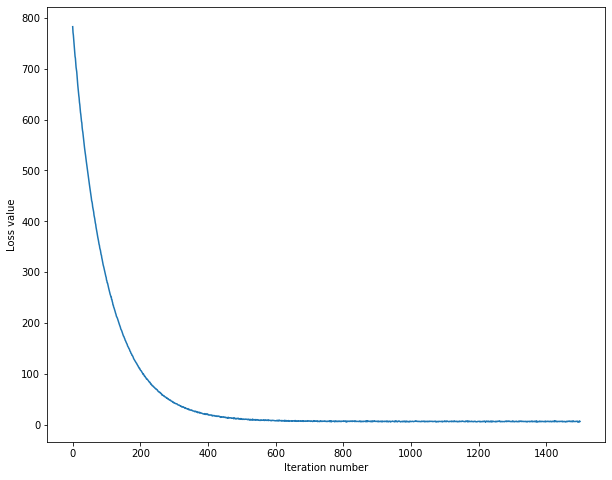

In [37]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()
# print(loss_hist)

In [39]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.334122
validation accuracy: 0.352000


In [53]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools
# 其实就是调节超参数
experiments = itertools.product(learning_rates, regularization_strengths)
for lr, reg in experiments:
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500//3, verbose=True)
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % train_accuracy)
    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % val_accuracy)
    results[(lr, reg)] = train_accuracy, val_accuracy
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)







  0%|                                                                                          | 0/500 [00:00<?, ?it/s]





  0%|▏                                                                                 | 1/500 [00:00<06:14,  1.33it/s]

iteration 0 / 500: loss 794.059834








  0%|▎                                                                                 | 2/500 [00:01<06:16,  1.32it/s]





  1%|▍                                                                                 | 3/500 [00:02<06:24,  1.29it/s]





  1%|▋                                                                                 | 4/500 [00:03<06:31,  1.27it/s]





  1%|▊                                                                                 | 5/500 [00:04<06:39,  1.24it/s]





  1%|▉                                                                                 | 6/500 [00:04<06:43,  1.22it/s]





  1%|█▏                                                                                | 7/500 [00:05<06:45,  1.22it/s]





  2%|█▎                                                                                | 8/500 [00:06<06:43,  1.22it/s]





  2%|█▍                                                                                | 9/500 [00:07<06:42,  1.22it/s]

iteration 100 / 500: loss 290.620645








 20%|████████████████▎                                                               | 102/500 [01:08<03:25,  1.94it/s]





 21%|████████████████▍                                                               | 103/500 [01:09<03:23,  1.95it/s]





 21%|████████████████▋                                                               | 104/500 [01:09<03:20,  1.98it/s]





 21%|████████████████▊                                                               | 105/500 [01:10<03:18,  1.99it/s]





 21%|████████████████▉                                                               | 106/500 [01:10<03:15,  2.02it/s]





 21%|█████████████████                                                               | 107/500 [01:11<03:15,  2.01it/s]





 22%|█████████████████▎                                                              | 108/500 [01:11<03:12,  2.04it/s]





 22%|█████████████████▍                                                              | 109/500 [01:12<03:11,  2.04it/s]

iteration 200 / 500: loss 110.216743








 41%|████████████████████████████████▍                                               | 203/500 [01:42<00:51,  5.82it/s]





 41%|████████████████████████████████▋                                               | 204/500 [01:42<00:49,  5.94it/s]





 41%|████████████████████████████████▊                                               | 205/500 [01:42<00:48,  6.08it/s]





 41%|████████████████████████████████▉                                               | 206/500 [01:42<00:47,  6.19it/s]





 41%|█████████████████████████████████                                               | 207/500 [01:43<00:46,  6.35it/s]





 42%|█████████████████████████████████▎                                              | 208/500 [01:43<00:44,  6.49it/s]





 42%|█████████████████████████████████▍                                              | 209/500 [01:43<00:43,  6.66it/s]





 42%|█████████████████████████████████▌                                              | 210/500 [01:43<00:42,  6.84it/s]

iteration 300 / 500: loss 43.688704








 60%|████████████████████████████████████████████████▎                               | 302/500 [02:28<02:12,  1.49it/s]





 61%|████████████████████████████████████████████████▍                               | 303/500 [02:29<02:12,  1.49it/s]





 61%|████████████████████████████████████████████████▋                               | 304/500 [02:30<02:10,  1.50it/s]





 61%|████████████████████████████████████████████████▊                               | 305/500 [02:30<02:08,  1.51it/s]





 61%|████████████████████████████████████████████████▉                               | 306/500 [02:31<02:07,  1.52it/s]





 61%|█████████████████████████████████████████████████                               | 307/500 [02:31<02:06,  1.53it/s]





 62%|█████████████████████████████████████████████████▎                              | 308/500 [02:32<02:04,  1.54it/s]





 62%|█████████████████████████████████████████████████▍                              | 309/500 [02:33<02:03,  1.54it/s]

iteration 400 / 500: loss 20.329486








 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [03:18<00:32,  2.97it/s]





 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [03:18<00:32,  3.00it/s]





 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [03:18<00:31,  3.05it/s]





 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [03:19<00:30,  3.07it/s]





 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [03:19<00:30,  3.10it/s]





 81%|█████████████████████████████████████████████████████████████████               | 407/500 [03:19<00:29,  3.14it/s]





 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [03:19<00:29,  3.17it/s]





 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [03:20<00:28,  3.22it/s]

training accuracy: 0.319204
validation accuracy: 0.324000








  0%|                                                                                          | 0/500 [00:00<?, ?it/s]





  0%|▏                                                                                 | 1/500 [00:00<06:54,  1.20it/s]

iteration 0 / 500: loss 1543.202276








  0%|▎                                                                                 | 2/500 [00:01<06:54,  1.20it/s]





  1%|▍                                                                                 | 3/500 [00:02<06:52,  1.20it/s]





  1%|▋                                                                                 | 4/500 [00:03<06:53,  1.20it/s]





  1%|▊                                                                                 | 5/500 [00:04<06:50,  1.20it/s]





  1%|▉                                                                                 | 6/500 [00:04<06:49,  1.21it/s]





  1%|█▏                                                                                | 7/500 [00:05<06:46,  1.21it/s]





  2%|█▎                                                                                | 8/500 [00:06<06:43,  1.22it/s]





  2%|█▍                                                                                | 9/500 [00:07<06:42,  1.22it/s]

iteration 100 / 500: loss 210.101579








 20%|████████████████▎                                                               | 102/500 [01:08<03:23,  1.96it/s]





 21%|████████████████▍                                                               | 103/500 [01:09<03:21,  1.97it/s]





 21%|████████████████▋                                                               | 104/500 [01:09<03:20,  1.97it/s]





 21%|████████████████▊                                                               | 105/500 [01:10<03:18,  1.99it/s]





 21%|████████████████▉                                                               | 106/500 [01:10<03:16,  2.01it/s]





 21%|█████████████████                                                               | 107/500 [01:11<03:13,  2.03it/s]





 22%|█████████████████▎                                                              | 108/500 [01:11<03:11,  2.04it/s]





 22%|█████████████████▍                                                              | 109/500 [01:12<03:10,  2.05it/s]

iteration 200 / 500: loss 33.975530








 41%|████████████████████████████████▍                                               | 203/500 [01:42<00:51,  5.72it/s]





 41%|████████████████████████████████▋                                               | 204/500 [01:42<00:50,  5.82it/s]





 41%|████████████████████████████████▊                                               | 205/500 [01:42<00:49,  5.91it/s]





 41%|████████████████████████████████▉                                               | 206/500 [01:42<00:48,  6.08it/s]





 41%|█████████████████████████████████                                               | 207/500 [01:42<00:47,  6.12it/s]





 42%|█████████████████████████████████▎                                              | 208/500 [01:43<00:45,  6.36it/s]





 42%|█████████████████████████████████▍                                              | 209/500 [01:43<00:44,  6.55it/s]





 42%|█████████████████████████████████▌                                              | 210/500 [01:43<00:42,  6.76it/s]

iteration 300 / 500: loss 10.304386








 60%|████████████████████████████████████████████████▎                               | 302/500 [02:28<02:13,  1.48it/s]





 61%|████████████████████████████████████████████████▍                               | 303/500 [02:29<02:11,  1.49it/s]





 61%|████████████████████████████████████████████████▋                               | 304/500 [02:29<02:10,  1.50it/s]





 61%|████████████████████████████████████████████████▊                               | 305/500 [02:30<02:09,  1.51it/s]





 61%|████████████████████████████████████████████████▉                               | 306/500 [02:31<02:08,  1.51it/s]





 61%|█████████████████████████████████████████████████                               | 307/500 [02:31<02:06,  1.53it/s]





 62%|█████████████████████████████████████████████████▎                              | 308/500 [02:32<02:05,  1.53it/s]





 62%|█████████████████████████████████████████████████▍                              | 309/500 [02:33<02:03,  1.55it/s]

iteration 400 / 500: loss 7.004496








 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [03:17<00:32,  2.98it/s]





 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [03:18<00:32,  2.99it/s]





 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [03:18<00:31,  3.03it/s]





 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [03:18<00:31,  3.05it/s]





 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [03:19<00:30,  3.09it/s]





 81%|█████████████████████████████████████████████████████████████████               | 407/500 [03:19<00:29,  3.10it/s]





 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [03:19<00:28,  3.18it/s]





 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [03:20<00:28,  3.21it/s]

training accuracy: 0.321592
validation accuracy: 0.345000








  0%|                                                                                          | 0/500 [00:00<?, ?it/s]





  0%|▏                                                                                 | 1/500 [00:00<07:01,  1.18it/s]

iteration 0 / 500: loss 791.782874








  0%|▎                                                                                 | 2/500 [00:01<07:00,  1.18it/s]





  1%|▍                                                                                 | 3/500 [00:02<07:03,  1.17it/s]





  1%|▋                                                                                 | 4/500 [00:03<07:01,  1.18it/s]





  1%|▊                                                                                 | 5/500 [00:04<06:57,  1.19it/s]





  1%|▉                                                                                 | 6/500 [00:05<06:55,  1.19it/s]





  1%|█▏                                                                                | 7/500 [00:05<06:50,  1.20it/s]





  2%|█▎                                                                                | 8/500 [00:06<06:50,  1.20it/s]





  2%|█▍                                                                                | 9/500 [00:07<06:48,  1.20it/s]

iteration 100 / 500: loss 239624812573255430775395700399279177728.000000








 20%|████████████████▎                                                               | 102/500 [01:10<03:45,  1.77it/s]





 21%|████████████████▍                                                               | 103/500 [01:11<03:36,  1.83it/s]





 21%|████████████████▋                                                               | 104/500 [01:11<03:41,  1.79it/s]





 21%|████████████████▊                                                               | 105/500 [01:12<03:33,  1.85it/s]





 21%|████████████████▉                                                               | 106/500 [01:12<03:40,  1.79it/s]





 21%|█████████████████                                                               | 107/500 [01:13<03:32,  1.85it/s]





 22%|█████████████████▎                                                              | 108/500 [01:13<03:26,  1.89it/s]





 22%|█████████████████▍                                                              | 109/500 [01:14<03:35,  1.81it/s]

iteration 200 / 500: loss 39608062382123275967588433387626102131854098678642879693346822044134670336.000000








 40%|████████████████████████████████▎                                               | 202/500 [01:53<01:26,  3.43it/s]





 41%|████████████████████████████████▍                                               | 203/500 [01:53<01:22,  3.58it/s]





 41%|████████████████████████████████▋                                               | 204/500 [01:53<01:19,  3.71it/s]





 41%|████████████████████████████████▊                                               | 205/500 [01:54<01:17,  3.83it/s]





 41%|████████████████████████████████▉                                               | 206/500 [01:54<01:13,  3.98it/s]





 41%|█████████████████████████████████                                               | 207/500 [01:54<01:10,  4.15it/s]





 42%|█████████████████████████████████▎                                              | 208/500 [01:54<01:08,  4.28it/s]





 42%|█████████████████████████████████▍                                              | 209/500 [01:54<01:05,  4.42it/s]

iteration 300 / 500: loss 6546895493915405159457139194585143954023112017471387001938089497698847473757104929800933821139543739896692736.000000








 60%|████████████████████████████████████████████████▎                               | 302/500 [03:33<03:34,  1.08s/it]





 61%|████████████████████████████████████████████████▍                               | 303/500 [03:34<03:23,  1.03s/it]





 61%|████████████████████████████████████████████████▋                               | 304/500 [03:35<03:15,  1.00it/s]





 61%|████████████████████████████████████████████████▊                               | 305/500 [03:36<03:08,  1.03it/s]





 61%|████████████████████████████████████████████████▉                               | 306/500 [03:37<03:03,  1.05it/s]





 61%|█████████████████████████████████████████████████                               | 307/500 [03:38<02:59,  1.07it/s]





 62%|█████████████████████████████████████████████████▎                              | 308/500 [03:39<02:56,  1.09it/s]





 62%|█████████████████████████████████████████████████▍                              | 309/500 [03:40<02:48,  1.13it/s]

iteration 400 / 500: loss 1082149391574254233206094455235385099472661352647146794262432963330167858165112650756905244192439608010670952411152112056042886449236809154035712.000000








 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [04:39<00:42,  2.32it/s]





 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [04:40<00:42,  2.28it/s]





 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [04:40<00:42,  2.26it/s]





 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [04:40<00:40,  2.32it/s]





 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [04:41<00:39,  2.37it/s]





 81%|█████████████████████████████████████████████████████████████████               | 407/500 [04:41<00:39,  2.36it/s]





 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [04:42<00:38,  2.36it/s]





 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [04:42<00:35,  2.55it/s]

training accuracy: 0.070571
validation accuracy: 0.062000








  0%|                                                                                          | 0/500 [00:00<?, ?it/s]





  0%|▏                                                                                 | 1/500 [00:01<08:36,  1.04s/it]

iteration 0 / 500: loss 1557.974125








  0%|▎                                                                                 | 2/500 [00:02<08:45,  1.06s/it]





  1%|▍                                                                                 | 3/500 [00:03<08:54,  1.08s/it]





  1%|▋                                                                                 | 4/500 [00:04<08:38,  1.04s/it]





  1%|▊                                                                                 | 5/500 [00:05<08:47,  1.07s/it]





  1%|▉                                                                                 | 6/500 [00:06<08:48,  1.07s/it]





  1%|█▏                                                                                | 7/500 [00:07<08:50,  1.08s/it]





  2%|█▎                                                                                | 8/500 [00:08<08:47,  1.07s/it]





  2%|█▍                                                                                | 9/500 [00:09<08:54,  1.09s/it]

iteration 100 / 500: loss 4071526007360643432444281599876909562911517309602709816731146833185715543252568911302571038383759187280022502627833188188160.000000








 20%|████████████████▎                                                               | 102/500 [01:32<04:11,  1.58it/s]





 21%|████████████████▍                                                               | 103/500 [01:32<04:19,  1.53it/s]





 21%|████████████████▋                                                               | 104/500 [01:33<04:17,  1.54it/s]





 21%|████████████████▊                                                               | 105/500 [01:34<04:13,  1.56it/s]





 21%|████████████████▉                                                               | 106/500 [01:34<04:19,  1.52it/s]





 21%|█████████████████                                                               | 107/500 [01:35<04:14,  1.54it/s]





 22%|█████████████████▎                                                              | 108/500 [01:36<04:07,  1.58it/s]





 22%|█████████████████▍                                                              | 109/500 [01:36<04:10,  1.56it/s]

iteration 200 / 500: loss 10513697536134699188477856505462365939069653845294923735501828071435944201480624182332349387917856177748694218744063610672987085496563968667646121370754542105178566838693561424255636001561938569953657309962328810807114703317795475655131041628160.000000








 40%|████████████████████████████████▎                                               | 202/500 [02:15<01:04,  4.64it/s]





 41%|████████████████████████████████▍                                               | 203/500 [02:15<01:04,  4.63it/s]





 41%|████████████████████████████████▋                                               | 204/500 [02:16<01:03,  4.69it/s]





 41%|████████████████████████████████▊                                               | 205/500 [02:16<01:00,  4.90it/s]





 41%|████████████████████████████████▉                                               | 206/500 [02:16<00:59,  4.98it/s]





 41%|█████████████████████████████████                                               | 207/500 [02:16<01:00,  4.88it/s]





 42%|█████████████████████████████████▎                                              | 208/500 [02:16<00:59,  4.87it/s]





 42%|█████████████████████████████████▍                                              | 209/500 [02:17<01:00,  4.83it/s]

iteration 300 / 500: loss inf








 60%|████████████████████████████████████████████████▎                               | 302/500 [03:42<04:32,  1.38s/it]





 61%|████████████████████████████████████████████████▍                               | 303/500 [03:43<04:28,  1.36s/it]





 61%|████████████████████████████████████████████████▋                               | 304/500 [03:44<04:26,  1.36s/it]





 61%|████████████████████████████████████████████████▊                               | 305/500 [03:46<04:21,  1.34s/it]





 61%|████████████████████████████████████████████████▉                               | 306/500 [03:47<04:17,  1.33s/it]





 61%|█████████████████████████████████████████████████                               | 307/500 [03:48<04:13,  1.31s/it]





 62%|█████████████████████████████████████████████████▎                              | 308/500 [03:50<04:09,  1.30s/it]





 62%|█████████████████████████████████████████████████▍                              | 309/500 [03:51<04:08,  1.30s/it]

iteration 400 / 500: loss inf








 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [05:29<01:09,  1.42it/s]





 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [05:30<01:06,  1.45it/s]





 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [05:31<01:04,  1.48it/s]





 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [05:31<01:03,  1.49it/s]





 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [05:32<01:01,  1.53it/s]





 81%|█████████████████████████████████████████████████████████████████               | 407/500 [05:32<00:59,  1.56it/s]





 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [05:33<00:58,  1.58it/s]





 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [05:34<00:57,  1.59it/s]

training accuracy: 0.086653
validation accuracy: 0.096000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.319204 val accuracy: 0.324000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.321592 val accuracy: 0.345000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.070571 val accuracy: 0.062000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.086653 val accuracy: 0.096000
best validation accuracy achieved during cross-validation: 0.345000


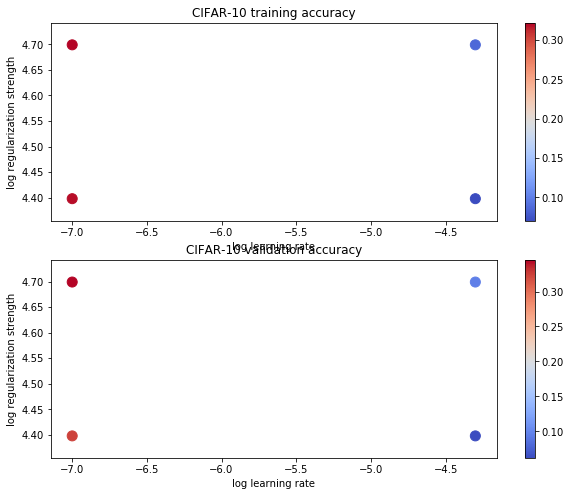

In [54]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [55]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.328000


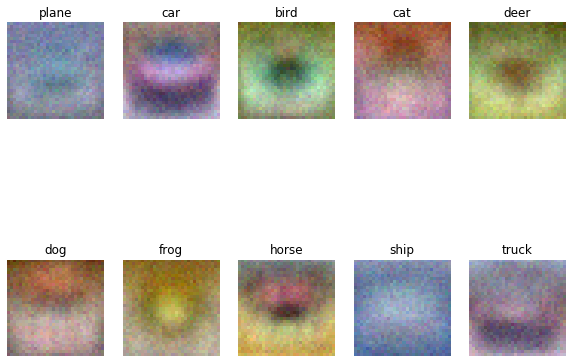

In [56]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ 有点像甜甜圈 
